## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#060108; font-size:200%; text-align:center; border-radius:10px 10px;">The Capstone Project of Data Analytics</p>

<img src=https://i.ibb.co/b5xXg11/used-cars1.jpg width="1100" height="100">

[Image Credit](https://myscriptneedshelp.com/2022/auto/buying-used-cars-in-tempe-is-easier-now/)

## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#060108; font-size:150%; text-align:center; border-radius:10px 10px;">Car Price Prediction EDA</p>

<a id="toc"></a>

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Content</p>

* [IMPORTING LIBRARIES NEEDED IN THIS NOTEBOOK](#0)
* [PART-03 (HANDLING WITH OUTLIERS)](#1)
* [THE EXAMINATION OF OUTLIERS IN THE COLUMNS](#2)
* [SOME SPECIFIC OUESTIONS ON ANALYSIS](#3)    
* [AN ANALYSIS OF INFERENTIAL STATISTICS/HYPOTHESIS TESTING ON SOME SPECIFIC FEATURES](#4)    
* [DUMMY OPERATION](#5)    
* [THE END OF DATA CLEANING (PART - 03)](#6)

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Importing Libraries Needed in This Notebook</p>

<a id="0"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

In [1]:
# !pip install termcolor

In [2]:
# conda install geopandas  # you have to install it at Anaconda Prompt
# conda install -c conda-forge geopy  # you have to install it at Anaconda Prompt
# !pip install shapely
# conda install descartes  
# !pip install descarteslabs[complete]
# !pip install -U scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
import re

import requests
!pip install geopy
import geopy
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

plt.rcParams["figure.figsize"] = (10, 6)
# plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 2000
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', df.shape[0]+1)
pd.options.display.max_columns = 150

## User Defined Functions (DEFs) to fill the missing values

In [226]:
# User Defined Function for first-looking to the features/columns

def first_looking(col):
    print("COLUMN NAME    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print("--------------------------------")
    print(df[col].value_counts(dropna = False))

In [227]:
def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False))

In [228]:
def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False))

In [229]:
def fill(df, group_col1, group_col2, col_name, method): # method can be either "mode" or "mean" or "median" or "ffill"
    
    '''Fills the missing values with "mode/mean/median/ffill/bfill method" according to double-stage grouping'''
    
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])

    elif method == "mean":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df[col_name].mean(), inplace = True)
        
    elif method == "median":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df[col_name].median(), inplace = True)
        
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False))

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">PART - 03 (Handling with Outliers)</p>

<a id="1"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

In [230]:
df0 = pd.read_csv("filled_scout2022.csv")
df = df0.copy()

In [231]:
df.head(3).T

,0,1,2
make_model,Mercedes-Benz A 160,Mercedes-Benz EQE 350,Mercedes-Benz A 45 AMG
make,Mercedes-Benz,Mercedes-Benz,Mercedes-Benz
location,"P.I. EL PALMAR C/FORJA 6, 11500 PUERTO DE SAN...","APARTADO DE CORREOS 1032, 26140 LOGROÑO, ES","PORT. TARRACO, MOLL DE LLEVANT, Nº 5, LOC. 6-8..."
price,16950.0,80900.0,69900.0
body_type,Compact,Compact,Compact
type,Used,Pre-registered,Used
doors,5.0,4.0,5.0
warranty,Yes,Yes,Yes
mileage,120200.0,5000.0,18900.0
gearbox,Manual,Automatic,Automatic


In [232]:
# pd.set_option('display.max_rows', df.shape[0]+1)

df.shape

(28630, 29)

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28630 entries, 0 to 28629
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   make_model                     28630 non-null  object 
 1   make                           28630 non-null  object 
 2   location                       28630 non-null  object 
 3   price                          28630 non-null  float64
 4   body_type                      28630 non-null  object 
 5   type                           28630 non-null  object 
 6   doors                          28630 non-null  float64
 7   warranty                       28630 non-null  object 
 8   mileage                        28630 non-null  float64
 9   gearbox                        28630 non-null  object 
 10  fuel_type                      28630 non-null  object 
 11  seller                         28630 non-null  object 
 12  seats                          28630 non-null 

In [234]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def check_obj_columns(df):
    '''
    Returns NO PROBLEM or column/s which has/have mixed object types.
    '''    
    
    tdf = df.select_dtypes(include=['object']).applymap(type)
    for col in tdf:
        if len(set(tdf[col].values)) > 1:
            print("Column" + " " + color.BOLD + color.RED + col + color.END + " " + "has mixed object types." )
    else:
        if len(set(tdf[col].values)) == 1:
            print(color.BOLD + color.GREEN + " " + "NO PROBLEM" + " " + color.END + " " + "with the data types of Columns in the DataFrame.")

check_obj_columns(df)

 NO PROBLEM  with the data types of Columns in the DataFrame.


In [235]:
df.isnull().sum()*100 / df.shape[0]

make_model                       0.0
make                             0.0
location                         0.0
price                            0.0
body_type                        0.0
type                             0.0
doors                            0.0
warranty                         0.0
mileage                          0.0
gearbox                          0.0
fuel_type                        0.0
seller                           0.0
seats                            0.0
engine_size                      0.0
gears                            0.0
co_emissions                     0.0
drivetrain                       0.0
extras                           0.0
empty_weight                     0.0
full_service_history             0.0
upholstery                       0.0
previous_owner                   0.0
energy_efficiency_class          0.0
age                              0.0
power_kW                         0.0
cons_avg                         0.0
comfort_&_convenience_Package    0.0
e

In [236]:
df.duplicated(keep=False).sum()

3806

In [237]:
numeric_col = df.select_dtypes(include="number")
display(numeric_col.columns)
numeric_col

Index(['price', 'doors', 'mileage', 'seats', 'engine_size', 'gears',
       'co_emissions', 'empty_weight', 'previous_owner', 'age', 'power_kW',
       'cons_avg'],
      dtype='object')

,price,doors,mileage,seats,engine_size,gears,co_emissions,empty_weight,previous_owner,age,power_kW,cons_avg
0,16950.0,5.0,120200.0,5.0,1595.0,5.0,98.0,1270.0,2.0,6.0,75.0,3.800
1,80900.0,4.0,5000.0,5.0,1.0,9.0,0.0,2355.0,1.0,0.0,215.0,2.359
2,69900.0,5.0,18900.0,5.0,1991.0,8.0,162.0,1555.0,2.0,2.0,310.0,8.400
3,46990.0,5.0,18995.0,5.0,1991.0,7.0,169.0,1455.0,2.0,2.0,225.0,7.300
4,16800.0,5.0,197000.0,5.0,2143.0,7.0,162.0,1545.0,2.0,7.0,100.0,4.900
...,...,...,...,...,...,...,...,...,...,...,...,...
28625,37600.0,4.0,40345.0,4.0,1969.0,8.0,127.0,2077.0,2.0,3.0,288.0,2.000
28626,5499.0,4.0,145000.0,5.0,2435.0,5.0,217.0,1357.0,3.0,18.0,125.0,9.100
28627,7300.0,3.0,96000.0,4.0,1560.0,6.0,99.0,1356.0,1.0,11.0,84.0,3.800
28628,29900.0,4.0,94343.0,5.0,1969.0,8.0,149.0,1617.0,1.0,5.0,187.0,6.500


## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">The Examination of OUTLIERS in the Columns</p>

<a id="2"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

## price (Target/Label Variable)

In [238]:
first_looking("price")

COLUMN NAME    :  price
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5021
--------------------------------
14990.0    222
12990.0    219
16990.0    186
19990.0    166
9990.0     160
          ... 
19112.0      1
30465.0      1
18461.0      1
22649.0      1
4440.0       1
Name: price, Length: 5021, dtype: int64


A boxplot is a way of summarizing a set of data measured on an interval scale. It is often used in exploratory data analysis. It is a type of graph which is used to show the shape of the distribution, its central value, and variability.

The following boxplot represents car prices of different makes and models. This boxplot is NOT using a common rule of 1.5 IQR, rather applying for 3.0 IQR that points out the values could be assumed as extreme if they lie more than 3.0 IQR from the nearer quartile. 

**However**, it should be noted that there is no universal agreement on what an "extreme value" is, exactly. And, in practice, it depends on context. What that means is specific to the dataset and the goals of the analysis, so any Data Scientist should be hesitant to perform an outlier removal to any dataset. On the other hand, what this box plot tells us is: skewness is so marked that one might assume to transform them! 

In [239]:
df.price.describe()

count     28630.000000
mean      23470.662173
std       23953.503570
min         490.000000
25%       11990.000000
50%       17979.000000
75%       27990.000000
max      999999.000000
Name: price, dtype: float64

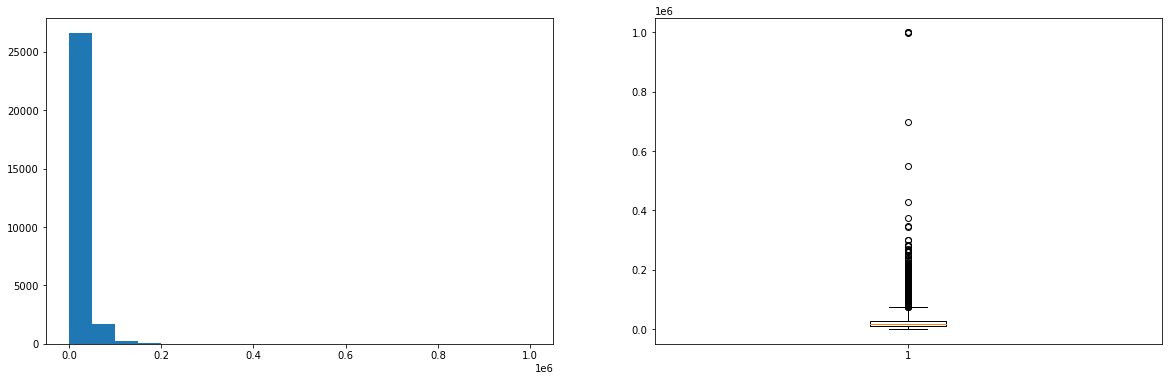

In [240]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.price, bins=20)

plt.subplot(122)
plt.boxplot(df.price, whis=3)

plt.show()

In [241]:
df.price.sort_values().head(20)

5847     490.0
19565    500.0
5513     500.0
17516    590.0
5291     600.0
5351     600.0
5296     699.0
23792    700.0
3375     700.0
5519     740.0
5279     750.0
24546    750.0
20114    750.0
7812     750.0
5630     790.0
7835     790.0
2504     790.0
6460     790.0
3149     799.0
8187     800.0
Name: price, dtype: float64

In [242]:
df.price.sort_values().tail(20)

1587     259000.0
1397     259880.0
19314    264900.0
1413     267810.0
1320     268900.0
1114     279000.0
1444     279063.0
710      283900.0
1595     284780.0
1076     299000.0
1451     299000.0
1305     344900.0
21927    349000.0
1317     375900.0
21606    430000.0
21553    549000.0
1212     696900.0
21919    998000.0
28184    999999.0
27804    999999.0
Name: price, dtype: float64

**As seen above dataset has some unexpected values of 999999.000.**

**What might a data entry of 999999 mean?**

The missing value code should be a value that could not possibly show up as a true data value in the dataset. Sometimes, codes such as "-999999" or "999999" are used so that the code is easy to recognize when you scan a column of data. Any integer value can be used, including negative numbers.

In [243]:
df.price.sort_values().tail(20).index[:20]

Int64Index([ 1587,  1397, 19314,  1413,  1320,  1114,  1444,   710,  1595,
             1076,  1451,  1305, 21927,  1317, 21606, 21553,  1212, 21919,
            28184, 27804],
           dtype='int64')

In [244]:
df.iloc[[1587,  1397, 19314,  1413,  1320,  1114,  1444,   710,  1595,
         1076,  1451,  1305, 21927,  1317, 21606, 21553,  1212, 21919,
         28184, 27804]]

,make_model,make,location,price,body_type,type,doors,warranty,mileage,gearbox,...,full_service_history,upholstery,previous_owner,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package
1587,Mercedes-Benz G 63 AMG,Mercedes-Benz,"Meckenheimer Straße 12, 53359 Rheinbach, DE",259000.0,Off-Road/Pick-up,Used,5.0,Yes,4003.0,Automatic,...,No,Part/Full Leather,1.0,unefficient,0.0,430.0,14.4,Standard,Plus,Safety Premium Package
1397,Mercedes-Benz G 63 AMG,Mercedes-Benz,"Pankofen-Irlwiesen 3, 94447 Plattling, DE",259880.0,Off-Road/Pick-up,Demonstration,5.0,Yes,9900.0,Automatic,...,Yes,Part/Full Leather,1.0,unefficient,0.0,430.0,13.8,Premium,Plus,Safety Premium Package
19314,Nissan Skyline,Nissan,"CTRA. DE RUBI, 88 (EDIFICIO CAN CASTANYER), 8...",264900.0,Coupe,Used,2.0,No,45000.0,Manual,...,No,Cloth,1.0,efficient,22.0,313.0,12.0,Standard,Standard,Safety Standard Package
1413,Mercedes-Benz G 63 AMG,Mercedes-Benz,"Hallesche Straße 150, 99734 Nordhausen, DE",267810.0,Off-Road/Pick-up,Demonstration,5.0,Yes,3003.0,Automatic,...,Yes,Part/Full Leather,1.0,unefficient,0.0,430.0,14.4,Premium,Plus,Safety Premium Package
1320,Mercedes-Benz G 63 AMG,Mercedes-Benz,"Poligono Industrial Sud, sector P3 Nave 10, 8...",268900.0,Off-Road/Pick-up,Pre-registered,5.0,Yes,1800.0,Automatic,...,No,Part/Full Leather,1.0,unefficient,0.0,430.0,0.0,Standard,Plus,Safety Premium Package
1114,Mercedes-Benz SLS,Mercedes-Benz,"Wagenzeller Str.13, 30855 Langenhagen / Kalte...",279000.0,Coupe,Used,2.0,No,30000.0,Automatic,...,No,Part/Full Leather,1.0,efficient,12.0,420.0,13.2,Standard,Standard,Safety Premium Package
1444,Mercedes-Benz G 63 AMG,Mercedes-Benz,"Frankfurter Straße 49, 38122 Braunschweig, DE",279063.0,Off-Road/Pick-up,Demonstration,5.0,No,9900.0,Automatic,...,Yes,Part/Full Leather,1.0,unefficient,0.0,430.0,13.1,Standard,Plus,Safety Premium Package
710,Mercedes-Benz AMG GT,Mercedes-Benz,"Halbenrainer Straße 10, 8490 Bad Radkersburg, AT",283900.0,Convertible,Used,3.0,Yes,3569.0,Automatic,...,Yes,Part/Full Leather,1.0,unefficient,0.0,409.0,13.0,Standard,Standard,Safety Premium Package
1595,Mercedes-Benz G 63 AMG,Mercedes-Benz,"Landshuter Str. 1, 94315 Straubing, DE",284780.0,Off-Road/Pick-up,Demonstration,5.0,Yes,9900.0,Automatic,...,Yes,Part/Full Leather,1.0,unefficient,0.0,430.0,13.8,Premium,Plus,Safety Premium Package
1076,Mercedes-Benz GLE 63 AMG,Mercedes-Benz,"Viernheimer Strasse 100, 69469 Weinheim, DE",299000.0,Coupe,Demonstration,4.0,No,8000.0,Automatic,...,Yes,Part/Full Leather,1.0,unefficient,1.0,588.0,11.5,Premium,Plus,Safety Premium Package


In [245]:
# df.loc[df["make_model"] == "Volvo 240"][["make_model", "price", "age", "body_type", "mileage", "engine_size", "gears", "drivetrain"]]
# df.loc[df["make_model"] == "Mercedes-Benz G 63 AMG"][["make_model", "price", "age", "body_type", "mileage", "engine_size", "gears", "drivetrain"]]
# df.loc[df["make_model"] == "Ford GT"][["make_model", "price", "age", "body_type", "mileage", "engine_size", "gears", "drivetrain"]]
df.loc[df["make_model"] == "Nissan Skyline"][["make_model", "price", "age", "body_type", "mileage", "engine_size", "gears", "drivetrain"]]

,make_model,price,age,body_type,mileage,engine_size,gears,drivetrain
19276,Nissan Skyline,64950.0,26.0,Coupe,148461.0,2740.0,5.0,Rear
19297,Nissan Skyline,35160.0,26.0,Coupe,114003.0,2500.0,5.0,Rear
19299,Nissan Skyline,83000.0,51.0,Coupe,86000.0,2500.0,5.0,Rear
19305,Nissan Skyline,34500.0,30.0,Coupe,29500.0,2000.0,5.0,Rear
19314,Nissan Skyline,264900.0,22.0,Coupe,45000.0,2500.0,5.0,Rear
19315,Nissan Skyline,51000.0,31.0,Coupe,117000.0,2600.0,5.0,4WD
19317,Nissan Skyline,149990.0,22.0,Coupe,52000.0,2500.0,6.0,Rear
19389,Nissan Skyline,159999.0,23.0,Coupe,68314.0,2598.0,6.0,4WD
19390,Nissan Skyline,36000.0,26.0,Coupe,122000.0,2500.0,5.0,Rear
19396,Nissan Skyline,65000.0,27.0,Coupe,25700.0,2600.0,5.0,4WD


In [246]:
indexMercedes = df[(df["make_model"] == "Mercedes-Benz G 63 AMG") & (df['price'] >= 400000)].index
indexVolvo = df[(df["make_model"] == "Volvo 240") & (df['price'] >= 100000)].index
indexFord = df[(df["make_model"] == "Ford GT") & (df['price'] >= 600000)].index
indexNissan = df[(df["make_model"] == "Nissan Skyline") & (df['price'] >= 140000)].index

In [247]:
print(df.shape)
df.drop(indexMercedes, inplace=True)
df.drop(indexVolvo, inplace=True)
df.drop(indexFord, inplace=True)
df.drop(indexNissan, inplace=True)
print(df.shape)

(28630, 29)
(28621, 29)


In [248]:
df.price.sort_values().tail(20)

438      239000.0
21312    240000.0
1393     248800.0
1502     249890.0
21961    250000.0
1587     259000.0
1397     259880.0
1413     267810.0
1320     268900.0
1114     279000.0
1444     279063.0
710      283900.0
1595     284780.0
1076     299000.0
1451     299000.0
1305     344900.0
21927    349000.0
1317     375900.0
21606    430000.0
21553    549000.0
Name: price, dtype: float64

In [249]:
df.shape

(28621, 29)

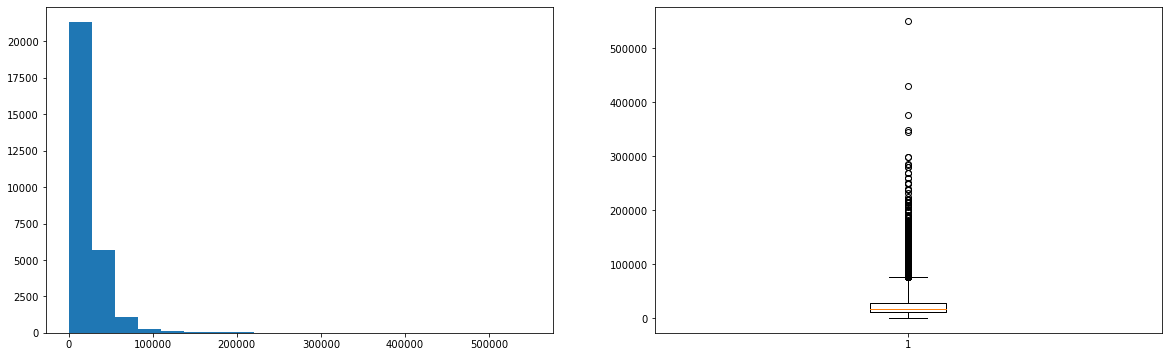

In [250]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.price, bins=20)

plt.subplot(122)
plt.boxplot(df.price, whis=3)

plt.show()

In [251]:
# plt.figure(figsize=(16, 6))
# sns.boxplot(x="make_model", y="price", data=df, whis=3)
# plt.show()

## doors

In [252]:
first_looking("doors")

COLUMN NAME    :  doors
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
--------------------------------
5.0    17634
2.0     5663
4.0     3013
3.0     2304
6.0        5
1.0        2
Name: doors, dtype: int64


In [253]:
df[df["doors"]==1]["make_model"]

10001    Fiat 124 Spider
21140        Ford Fiesta
Name: make_model, dtype: object

In [254]:
df[df["make_model"]=="Fiat 124 Spider"][["make_model", "body_type", "doors"]].value_counts(dropna=False)

make_model       body_type    doors
Fiat 124 Spider  Convertible  2.0      56
                 Coupe        2.0      38
                 Convertible  1.0       1
                              3.0       1
dtype: int64

In [255]:
df[df["make_model"]=="Ford Fiesta"][["make_model", "body_type", "doors"]].value_counts(dropna=False)

make_model   body_type  doors
Ford Fiesta  Compact    5.0      137
             Sedan      5.0      120
             Compact    3.0       77
             Sedan      3.0       31
             Compact    4.0       18
             Sedan      4.0        6
             Compact    2.0        5
             Coupe      3.0        2
             Sedan      2.0        2
             Compact    1.0        1
             Coupe      5.0        1
dtype: int64

In [256]:
df[df["doors"]==6]["make_model"]

15931     Dacia Logan
16097     Dacia Logan
16105    Dacia Dokker
16129     Dacia Logan
16163     Dacia Logan
Name: make_model, dtype: object

In [257]:
df[df["make_model"]=="Dacia Logan"][["make_model", "body_type", "doors"]].value_counts(dropna=False)

make_model   body_type      doors
Dacia Logan  Station wagon  5.0      109
                            4.0       38
             Sedan          4.0       32
             Compact        4.0       13
             Station wagon  6.0        4
             Sedan          5.0        3
dtype: int64

In [258]:
df[df["make_model"]=="Dacia Dokker"][["make_model", "body_type", "doors"]].value_counts(dropna=False)

make_model    body_type         doors
Dacia Dokker  Station wagon     5.0      29
                                4.0      22
              Off-Road/Pick-up  4.0       2
              Compact           4.0       1
              Sedan             4.0       1
              Station wagon     6.0       1
dtype: int64

In [259]:
df["doors"].replace([1, 6], np.nan, inplace=True)

In [260]:
df["doors"].isnull().sum()

7

In [261]:
fill(df, "make_model", "body_type", "doors", "mode")

COLUMN NAME    :  doors
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
--------------------------------
5.0    17640
2.0     5664
4.0     3013
3.0     2304
Name: doors, dtype: int64


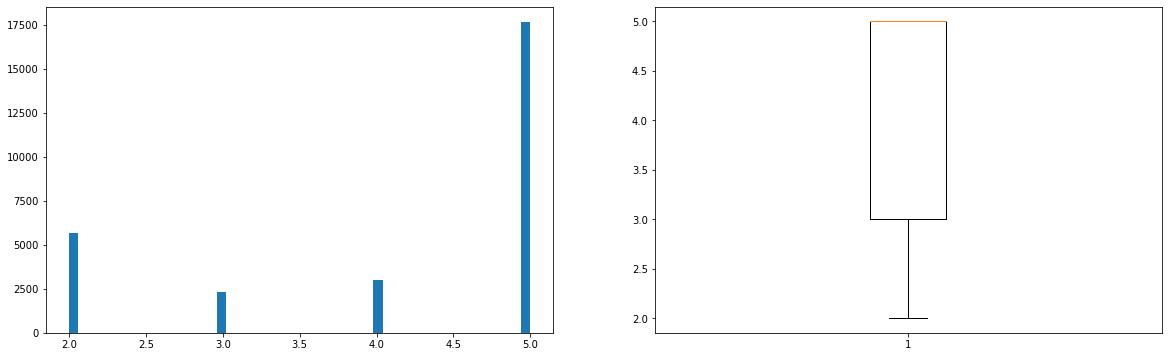

In [262]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.doors, bins=50)

plt.subplot(122)
plt.boxplot(df.doors)

plt.show()

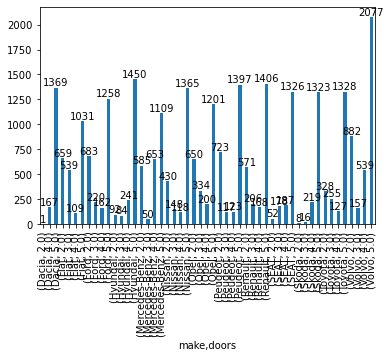

In [263]:
fig, ax = plt.subplots()

df.groupby(["make", "doors"]).doors.count().plot.bar()

for container in ax.containers:
    ax.bar_label(container);

In [264]:
print(df.shape)
df.drop("doors", axis=1, inplace=True)
print(df.shape)

(28621, 29)
(28621, 28)


## mileage

Right behind the age of the vehicle, most buyers will look at mileage. In some cases this is even more important than age, for example on vehicles that are known for their reliability. Typically, most cars start to experience issues after 100,000 odd miles, which can create expensive repair jobs. The lower the mileage, the more your car is likely to be worth.

In [265]:
first_looking("mileage")

COLUMN NAME    :  mileage
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  14183
--------------------------------
10.0        586
1.0         170
50.0        133
5000.0      118
100.0       118
           ... 
141589.0      1
59821.0       1
123500.0      1
29781.0       1
230047.0      1
Name: mileage, Length: 14183, dtype: int64


/Users/kadiryildirim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


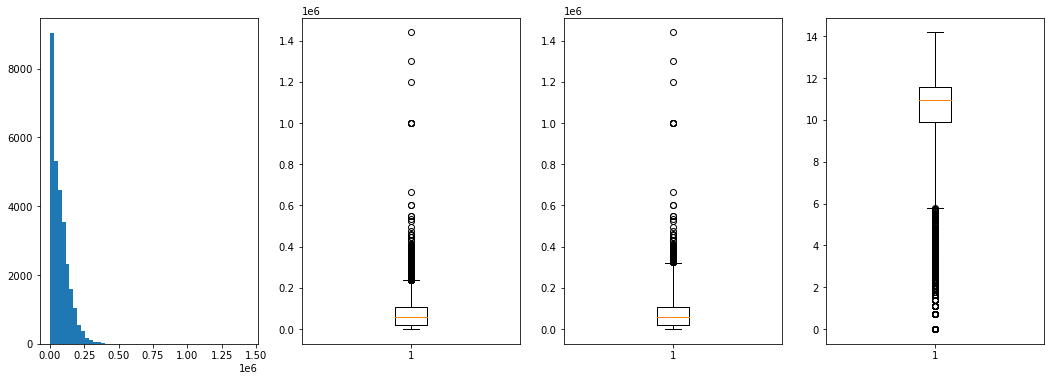

In [266]:
plt.figure(figsize=(18, 6))

plt.subplot(141)
plt.hist(df.mileage, bins=50)

plt.subplot(142)
plt.boxplot(df.mileage)

plt.subplot(143)
plt.boxplot(df.mileage, whis=2.5)

plt.subplot(144)
plt.boxplot(np.log(df.mileage), whis=2.5)

plt.show()

In [267]:
df.mileage.sort_values().head(20)

10258    0.0
16374    0.0
11078    0.0
22929    0.0
22150    0.0
18363    0.0
18382    0.0
4630     0.0
4309     0.0
22854    0.0
10982    0.0
4450     0.0
6437     0.0
11207    0.0
15950    0.0
21831    0.0
10942    0.0
14796    0.0
14753    0.0
3680     0.0
Name: mileage, dtype: float64

In [268]:
df.mileage.sort_values().tail(20)

28232     448914.0
282       457379.0
6494      461626.0
20092     477000.0
3456      494457.0
18340     523992.0
3212      536388.0
14374     546888.0
17907     547000.0
14360     600000.0
28463     600001.0
13153     667128.0
21344     999999.0
3397      999999.0
10009     999999.0
7684     1000000.0
22889    1000001.0
12169    1199900.0
17324    1300000.0
18873    1440000.0
Name: mileage, dtype: float64

In [269]:
df[df["mileage"] > 1000000][["make_model", "type", "mileage", "age"]]

,make_model,type,mileage,age
12169,SEAT Ibiza,Used,1199900.0,4.0
17324,Toyota Celica,Used,1300000.0,36.0
18873,Nissan Micra,Used,1440000.0,3.0
22889,Ford Fiesta,Used,1000001.0,4.0


In [270]:
drop_mileage_index = df[df["mileage"] > 1000000][["make_model", "type", "mileage", "age"]].index
drop_mileage_index

Int64Index([12169, 17324, 18873, 22889], dtype='int64')

In [271]:
print(df.shape)
df.drop(drop_mileage_index, inplace=True)
print(df.shape)

(28621, 28)
(28617, 28)


/Users/kadiryildirim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


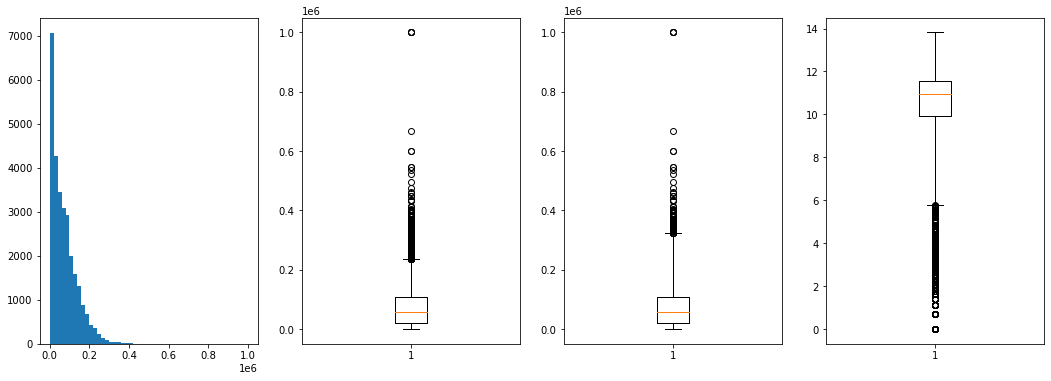

In [272]:
plt.figure(figsize=(18, 6))

plt.subplot(141)
plt.hist(df.mileage, bins=50)

plt.subplot(142)
plt.boxplot(df.mileage)

plt.subplot(143)
plt.boxplot(df.mileage, whis=2.5)

plt.subplot(144)
plt.boxplot(np.log(df.mileage), whis=2.5)

plt.show()

In [273]:
# df["mileage_logged"] = np.log(df.mileage)

**``mileage``** **is a variable with a wide range of values. However, these extreme values above CANNOT be considered as  genuine outliers since they might be a part of real world scenerio. So, let's keep these extreme values as they are.**

## seats

In [274]:
first_looking("seats")

COLUMN NAME    :  seats
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  11
--------------------------------
5.0     20713
4.0      5964
2.0      1265
7.0       542
8.0        44
9.0        35
3.0        26
6.0        12
0.0         9
1.0         5
17.0        2
Name: seats, dtype: int64


In [275]:
print(df.shape)
df.drop("seats", axis=1, inplace=True)
print(df.shape)

(28617, 28)
(28617, 27)


## engine_size

In [276]:
first_looking("engine_size")

COLUMN NAME    :  engine_size
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  466
--------------------------------
1598.0     2254
999.0      2144
1969.0     1967
1461.0     1144
1998.0     1055
           ... 
16998.0       1
1196.0        1
1489.0        1
2645.0        1
2473.0        1
Name: engine_size, Length: 466, dtype: int64


In [277]:
df["engine_size"].describe()

count    28617.000000
mean      1745.544152
std       1045.363084
min          0.000000
25%       1300.000000
50%       1598.000000
75%       1984.000000
max      99900.000000
Name: engine_size, dtype: float64

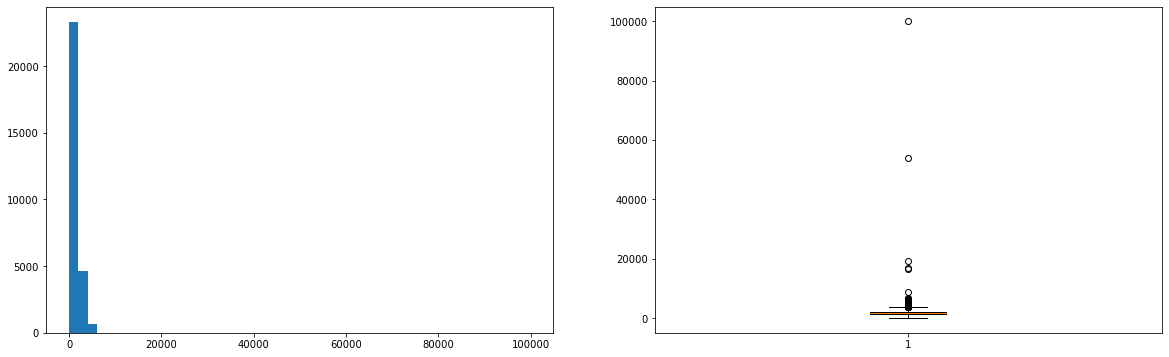

In [278]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["engine_size"], bins=50)

plt.subplot(122)
plt.boxplot(df["engine_size"], whis=2.5)

plt.show()

In [279]:
df.sort_values(by=["engine_size"], ascending=False)["engine_size"].head(20)

# df["engine_size"].sort_values(ascending=False).head(20)

16556    99900.0
21330    54009.0
716      19194.0
5580     16998.0
16105    16597.0
21667     8660.0
21797     6653.0
21653     6400.0
21345     6400.0
21393     6387.0
699       6300.0
693       6300.0
21481     6294.0
21333     6276.0
703       6209.0
2169      6208.0
813       6208.0
722       6208.0
1114      6208.0
1214      6208.0
Name: engine_size, dtype: float64

In [280]:
df.sort_values(by=["engine_size"], ascending=True)["engine_size"].head(20)

# df["engine_size"].sort_values(ascending=True).head(20)

6870     0.0
18587    0.0
10023    0.0
18607    0.0
10033    0.0
10039    0.0
9538     0.0
2745     0.0
9532     0.0
2691     0.0
2688     0.0
18586    0.0
2682     0.0
18716    0.0
16471    0.0
18725    0.0
18726    0.0
18730    0.0
18733    0.0
9522     0.0
Name: engine_size, dtype: float64

In [281]:
df["engine_size"].value_counts().sort_index(ascending=True)

0.0        330
1.0        111
2.0         12
4.0          2
5.0          3
          ... 
16597.0      1
16998.0      1
19194.0      1
54009.0      1
99900.0      1
Name: engine_size, Length: 466, dtype: int64

In [282]:
df[df["engine_size"] <= 500][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]\
                            .sort_values(by=["engine_size"], ascending=True)

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type
11620,Fiat 500e,1.0,Sedan,Automatic,Front,1.0,0.0,Electric
11640,Fiat 500e,0.0,Sedan,Automatic,Front,1.0,0.0,Electric
11632,Fiat 500e,1.0,Sedan,Automatic,Front,1.0,0.0,Electric
18964,Nissan Leaf,1.0,Compact,Automatic,Front,1.0,0.0,Electric
11619,Fiat 500e,1.0,Sedan,Automatic,Front,1.0,0.0,Electric
...,...,...,...,...,...,...,...,...
10646,Fiat 500L,51.0,Coupe,Manual,Rear,4.0,499.0,Benzine
10662,Fiat 500L,50.0,Coupe,Manual,Rear,4.0,499.0,Benzine
11247,Fiat 500,52.0,Station wagon,Manual,Front,5.0,499.0,Benzine
10168,Fiat 500,59.0,Convertible,Manual,Rear,4.0,500.0,Benzine


In [283]:
df["engine_size"].value_counts().sort_index(ascending=False)

99900.0      1
54009.0      1
19194.0      1
16998.0      1
16597.0      1
          ... 
5.0          3
4.0          2
2.0         12
1.0        111
0.0        330
Name: engine_size, Length: 466, dtype: int64

In [284]:
df[df["engine_size"] > 4000][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]\
                            .sort_values(by=["engine_size"], ascending=False)

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type
16556,Dacia Sandero,3.0,Sedan,Manual,Front,5.0,99900.0,Benzine
21330,Ford Mustang,14.0,Convertible,Manual,Rear,6.0,54009.0,Benzine
716,Mercedes-Benz SL 320,21.0,Convertible,Automatic,Rear,5.0,19194.0,Benzine
5580,Renault Megane,7.0,Coupe,Manual,Front,6.0,16998.0,Benzine
16105,Dacia Dokker,0.0,Station wagon,Manual,Front,5.0,16597.0,Liquid/Natural Gas
...,...,...,...,...,...,...,...,...
21365,Ford,14.0,Convertible,Automatic,Rear,3.0,4009.0,Benzine
21414,Ford Mustang,15.0,Convertible,Automatic,Rear,6.0,4009.0,Benzine
21446,Ford Mustang,16.0,Convertible,Automatic,Rear,6.0,4009.0,Benzine
21448,Ford Mustang,11.0,Convertible,Automatic,Rear,6.0,4009.0,Benzine


In [285]:
# df.loc[df.make_model == "Ford Thunderbird"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Ford Fairlane"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Dacia Sandero"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
df.loc[df.make_model == "Mercedes-Benz SL 320"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Renault Megane"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Dacia Dokker"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type
716,Mercedes-Benz SL 320,21.0,Convertible,Automatic,Rear,5.0,19194.0,Benzine
733,Mercedes-Benz SL 320,29.0,Convertible,Automatic,Rear,5.0,3200.0,Benzine
823,Mercedes-Benz SL 320,29.0,Coupe,Automatic,Rear,5.0,3199.0,Benzine


### 📝 Domain Knowledge About Some Vehicles on the List Above:
**🧐 [SOURCE](https://www.automobile-catalog.com/#gsc.tab=0)**

- **Ford Thunderbird Convertible (1964-1966)**, manufactured or offered in the years 1964-1966 with convertible body_type, equipped with engines of **6384 - 6997 cc (389.6 - 427 cui) displacement**, delivering 223.5 - 257 kW (304 - 350 PS, 300 - 345 hp) of horsepower.

- **Ford Fairlane**, 2-Door Hardtop 390 Thunderbird V-8 (man. 3) , model year 1968, version for North America U.S. manufactured by Ford (USA) in United States, 2-door coupe body_type, RWD (rear-wheel drive), manual 3-speed gearbox, gasoline (petrol) engine with **displacement: 6384 cm3 / 389.6 cui**, advertised power: 197.5 kW / 265 hp / 269 PS ( SAE gross ), torque: 529 Nm / 390 lb-ft.

- **Ford Mustang Mach**, manufactured by Ford (USA) in United States, 2-door coupe body_type, RWD (rear-wheel drive), manual 4-speed gearbox, gasoline (petrol) engine with **displacement: 7033 cm3 / 429.2 cui**, advertised power: 276 kW / 370 hp / 375 PS ( SAE gross ), torque: 610 Nm / 450 lb-ft.

- **Dacia Sandero SCe 65 (man. 5) (Access, Essential, Comfort)** in 2021, the model with 5-door hatchback body and Line-3 999 cm3 / 61.1 cui, 49 kW / 67 PS / 66 hp (ECE) of power, 95 Nm / 70 lb-ft of torque, 5-speed manual powertrain offered since March 2021 for Europe, **Displacement: 999 cm3 / 61.1 cui**.

- **Mercedes-Benz SL 320 (aut. 5)** in 1993, the model with 2-door convertible body and Line-6 3199 cm3 / 195.5 cui, 170 kW / 231 PS / 228 hp (ECE) of power, 315 Nm / 232 lb-ft of torque, 5-speed automatic powertrain offered since July 1993 for Europe **Displacement: 3199 cm3 / 195.5 cui**.

- **Renault Megane Coupe 1.6 Energy dCi 130 (man. 6) in 2015**, the model with 3-door hatchback (coupe) body and Line-4 1598 cm3 / 97.6 cui, 95.5 kW / 130 PS / 128 hp (ECE) of power, 320 Nm / 236 lb-ft of torque, 6-speed manual powertrain for Europe, **Displacement: 1598 cm3 / 97.6 cui**.

- **Dacia Dokker Stepway TCe 130 (man. 6)**, manufactured by Dacia in Romania assembly in Morocco, 5-door mpv body_type, FWD (front-wheel drive), manual 6-speed gearbox, gasoline (petrol) engine with **displacement: 1332 cm3 / 81.1 cui**, advertised power: 95.5 kW / 128 hp / 130 PS ( ECE ), torque: 240 Nm / 177 lb-ft

In [286]:
df[(df["engine_size"] >= 2) & (df["engine_size"] <= 500)][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]\
                            .sort_values(by=["engine_size"], ascending=True)

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type
28528,Volvo S90,1.0,Sedan,Automatic,4WD,8.0,2.0,Electric
28340,Volvo S90,1.0,Sedan,Automatic,4WD,8.0,2.0,Electric
21948,Ford Kuga,1.0,Off-Road/Pick-up,Automatic,4WD,6.0,2.0,Electric
22312,Ford Kuga,4.0,Off-Road/Pick-up,Manual,4WD,6.0,2.0,Diesel
26827,Volvo XC60,0.0,Off-Road/Pick-up,Automatic,4WD,8.0,2.0,Diesel
26950,Volvo XC90,1.0,Off-Road/Pick-up,Automatic,4WD,8.0,2.0,Diesel
27216,Volvo XC60,0.0,Off-Road/Pick-up,Automatic,4WD,8.0,2.0,Diesel
26877,Volvo XC60,0.0,Off-Road/Pick-up,Automatic,4WD,8.0,2.0,Diesel
27336,Volvo XC90,1.0,Off-Road/Pick-up,Automatic,4WD,8.0,2.0,Diesel
2140,Mercedes-Benz E 220,12.0,Sedan,Manual,Rear,9.0,2.0,Diesel


In [287]:
# df.loc[df.make_model == "Volvo S90"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Ford Kuga"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Volvo XC60"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Mercedes-Benz E 220"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Dacia Duster	"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Fiat 500 Abarth"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Opel Calibra"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Ford Mustang"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "SEAT Leon"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
# df.loc[df.make_model == "Toyota MR 2"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]
df.loc[df.make_model == "Renault Megane"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type
4783,Renault Megane,1.0,Compact,Manual,Front,6.0,1332.0,Benzine
4786,Renault Megane,1.0,Compact,Automatic,Front,6.0,1798.0,Benzine
4789,Renault Megane,4.0,Compact,Automatic,Front,7.0,1500.0,Diesel
4791,Renault Megane,7.0,Compact,Manual,Front,6.0,1461.0,Diesel
4793,Renault Megane,8.0,Compact,Manual,Front,6.0,1461.0,Diesel
...,...,...,...,...,...,...,...,...
7111,Renault Megane,0.0,Sedan,Automatic,Front,6.0,1461.0,Benzine
7115,Renault Megane,10.0,Sedan,Manual,Front,6.0,1200.0,Benzine
7117,Renault Megane,2.0,Sedan,Manual,Front,6.0,1461.0,Diesel
7118,Renault Megane,2.0,Sedan,Automatic,Front,7.0,1461.0,Diesel


In [288]:
# df.loc[((df["engine_size"] <= 300) & (df["engine_size"] > 8000)), 'engine_size'] = np.nan

outlier_eng_size = df["engine_size"].isin([4, 5, 20, 200, 289, 300, 332, 8660, 99900, 54009, 19194, 16998, 16597])
df[outlier_eng_size][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight
88,Mercedes-Benz E 300,36.0,Compact,Automatic,Rear,9.0,300.0,Liquid/Natural Gas,1550.0
716,Mercedes-Benz SL 320,21.0,Convertible,Automatic,Rear,5.0,19194.0,Benzine,1780.0
3327,Opel Calibra,30.0,Coupe,Manual,Front,5.0,200.0,Benzine,1245.0
5243,Renault Megane,18.0,Convertible,Automatic,Rear,6.0,20.0,Benzine,1395.0
5580,Renault Megane,7.0,Coupe,Manual,Front,6.0,16998.0,Benzine,1454.0
13253,SEAT Leon,1.0,Sedan,Automatic,Front,6.0,4.0,Benzine,1239.0
15606,Dacia Duster,1.0,Off-Road/Pick-up,Manual,4WD,6.0,332.0,Benzine,1320.0
16105,Dacia Dokker,0.0,Station wagon,Manual,Front,5.0,16597.0,Liquid/Natural Gas,1280.0
16556,Dacia Sandero,3.0,Sedan,Manual,Front,5.0,99900.0,Benzine,1115.0
17068,Toyota MR 2,30.0,Convertible,Manual,4WD,1.0,4.0,Benzine,1050.0


In [289]:
df.loc[outlier_eng_size, "engine_size"] = np.nan

In [290]:
df["engine_size"].isnull().sum()

16

In [291]:
fill(df, "make_model", "body_type", "engine_size", "mode")

COLUMN NAME    :  engine_size
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  453
--------------------------------
1598.0    2255
999.0     2144
1969.0    1967
1461.0    1145
1998.0    1058
          ... 
1974.0       1
5950.0       1
1616.0       1
1241.0       1
2473.0       1
Name: engine_size, Length: 453, dtype: int64


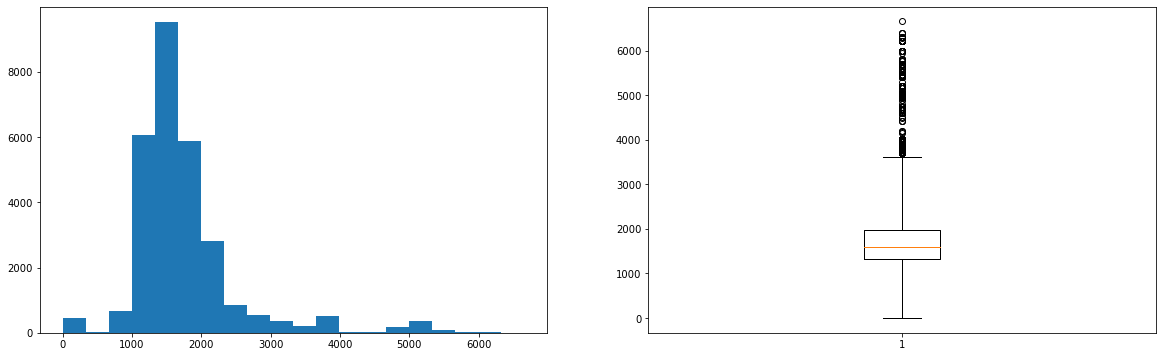

In [292]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["engine_size"], bins=20)

plt.subplot(122)
plt.boxplot(df["engine_size"], whis=2.5)

plt.show()

## gears

In [293]:
first_looking("gears")

COLUMN NAME    :  gears
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  11
--------------------------------
6.0     12244
5.0      7796
8.0      2737
7.0      2631
1.0      1348
9.0      1143
4.0       380
10.0      244
3.0        60
0.0        31
2.0         3
Name: gears, dtype: int64


In [294]:
df.gears.describe()

count    28617.000000
mean         5.889436
std          1.587757
min          0.000000
25%          5.000000
50%          6.000000
75%          6.000000
max         10.000000
Name: gears, dtype: float64

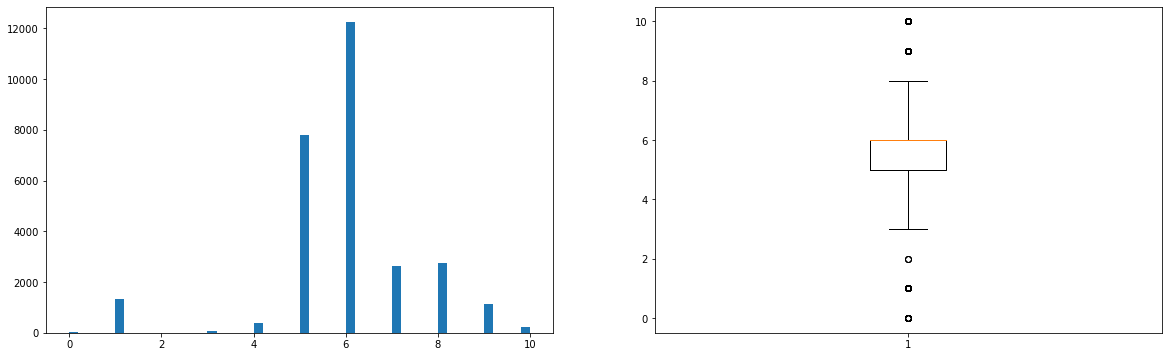

In [295]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df.gears, bins=50)

plt.subplot(122)
plt.boxplot(df.gears, whis=2.5)

plt.show()

In [296]:
df.sort_values(by=["gears"], ascending=False)["gears"].head(20)

21557    10.0
21701    10.0
21665    10.0
21666    10.0
21947    10.0
22152    10.0
21669    10.0
21673    10.0
21297    10.0
21676    10.0
21679    10.0
21680    10.0
21681    10.0
21685    10.0
21689    10.0
21690    10.0
21691    10.0
21694    10.0
21158    10.0
21695    10.0
Name: gears, dtype: float64

In [297]:
df.sort_values(by=["gears"], ascending=True)["gears"].head(20)

18121    0.0
1396     0.0
18657    0.0
17930    0.0
18598    0.0
5122     0.0
19477    0.0
12801    0.0
28557    0.0
28556    0.0
6211     0.0
18150    0.0
19520    0.0
19289    0.0
23951    0.0
19504    0.0
22783    0.0
18583    0.0
20567    0.0
23760    0.0
Name: gears, dtype: float64

In [298]:
# Let's check the observations having extreme Gear value.

df[(df.gears < 5) | (df.gears > 8)][["make_model", "body_type", "gearbox", "fuel_type", "gears"]]

,make_model,body_type,gearbox,fuel_type,gears
1,Mercedes-Benz EQE 350,Compact,Automatic,Electric,9.0
9,Mercedes-Benz A 200,Compact,Automatic,Diesel,1.0
24,Mercedes-Benz GLC 220,Compact,Automatic,Diesel,9.0
33,Mercedes-Benz E 220,Compact,Manual,Diesel,9.0
73,Mercedes-Benz V 220,Compact,Manual,Diesel,9.0
...,...,...,...,...,...
28447,Volvo S90,Sedan,Automatic,Benzine,4.0
28504,Volvo 240,Sedan,Automatic,Benzine,1.0
28518,Volvo S60,Sedan,Automatic,Benzine,4.0
28556,Volvo S90,Sedan,Automatic,Diesel,0.0


In [299]:
# Let's check the observations belonging to "Mercedes-Benz EQE 350" model to see distribution of Gear values. 

df[(df.make_model == "Mercedes-Benz EQE 350")][["make_model", "body_type", "gearbox", "drivetrain", "gears", "fuel_type"]]

,make_model,body_type,gearbox,drivetrain,gears,fuel_type
1,Mercedes-Benz EQE 350,Compact,Automatic,4WD,9.0,Electric
1777,Mercedes-Benz EQE 350,Station wagon,Automatic,4WD,1.0,Electric
2246,Mercedes-Benz EQE 350,Sedan,Automatic,4WD,1.0,Electric
2272,Mercedes-Benz EQE 350,Sedan,Automatic,4WD,1.0,Electric
2276,Mercedes-Benz EQE 350,Sedan,Automatic,4WD,1.0,Electric
2278,Mercedes-Benz EQE 350,Sedan,Automatic,4WD,1.0,Electric
2301,Mercedes-Benz EQE 350,Sedan,Automatic,Rear,1.0,Electric
2317,Mercedes-Benz EQE 350,Sedan,Automatic,4WD,1.0,Electric
2328,Mercedes-Benz EQE 350,Sedan,Automatic,4WD,1.0,Electric
2356,Mercedes-Benz EQE 350,Sedan,Automatic,4WD,1.0,Electric


### 📝 Domain Knowledge on Electric Vehicles:

**Do electric cars have gears?**

One of the most common questions regarding the latest in passenger-car technology is: Do electric cars have gears? The question really should be: Do electric vehicles have more than one gear, but, **in both cases** the broad answer is **``NO``**, they don’t. That’s in the case of production cars anyway, and the reason is simple: They don’t really need more than one gear.

**However**, if the vehicle is hybrit, it might have more than one gear.

**🧐 [SOURCE - Do electric cars have gears?](https://www.carsguide.com.au/car-advice/q-and-a/do-electric-cars-have-gears-84694)**

**As seen below, the majority of Electric Cars have a gear of 1:**

In [300]:
df[(df["fuel_type"] == "Electric")][["make_model", "body_type", "gearbox", "drivetrain", "gears"]]

,make_model,body_type,gearbox,drivetrain,gears
1,Mercedes-Benz EQE 350,Compact,Automatic,4WD,9.0
93,Mercedes-Benz EQS,Compact,Automatic,4WD,9.0
94,Mercedes-Benz EQS,Compact,Automatic,Rear,9.0
108,Mercedes-Benz EQS,Compact,Automatic,Rear,9.0
1213,Mercedes-Benz EQA,Off-Road/Pick-up,Automatic,Front,1.0
...,...,...,...,...,...
26985,Volvo XC90,Off-Road/Pick-up,Automatic,4WD,8.0
27338,Volvo XC90,Off-Road/Pick-up,Automatic,4WD,8.0
27367,Volvo XC90,Off-Road/Pick-up,Automatic,4WD,8.0
28340,Volvo S90,Sedan,Automatic,4WD,8.0


**What About Classic ``Modern`` Vehicles?**

**Domain Knowledge on Electric Vehicles:**

**Is it possible that there have been ``MODERN cars`` with manual/automatic transmissions with 1, 2, 3, 4, 9, 50 gears?**

Most modern cars with manual transmissions have 5 or 6 forward gears. Most modern cars with automatic transmissions have 5–8 forward gears. A few have as many as 10 🧐 [Source](https://www.quora.com/What-are-maximum-number-of-transmission-gears).
Contemporary manual transmissions for cars typically use five or six forward gears ratios and one reverse gear, however, transmissions with between two and seven gears have been produced at times 🧐 [Source](https://en.wikipedia.org/wiki/Manual_transmission).

**Let's take a look at the gear numbers of other vehicles rather than electric vehicles in the dataset:**

In [301]:
df[((df["fuel_type"] == "Benzine")|(df["fuel_type"] == "Diesel")|(df["fuel_type"] == "Liquid/Natural Gas"))][["fuel_type", "gears", "make_model"]].value_counts()

fuel_type           gears  make_model         
Diesel              6.0    Volvo V40              563
Benzine             5.0    Dacia Sandero          502
                    6.0    Hyundai i30            455
                           Renault Megane         452
                    5.0    Volvo C70              419
                                                 ... 
                    7.0    Skoda Yeti               1
                           Toyota Avensis           1
                    8.0    Ford Edge                1
                           Ford Mustang             1
Liquid/Natural Gas  9.0    Mercedes-Benz E 300      1
Length: 1475, dtype: int64

In [302]:
# Domain Knowledge: Ford Mustang has 6 Speed Automatic Gear Box

df[(df.make_model == "Ford Mustang") & ~(df["fuel_type"] == "Electric")][["make_model", "body_type", "gearbox", "drivetrain", "gears", "fuel_type"]]

,make_model,body_type,gearbox,drivetrain,gears,fuel_type
20930,Ford Mustang,Compact,Automatic,Rear,6.0,Benzine
21156,Ford Mustang,Convertible,Automatic,Rear,6.0,Benzine
21157,Ford Mustang,Convertible,Automatic,Rear,6.0,Benzine
21158,Ford Mustang,Convertible,Automatic,Rear,10.0,Benzine
21159,Ford Mustang,Convertible,Automatic,Rear,6.0,Benzine
...,...,...,...,...,...,...
21928,Ford Mustang,Coupe,Automatic,Rear,6.0,Benzine
21929,Ford Mustang,Coupe,Automatic,Rear,10.0,Benzine
21930,Ford Mustang,Coupe,Automatic,Rear,10.0,Benzine
21953,Ford Mustang,Off-Road/Pick-up,Automatic,4WD,1.0,Benzine


In [303]:
df.loc[((df.make_model == "Ford Mustang") & ~(df["fuel_type"] == "Electric")), "gears"] = 6
df.loc[((df.make_model == "Ford Mustang") & ~(df["fuel_type"] == "Electric")), "gears"]

20930    6.0
21156    6.0
21157    6.0
21158    6.0
21159    6.0
        ... 
21928    6.0
21929    6.0
21930    6.0
21953    6.0
22123    6.0
Name: gears, Length: 662, dtype: float64

**Unlike Ford Mustang, the Japanese market C-HR is powered by either ``1.2-litre turbocharged petrol engine``, OR ``1.8-litre Hybrid``. The FWD models are available with both engines, while the only motor for the AWD models is 1.2-litre turbo.**

**So, we will keep the values of ``gears`` for it.**

In [304]:
df[(df.make_model == "Toyota C-HR") & ~(df["fuel_type"] == "Electric")][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "fuel_type"]]

,make_model,age,body_type,gearbox,drivetrain,gears,fuel_type
17196,Toyota C-HR,4.0,Convertible,Automatic,Front,1.0,Benzine
17246,Toyota C-HR,0.0,Coupe,Automatic,Front,1.0,Benzine
17248,Toyota C-HR,0.0,Coupe,Automatic,Front,1.0,Benzine
17454,Toyota C-HR,1.0,Coupe,Automatic,Front,1.0,Benzine
17502,Toyota C-HR,3.0,Coupe,Automatic,Front,1.0,Benzine
...,...,...,...,...,...,...,...
18636,Toyota C-HR,4.0,Sedan,Automatic,Front,5.0,Benzine
18642,Toyota C-HR,4.0,Sedan,Automatic,Front,5.0,Benzine
18663,Toyota C-HR,3.0,Sedan,Automatic,Front,5.0,Benzine
18699,Toyota C-HR,4.0,Sedan,Automatic,Front,5.0,Benzine


**Conclusion:**

**Due to the confusion and unstandardized situations in the concepts of the automotive sector mentioned above, ``more than 8-gear for traditional vehicles`` or ``vehicles having 0-Gear for electric ones`` will be EITHER deducted from the dataset OR imputed consistent with ``"make_model"`` & ``"body_type"`` features, assuming that they do NOT reflect reality.**

In [305]:
# Let's check the observations having extreme Gear value according to our Domain Knowledge.

df[df.gears > 8][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "fuel_type"]]

,make_model,age,body_type,gearbox,drivetrain,gears,fuel_type
1,Mercedes-Benz EQE 350,0.0,Compact,Automatic,4WD,9.0,Electric
24,Mercedes-Benz GLC 220,1.0,Compact,Automatic,4WD,9.0,Diesel
33,Mercedes-Benz E 220,6.0,Compact,Manual,Rear,9.0,Diesel
73,Mercedes-Benz V 220,6.0,Compact,Manual,Front,9.0,Diesel
88,Mercedes-Benz E 300,36.0,Compact,Automatic,Rear,9.0,Liquid/Natural Gas
...,...,...,...,...,...,...,...
22173,Ford Explorer,2.0,Off-Road/Pick-up,Automatic,4WD,10.0,Benzine
22180,Ford F 150,0.0,Off-Road/Pick-up,Automatic,4WD,10.0,Benzine
22189,Ford Explorer,1.0,Off-Road/Pick-up,Automatic,4WD,10.0,Benzine
22250,Ford Ranger,3.0,Off-Road/Pick-up,Automatic,4WD,10.0,Diesel


In [306]:
df[df.gears == 0][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "fuel_type"]]

,make_model,age,body_type,gearbox,drivetrain,gears,fuel_type
1177,Mercedes-Benz E 300,3.0,Coupe,Automatic,Rear,0.0,Diesel
1396,Mercedes-Benz GLS 400,2.0,Off-Road/Pick-up,Automatic,4WD,0.0,Diesel
5122,Renault ZOE,3.0,Compact,Automatic,Front,0.0,Electric
6211,Renault Kadjar,2.0,Off-Road/Pick-up,Automatic,Front,0.0,Benzine
9102,Peugeot Partner,4.0,Station wagon,Manual,Front,0.0,Electric
9770,Fiat 500,1.0,Compact,Automatic,Front,0.0,Benzine
12801,SEAT Tarraco,3.0,Off-Road/Pick-up,Automatic,4WD,0.0,Diesel
15106,Skoda Octavia,0.0,Sedan,Automatic,Front,0.0,Benzine
17930,Toyota C-HR,4.0,Off-Road/Pick-up,Automatic,Front,0.0,Benzine
17945,Toyota C-HR,1.0,Off-Road/Pick-up,Automatic,Front,0.0,Benzine


In [307]:
df[(df.gears > 1) & (df.gears < 5)][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "fuel_type"]]

,make_model,age,body_type,gearbox,drivetrain,gears,fuel_type
377,Mercedes-Benz 220,13.0,Compact,Manual,Rear,4.0,Diesel
443,Mercedes-Benz 500,31.0,Convertible,Automatic,Rear,4.0,Benzine
538,Mercedes-Benz SL 300,35.0,Convertible,Automatic,Rear,4.0,Benzine
556,Mercedes-Benz SL 280,43.0,Convertible,Automatic,Rear,4.0,Benzine
571,Mercedes-Benz SL 500,38.0,Convertible,Automatic,Rear,4.0,Benzine
...,...,...,...,...,...,...,...
26698,Volvo,69.0,Coupe,Manual,Rear,4.0,Benzine
26709,Volvo 262,45.0,Coupe,Manual,Rear,4.0,Benzine
26719,Volvo 480,31.0,Coupe,Automatic,Front,4.0,Benzine
28447,Volvo S90,25.0,Sedan,Automatic,Rear,4.0,Benzine


### 📝 Domain Knowledge on Some Old Vehicles:**

- **1961 Mercury Comet** with a V6 101 HP engine and a **2-speed automatic transmission**.<br>
- **1957 Ford Thunderbird has 3-speed Fordomatic automatic 3-speed manual 3-speed overdrive manual transmission**.<br>
- All **automatic Nissan Stageas** were **4 speed**.<br>
- The **300ZX** offers you three types of transmissions to choose from-5-speed manual with the VG30ET and 5-speed manual or **4-speed automatic** with the VG30E.<br>
- The **Nissan Figaro** is equipped with a turbocharged, 4 cylinder, fuel injected MA10ET engine mated to a **3-speed automatic gearbox**.<br>

And so on.

In [308]:
# df['gears'] = np.where(df.gears > 8, np.nan, df.gears)

df.loc[((df.gears == 0) | (df.gears > 8)), 'gears'] = np.nan

In [309]:
df.gears.isnull().sum()

1191

In [310]:
fill(df, "make_model", "body_type", "gears", "mode")

COLUMN NAME    :  gears
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  8
--------------------------------
6.0    13074
5.0     7813
7.0     3174
8.0     2786
1.0     1352
4.0      364
3.0       51
2.0        3
Name: gears, dtype: int64


In [311]:
df[df.gears==2]

,make_model,make,location,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,full_service_history,upholstery,previous_owner,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package
9513,Fiat 500,Fiat,"Dreiangelweg 3, 92318 Neumarkt, DE",10950.0,Compact,Used,No,13500.0,Manual,Benzine,...,Yes,Cloth,2.0,unefficient,11.0,17.0,4.15,Standard,Standard,Safety Standard Package
21744,Ford Mercury,Ford,"Zeppelinring 4-8, 76344 Eggenstein, DE",38990.0,Coupe,Used,No,93522.0,Automatic,Benzine,...,No,Part/Full Leather,4.0,efficient,52.0,187.0,5.30,Standard,Standard,Safety Standard Package
21814,Ford Mercury,Ford,"87764 Legau, DE",26750.0,Coupe,Used,No,124000.0,Automatic,Benzine,...,No,Part/Full Leather,2.0,efficient,65.0,218.0,5.30,Standard,Standard,Safety Standard Package


In [312]:
drop_index = df[df.gears==2].index
drop_index

Int64Index([9513, 21744, 21814], dtype='int64')

In [313]:
print(df.shape)
df.drop(drop_index, axis=0, inplace=True)
print(df.shape)

(28617, 27)
(28614, 27)


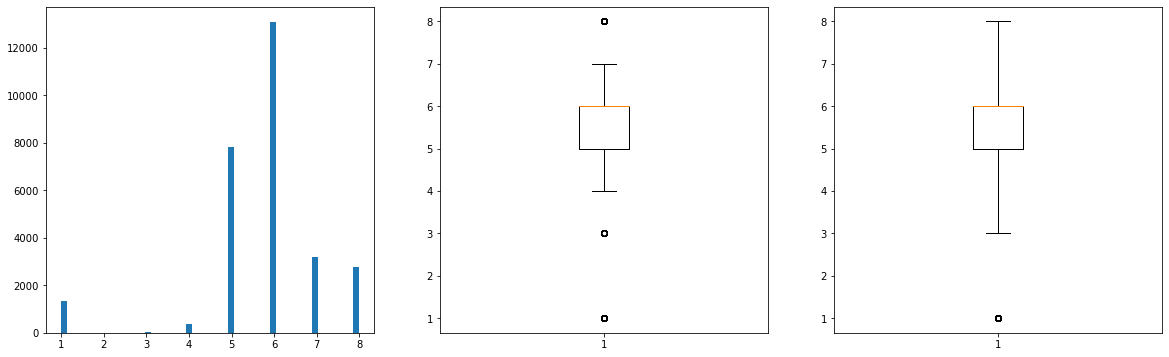

In [314]:
plt.figure(figsize=(20, 6))

plt.subplot(131)
plt.hist(df.gears, bins=50)

plt.subplot(132)
plt.boxplot(df.gears, whis=1.5)

plt.subplot(133)
plt.boxplot(df.gears, whis=2.5)

plt.show()

## empty_weight

In [315]:
first_looking("empty_weight")

COLUMN NAME    :  empty_weight
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  1218
--------------------------------
1320.0    724
1280.0    518
1055.0    473
1395.0    461
1165.0    392
         ... 
944.0       1
1019.0      1
2156.0      1
2232.0      1
1391.0      1
Name: empty_weight, Length: 1218, dtype: int64


In [316]:
df["empty_weight"].describe()

count    28614.000000
mean      1419.351366
std        324.967341
min         75.000000
25%       1214.000000
50%       1371.000000
75%       1595.000000
max      15590.000000
Name: empty_weight, dtype: float64

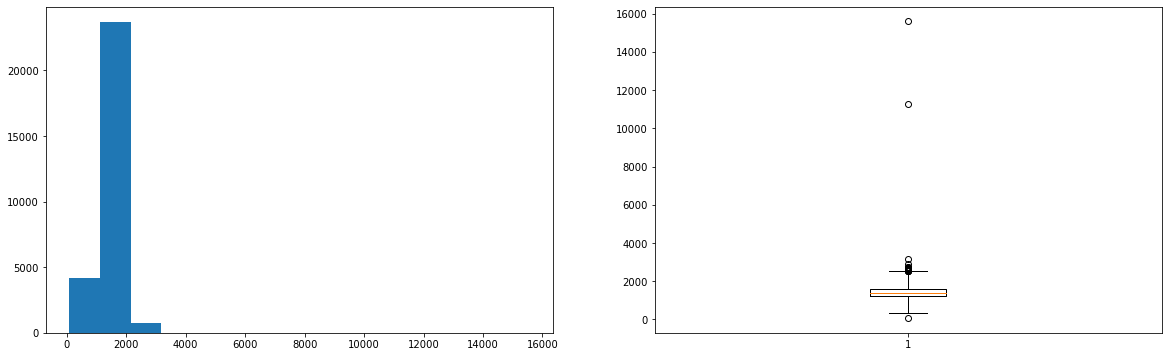

In [317]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["empty_weight"], bins=15)

plt.subplot(122)
plt.boxplot(df["empty_weight"], whis=2.5)

plt.show()

In [318]:
df.sort_values(by=["empty_weight"], ascending=False)["empty_weight"].head(20)

# df["empty_weight"].sort_values(ascending=False).head(20)

6869     15590.0
21142    11246.0
1295      3150.0
20037     2900.0
5414      2750.0
17891     2725.0
2371      2712.0
1199      2690.0
2199      2680.0
1628      2680.0
2156      2655.0
17907     2650.0
1449      2612.0
1259      2610.0
1481      2610.0
1357      2610.0
1344      2610.0
1333      2610.0
1421      2610.0
1270      2595.0
Name: empty_weight, dtype: float64

In [319]:
# df.sort_values(by=["empty_weight"], ascending=True)["empty_weight"].head(20)

df["empty_weight"].sort_values(ascending=True).head(20)

13995     75.0
6166     347.0
6205     375.0
4838     473.0
4943     473.0
5430     473.0
4886     473.0
5786     474.0
4188     525.0
5140     562.0
5816     562.0
5919     562.0
5748     562.0
5936     562.0
9628     600.0
9632     600.0
12208    600.0
10626    600.0
5594     650.0
11827    670.0
Name: empty_weight, dtype: float64

**Let us examine empty_weights of vehicles more than 3150 kg:**

In [320]:
df.loc[df["empty_weight"] > 3150][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight
6869,Renault ZOE,3.0,Sedan,Automatic,Front,1.0,0.0,Electric,15590.0
21142,Ford Fiesta,1.0,Compact,Manual,Front,6.0,999.0,Benzine,11246.0


In [321]:
# df.loc[df.make_model == "Mercedes-Benz G 500"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
df.loc[df.make_model == "Renault ZOE"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Ford Fiesta"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight
4810,Renault ZOE,1.0,Compact,Automatic,Front,1.0,1.0,Electric,1577.0
4819,Renault ZOE,0.0,Compact,Automatic,Front,1.0,1.0,Electric,1577.0
4823,Renault ZOE,4.0,Compact,Automatic,Front,1.0,1.0,Electric,1428.0
4826,Renault ZOE,0.0,Compact,Automatic,Front,1.0,1.0,Electric,1577.0
4840,Renault ZOE,4.0,Compact,Automatic,Front,1.0,1.0,Electric,1428.0
...,...,...,...,...,...,...,...,...,...
7113,Renault ZOE,5.0,Sedan,Automatic,Front,1.0,0.0,Electric,1577.0
7114,Renault ZOE,5.0,Sedan,Automatic,Front,1.0,0.0,Electric,1577.0
7116,Renault ZOE,3.0,Sedan,Automatic,Front,1.0,0.0,Electric,1577.0
7124,Renault ZOE,6.0,Sedan,Automatic,Front,1.0,0.0,Electric,1577.0


### 📝 Domain Knowledge About Empty/Curb Weights of Some Vehicles on the List Above:
**🧐 [List of Car Weights](https://qureshiuniversity.com/listofcarweights.html)**, **[Average car weight](https://www.bankrate.com/insurance/car/average-car-weight/)**

Vehicle weight can vary significantly by the model and even the year of the car or truck, so your own vehicle's manual or driver's side doorsill is your best resource for finding out its weight. However, many people wonder how their vehicle compares to others in its class.

Below, you'll find a chart depicting the average weight for various classes of vehicles, according to USA Today:

## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#060108; font-size:75%; text-align:center; border-radius:10px 10px;">Average Curb Weights by Vehicle Class</p>
<img src=https://i.ibb.co/CwTxpyJ/avg-car-weights.png width="400" height="100">


- **[Renault ZOE](https://en.wikipedia.org/wiki/Renault_Zoe)'s Curb weight (Excluding Driver)** is around **1,468 kg (3,236 lbs)**
- **[2018 Ford Fiesta SE 4dr Hatchback](https://www.autoblog.com/buy/2018-Ford-Fiesta-SE__4dr_Hatchback/specs/)'s Curb weight** is around **1,151 kg (2,537.0 lbs).**
- **[Skoda Enyaq iV 60 62 kWh (180 Hp)](https://www.auto-data.net/en/skoda-enyaq-iv-60-62-kwh-180hp-42038)'s Curb weight** is around **1,890 kg (4,166.74 lbs).**
- **[Renault Twizy](https://en.wikipedia.org/wiki/Renault_Twizy)'s Curb weight** is around **450 kg (992.00 lbs).**
- **[Fiat 126](https://en.wikipedia.org/wiki/Fiat_126)'s Curb weight** is around **580–619 kg (1,279–1,365 lbs).**
- **[SEAT Marbella](https://en.wikipedia.org/wiki/SEAT_Marbella)'s Curb weight** is around **620 kg (1367.00 lbs).**
- **[Nissan Figaro](https://en.wikipedia.org/wiki/Nissan_Figaro)'s Curb weight** is around **810 kg (1,790 lbs).**
- **[Opel Astra H 1.6 16v](https://www.ultimatespecs.com/car-specs/Opel/1131/Opel-Astra-H-16-16v.html)'s Curb weight** is around **1,265 kg (2,789 lbs).**

**Let us examine empty_weights of vehicles less than 1000 kg:**

In [322]:
df.loc[df["empty_weight"] < 1000][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]\
                                 .sort_values(by=["empty_weight"], ascending=True)

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight
13995,Skoda Enyaq,0.0,Off-Road/Pick-up,Automatic,4WD,1.0,0.0,Electric,75.0
6166,Renault Twizy,10.0,Off-Road/Pick-up,Automatic,Rear,1.0,1598.0,Electric,347.0
6205,Renault Twizy,6.0,Off-Road/Pick-up,Automatic,Rear,1.0,1598.0,Electric,375.0
5430,Renault Twizy,5.0,Convertible,Automatic,Front,1.0,1598.0,Electric,473.0
4838,Renault Twizy,10.0,Compact,Automatic,Rear,1.0,1598.0,Electric,473.0
...,...,...,...,...,...,...,...,...,...
5175,Renault Twingo,4.0,Compact,Automatic,Rear,6.0,999.0,Benzine,996.0
24857,Hyundai i10,0.0,Sedan,Manual,Front,5.0,998.0,Benzine,996.0
20965,Ford Fiesta,15.0,Compact,Manual,Front,5.0,1596.0,Benzine,998.0
7131,Renault Twingo,4.0,Sedan,Manual,Front,5.0,999.0,Benzine,998.0


In [323]:
# df.loc[df.make_model == "Skoda Enyaq"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Renault Twizy"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Opel Astra"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Hyundai i10"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Toyota MR 2"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Renault Twingo"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Peugeot 108"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Peugeot 107"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Toyota Aygo"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Toyota Starlet"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Renault Spider"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "SEAT Ibiza"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "Nissan Figaro"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
df.loc[df.make_model == "Fiat Panda"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]
# df.loc[df.make_model == "SEAT Marbella"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight
9517,Fiat Panda,6.0,Compact,Manual,4WD,5.0,1248.0,Diesel,1115.0
9529,Fiat Panda,6.0,Compact,Manual,4WD,5.0,1248.0,Diesel,1115.0
9535,Fiat Panda,6.0,Compact,Manual,4WD,5.0,1248.0,Diesel,1115.0
9551,Fiat Panda,6.0,Compact,Manual,4WD,5.0,1248.0,Diesel,1115.0
9555,Fiat Panda,16.0,Compact,Manual,Front,5.0,1251.0,Diesel,935.0
...,...,...,...,...,...,...,...,...,...
11804,Fiat Panda,11.0,Sedan,Manual,Front,5.0,1242.0,Benzine,935.0
11811,Fiat Panda,10.0,Sedan,Manual,Front,5.0,1242.0,Benzine,935.0
11817,Fiat Panda,5.0,Sedan,Manual,Front,5.0,875.0,Liquid/Natural Gas,1055.0
11821,Fiat Panda,1.0,Sedan,Manual,4WD,6.0,1248.0,Benzine,1055.0


In [324]:
df.loc[(df["empty_weight"] > 4000), 'empty_weight'] = np.nan

df["empty_weight"].replace([75, 525], np.nan, inplace=True)

In [325]:
df["empty_weight"].isnull().sum()

4

In [326]:
fill(df, "make_model", "body_type", "empty_weight", "mode")

COLUMN NAME    :  empty_weight
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  1214
--------------------------------
1320.0    724
1280.0    518
1055.0    473
1395.0    461
1165.0    392
         ... 
1699.0      1
1817.0      1
1839.0      1
1452.0      1
1391.0      1
Name: empty_weight, Length: 1214, dtype: int64


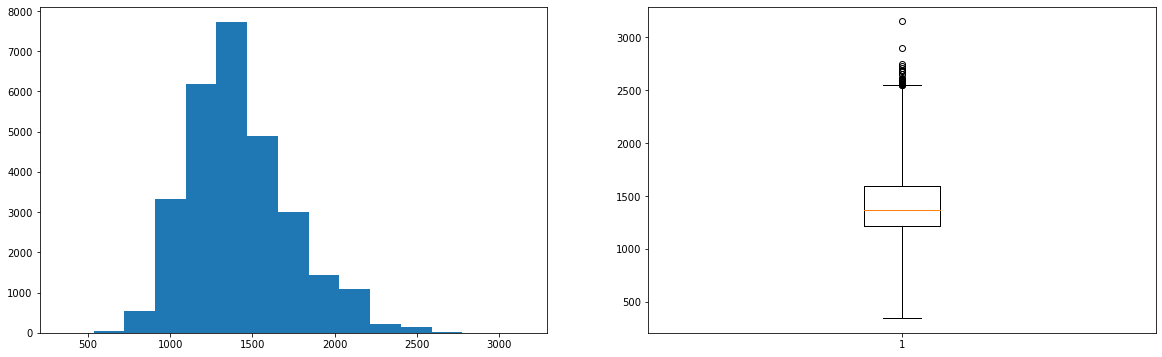

In [327]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["empty_weight"], bins=15)

plt.subplot(122)
plt.boxplot(df["empty_weight"], whis=2.5)

plt.show()

## co_emissions

**🧐 [CO₂ emission performance standards for cars and VANs](https://climate.ec.europa.eu/eu-action/transport-emissions/road-transport-reducing-co2-emissions-vehicles/co2-emission-performance-standards-cars-and-vans_en#:~:text=In%20the%20years%20from%202020,as%201.67%20vehicles%20in%202021):**

Passenger cars and vans ('light commercial vehicles') are respectively responsible for around 12% and 2.5% of total EU emissions of carbon dioxide (CO2), which is the main greenhouse gas...On 1 January 2020, [Regulation (EU) 2019/631](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX%3A02019R0631-20210301) entered into force, setting CO2 emission performance standards for new passenger cars and vans. 

**Targets (2020-2024):**<br>
For the period 2020-2024, Regulation (EU) 2019/631 confirms the EU fleet-wide CO2 emission targets set under Regulations (EC) No 443/2009 and (EU) No 510/2011.
- Cars: 95 g CO2/km
- Vans: 147 g CO2/km

**🧐 [What is low CO2 emission?](https://www.cazoo.co.uk/the-view/buying/what-are-co2-emissions/)**<br>
What is considered a **'good' CO2 emission level** for a car? Anything **less than 100g/km** can be considered low – or good – CO2 emissions.

**🧐 [What sort of cars produce the least CO2?](https://www.cazoo.co.uk/the-view/buying/what-are-co2-emissions/)**<br>
- **Diesel cars** produce **a lot less CO2** than petrol cars. That’s because diesel fuel has a different chemical makeup to petrol, and diesel engines burn their fuel more efficiently.
- **Conventional hybrid cars** (also known as self-charging hybrids) generally produce **very little CO2** because they have the capability to run on electric power some of the time. Plug-in hybrids have very low CO2 emissions because they have a much longer electric-only range. 
- **Electric cars** produce **NO carbon emissions**, which is why they’re sometimes referred to as ‘zero-emissions’ vehicles.

**🧐 [WHICH CARS ARE THE WORST OFFENDERS WHEN IT COMES TO CARBON EMISSIONS?](https://www.coastcaptureair.com/blog/worst-cars-for-carbon-emissions)**

**🧐 [Best Low Emission Cars 2022](https://www.moneyshake.com/car-finance-guides/electric-and-hybrid-guides/best-low-emission-cars-2022)**

**🧐 [Hot air: the worst cars for real-world CO2 emissions](https://www.motoringresearch.com/car-news/hot-air-worst-cars-for-real-world-co2-emissions/)**

In [328]:
first_looking("co_emissions")

COLUMN NAME    :  co_emissions
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  389
--------------------------------
0.00      1410
124.00    1074
115.00     681
99.00      587
119.00     574
          ... 
95.50        1
146.75       1
338.00       1
123.50       1
53.00        1
Name: co_emissions, Length: 389, dtype: int64


In [329]:
df["co_emissions"].describe()

count    28614.000000
mean       132.007557
std         56.986565
min          0.000000
25%        107.000000
50%        124.000000
75%        155.000000
max        940.000000
Name: co_emissions, dtype: float64

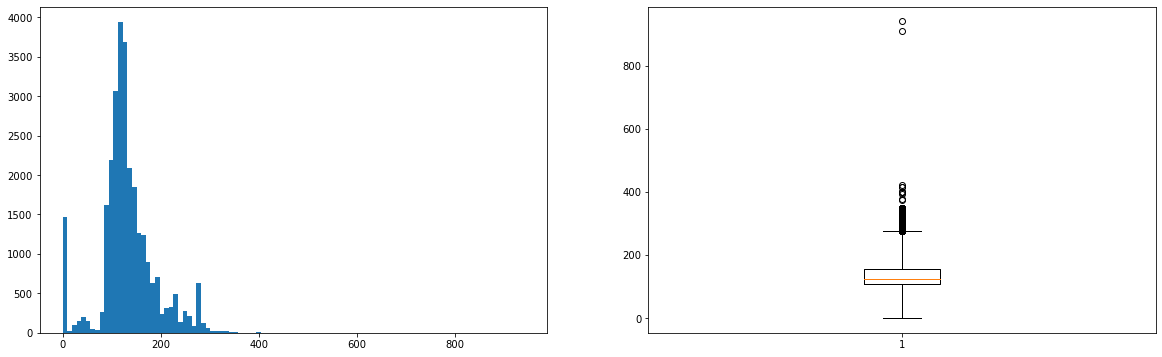

In [330]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["co_emissions"], bins=100)

plt.subplot(122)
plt.boxplot(df["co_emissions"], whis=2.5)

plt.show()

In [331]:
df.sort_values(by=["co_emissions"], ascending=False)["co_emissions"].head(20)

# df["co_emissions"].sort_values(ascending=False).head(20)

22010    940.0
20797    910.0
21923    420.0
27509    414.0
27896    414.0
613      400.0
610      400.0
21541    399.0
19523    398.0
21569    394.0
1299     377.0
1502     373.0
21778    350.0
21921    350.0
21793    350.0
21606    350.0
21553    350.0
21645    350.0
21644    350.0
1542     348.0
Name: co_emissions, dtype: float64

In [332]:
df.sort_values(by=["co_emissions"], ascending=True)["co_emissions"].head(20)

# df["co_emissions"].sort_values(ascending=False).head(20)

11517    0.0
15104    0.0
2520     0.0
15105    0.0
15132    0.0
15141    0.0
15143    0.0
2514     0.0
2512     0.0
15144    0.0
2509     0.0
15145    0.0
15146    0.0
15147    0.0
15148    0.0
15149    0.0
15150    0.0
15151    0.0
15152    0.0
15153    0.0
Name: co_emissions, dtype: float64

In [333]:
df.groupby(["make_model", "body_type", "fuel_type", "co_emissions"]).price.describe()

count          mean  \
make_model   body_type        fuel_type co_emissions                        
Dacia        Compact          Benzine   130.0           3.0  21431.000000   
             Sedan            Benzine   130.0           1.0   9999.000000   
             Station wagon    Benzine   130.0           1.0  21799.000000   
Dacia Break  Station wagon    Benzine   124.0           1.0  20500.000000   
Dacia Dokker Compact          Diesel    108.0           1.0  11930.000000   
...                                                     ...           ...   
Volvo XC90   Off-Road/Pick-up Diesel    224.0           2.0  11850.000000   
                              Electric  0.0             4.0  64400.000000   
             Sedan            Diesel    47.0            3.0  60366.666667   
             Station wagon    Diesel    149.0           2.0  29500.000000   
                                        152.0           2.0  36000.000000   

                                                               std      min  \
make_model   body_type        fuel_type co_emissions                          
Dacia        Compact          Benzine   130.0          1661.743663  19515.0   
             Sedan            Benzine   130.0                  NaN   9999.0   
             Station wagon    Benzine   130.0                  NaN  21799.0   
Dacia Break  Station wagon    Benzine   124.0                  NaN  20500.0   
Dacia Dokker Compact          Diesel    108.0                  NaN  11930.0   
...                                                            ...      ...   
Volvo XC90   Off-Road/Pick-up Diesel    224.0             0.000000  11850.0   
                              Electric  0.0            9814.954576  55900.0   
             Sedan            Diesel    47.0          21250.254900  47700.0   
             Station wagon    Diesel    149.0             0.000000  29500.0   
                                        152.0             0.000000  36000.0   

                                                          25%      50%  \
make_model   body_type        fuel_type co_emissions                     
Dacia        Compact          Benzine   130.0         20907.0  22299.0   
             Sedan            Benzine   130.0          9999.0   9999.0   
             Station wagon    Benzine   130.0         21799.0  21799.0   
Dacia Break  Station wagon    Benzine   124.0         20500.0  20500.0   
Dacia Dokker Compact          Diesel    108.0         11930.0  11930.0   
...                                                       ...      ...   
Volvo XC90   Off-Road/Pick-up Diesel    224.0         11850.0  11850.0   
                              Electric  0.0           55900.0  64400.0   
             Sedan            Diesel    47.0          48100.0  48500.0   
             Station wagon    Diesel    149.0         29500.0  29500.0   
                                        152.0         36000.0  36000.0   

                                                          75%      max  
make_model   body_type        fuel_type co_emissions                    
Dacia        Compact          Benzine   130.0         22389.0  22479.0  
             Sedan            Benzine   130.0          9999.0   9999.0  
             Station wagon    Benzine   130.0         21799.0  21799.0  
Dacia Break  Station wagon    Benzine   124.0         20500.0  20500.0  
Dacia Dokker Compact          Diesel    108.0         11930.0  11930.0  
...                                                       ...      ...  
Volvo XC90   Off-Road/Pick-up Diesel    224.0         11850.0  11850.0  
                              Electric  0.0           72900.0  72900.0  
             Sedan            Diesel    47.0          66700.0  84900.0  
             Station wagon    Diesel    149.0         29500.0  29500.0  
                                        152.0         36000.0  36000.0  

[7638 rows x 8 columns]

In [334]:
df.loc[df["co_emissions"] > 300][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]\
                                 .sort_values(by=["co_emissions"], ascending=False)

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight,co_emissions
22010,Ford Edge,2.0,Off-Road/Pick-up,Automatic,4WD,8.0,1995.0,Diesel,2116.0,940.0
20797,Ford Fiesta,1.0,Compact,Manual,Front,6.0,1496.0,Benzine,1242.0,910.0
21923,Ford Mustang,1.0,Coupe,Automatic,Rear,6.0,4949.0,Benzine,1725.0,420.0
27896,Volvo V60,5.0,Station wagon,Manual,Front,6.0,1969.0,Diesel,1690.0,414.0
27509,Volvo V60,5.0,Station wagon,Manual,Front,6.0,1969.0,Diesel,1690.0,414.0
...,...,...,...,...,...,...,...,...,...,...
704,Mercedes-Benz SL 500,20.0,Convertible,Automatic,Rear,5.0,4966.0,Benzine,1770.0,304.0
21171,Ford Mustang,5.0,Convertible,Manual,Rear,6.0,4951.0,Benzine,1830.0,303.0
21519,Ford Mustang,6.0,Convertible,Manual,Rear,6.0,4951.0,Benzine,1830.0,303.0
21173,Ford Mustang,5.0,Convertible,Automatic,Rear,6.0,4951.0,Benzine,1893.0,303.0


In [335]:
# df.loc[df.make_model == "Ford Edge"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]
# df.loc[df.make_model == "Ford Fiesta"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]
# df.loc[df.make_model == "Ford Mustang"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]
# df.loc[df.make_model == "Volvo V60"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]
# df.loc[df.make_model == "Mercedes-Benz G 500"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]
# df.loc[df.make_model == "Nissan GT-R"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]
# df.loc[df.make_model == "Mercedes-Benz E 63 AMG"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]
# df.loc[df.make_model == "Ford GT"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]
# df.loc[df.make_model == "Toyota Land Cruiser"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]
df.loc[df.make_model == "Mercedes-Benz SL 600"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight,co_emissions
604,Mercedes-Benz SL 600,14.0,Convertible,Automatic,Rear,5.0,5513.0,Benzine,1950.0,330.0
684,Mercedes-Benz SL 600,28.0,Convertible,Automatic,Rear,4.0,5987.0,Benzine,1950.0,330.0
720,Mercedes-Benz SL 600,26.0,Convertible,Automatic,Rear,5.0,5987.0,Benzine,1950.0,330.0
721,Mercedes-Benz SL 600,12.0,Convertible,Automatic,Rear,5.0,5513.0,Benzine,2045.0,326.0
753,Mercedes-Benz SL 600,14.0,Convertible,Automatic,Rear,5.0,5513.0,Benzine,1945.0,330.0


### 📝 Domain Knowledge About Average ``co2 emission values`` of some Vehicles:

- ``Ford Edge``'s co2 emission value is **153 g/km**
- ``Ford Fiesta``'s co2 emission value is **108 g/km**
- ``Ford Mustang``'s co2 emission value is **299 g/km**
- ``Volvo V60``'s co2 emission value is **146 g/km**
- ``Mercedes-Benz G 500``'s co2 emission value is **252-299 g/km**
- ``Nissan GT-R``'s co2 emission value is **275 g/km**
- ``Mercedes-Benz E 63 AMG``'s co2 emission value is **230 g/km**
- ``Ford GT``'s co2 emission value is **349.6 g/km**
- ``Toyota Land Cruiser``'s co2 emission value is **262.0 g/km**
- ``Mercedes-Benz SL 55 AMG``'s co2 emission value is **324 g/km**
- ``Mercedes-Benz SL 600``'s co2 emission value is **326-370 g/km**

**To get more information in detail about Average Car Emission of each maake and model, you can visit 🧐 [car-emissions.com](https://www.car-emissions.com/) and 🧐 [cars-data.com](https://www.cars-data.com/search_results.html?q=emissions)**

In [336]:
df[(~(df["make_model"] == "Ford GT") | ~(df["make_model"].str.contains("Mercedes-Benz"))) & (df["co_emissions"] > 330)][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]\
                                 .sort_values(by=["co_emissions"], ascending=False)

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight,co_emissions
22010,Ford Edge,2.0,Off-Road/Pick-up,Automatic,4WD,8.0,1995.0,Diesel,2116.0,940.0
20797,Ford Fiesta,1.0,Compact,Manual,Front,6.0,1496.0,Benzine,1242.0,910.0
21923,Ford Mustang,1.0,Coupe,Automatic,Rear,6.0,4949.0,Benzine,1725.0,420.0
27896,Volvo V60,5.0,Station wagon,Manual,Front,6.0,1969.0,Diesel,1690.0,414.0
27509,Volvo V60,5.0,Station wagon,Manual,Front,6.0,1969.0,Diesel,1690.0,414.0
610,Mercedes-Benz G 500,23.0,Convertible,Automatic,4WD,7.0,4996.0,Benzine,2350.0,400.0
613,Mercedes-Benz G 500,23.0,Convertible,Automatic,4WD,7.0,4996.0,Benzine,2350.0,400.0
21541,Ford Mustang,1.0,Coupe,Automatic,Rear,6.0,5162.0,Benzine,1992.0,399.0
19523,Nissan GT-R,12.0,Coupe,Automatic,4WD,6.0,3799.0,Benzine,1740.0,398.0
21569,Ford Mustang,0.0,Coupe,Automatic,Rear,6.0,5162.0,Benzine,1950.0,394.0


In [337]:
cond_emission = (~(df["make_model"] == "Ford GT") | ~(df["make_model"].str.contains("Mercedes-Benz"))) & (df["co_emissions"] > 400)
df[cond_emission][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight,co_emissions
20797,Ford Fiesta,1.0,Compact,Manual,Front,6.0,1496.0,Benzine,1242.0,910.0
21923,Ford Mustang,1.0,Coupe,Automatic,Rear,6.0,4949.0,Benzine,1725.0,420.0
22010,Ford Edge,2.0,Off-Road/Pick-up,Automatic,4WD,8.0,1995.0,Diesel,2116.0,940.0
27509,Volvo V60,5.0,Station wagon,Manual,Front,6.0,1969.0,Diesel,1690.0,414.0
27896,Volvo V60,5.0,Station wagon,Manual,Front,6.0,1969.0,Diesel,1690.0,414.0


In [338]:
outlier_emission = df["co_emissions"].isin([940, 910, 420, 414])

df.loc[outlier_emission, "co_emissions"] = np.nan

# df["engine_size"].replace([940, 910, 420, 414], np.nan, inplace=True)
# df.loc[cond_emission, "co_emissions"] = np.nan

In [339]:
df["co_emissions"].isnull().sum()

5

In [340]:
fill(df, "make_model", "body_type", "co_emissions", "median")

COLUMN NAME    :  co_emissions
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  385
--------------------------------
0.0      1410
124.0    1074
115.0     681
99.0      587
119.0     574
         ... 
197.5       1
266.0       1
118.5       1
37.5        1
53.0        1
Name: co_emissions, Length: 385, dtype: int64


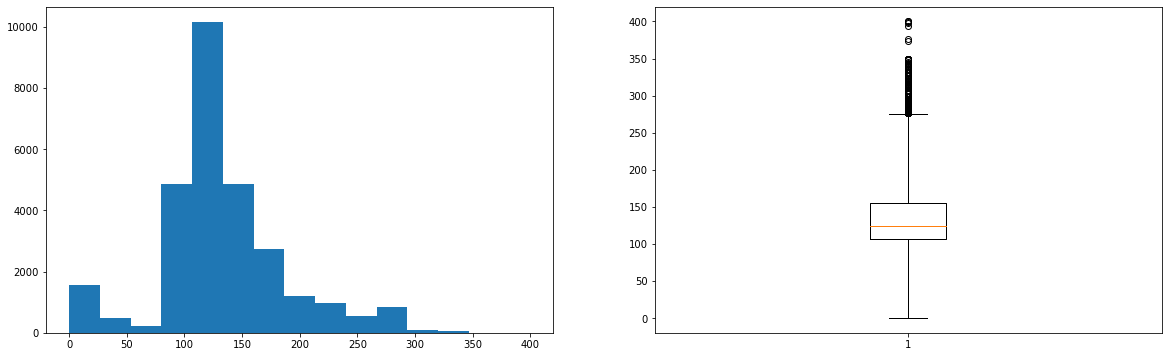

In [341]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["co_emissions"], bins=15)

plt.subplot(122)
plt.boxplot(df["co_emissions"], whis=2.5)

plt.show()

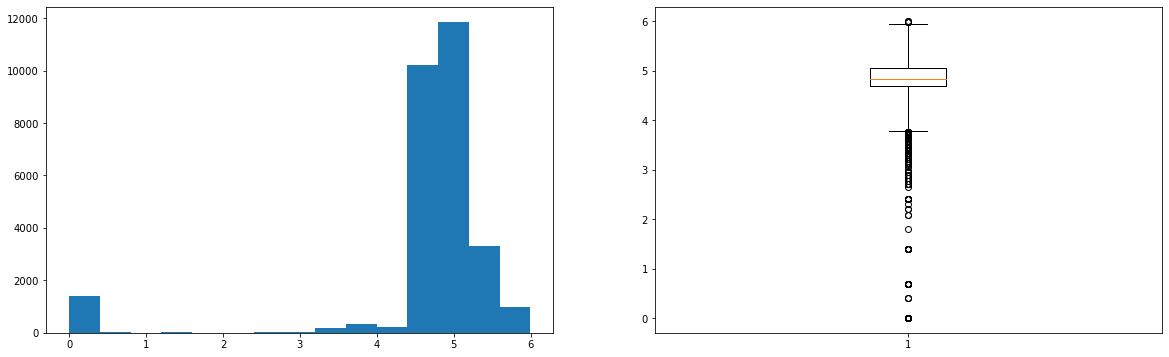

In [342]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
# df["co_emissions"].map(np.log).hist(bins=15)
# plt.hist(np.log(df["co_emissions"]), bins=15)  # This code (np.log) does NOT work due to the values 0
                                                 # -inf is what you get from computing np.log(0.)
plt.hist(np.log1p(df['co_emissions']), bins=15)

plt.subplot(122)
# df["co_emissions"].map(np.log).boxplot(whis=2.5)
plt.boxplot(np.log1p(df["co_emissions"]), whis=2.5)  

plt.show()

# ValueError: supplied range of [-inf, 6.84587987526405] is not finite

# Make sure the data does not have;

# Null/None
# ""/empty string
# Too many zeros (0)
# float('inf') or float('-inf')

# https://stackoverflow.com/questions/66055838/my-data-has-no-nan-but-i-keep-getting-the-finite-error

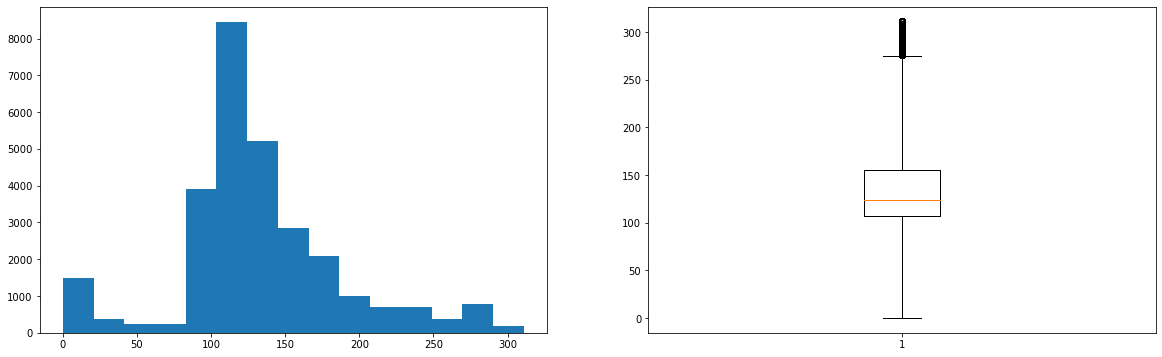

In [343]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(winsorize(df["co_emissions"], (0.001, 0.003)), bins = 15)

plt.subplot(122)
plt.boxplot(winsorize(df["co_emissions"], (0.001, 0.003)), whis=2.5)

plt.show()

## cons_avg

Simply put, the average fuel consumption of your car is a calculation of how many kilometres you were able to travel for every litre of fuel used, be it diesel or petrol. Some vehicles will help you out by calculating your averages and sometimes even give you an instantaneous reading of how much fuel you are using. 

Fuel consumption is most commonly quoted as litres per 100 kilometres condensed to read as "l/100km". A more tradition way of measuring it is kilometres per litre expressed in "km/l".

Both of these give a similar indication of the amount of fuel used and l/100km is more common because the lower the number, the better the fuel consumption of the vehicle - remember, using less fuel is better!

The longer you drive, the more information the car has to be able to work out your average fuel consumption. Steady driving uses less fuel than stop-start driving and the amount of time or kilometres you spent in these situations is reflected in your average fuel consumption. Driving erratically, accelerating hard and stopping suddenly all negatively affect your fuel consumption.

If you travelled 10 kilometres and used 1 litre of fuel, your car has an average fuel consumption of 10 km/l or 10 l/100km. Similarly, if you travelled 10 km and used 2 litres of fuel, your car did 5 km/l. 10 ÷ 2 = 5. This is equal to 20 l/100km when converted. 10 is the magic number and the crossover point for the conversion between km/l and l/100km.

**🧐 [What is Fuel consumption (average)? How is it calculated?](https://www.autotrader.co.za/cars/news-and-advice/automotive-news/what-is-fuel-consumption-(average)-how-is-it-calculated/9831)**

**🧐 [10 Cars with the Worst Fuel Economy](https://www.caranddriver.com/features/g30256394/worst-fuel-economy-cars/)**

**🧐 [The 15 Cars With the Worst Fuel Economy on Sale Today](https://www.motortrend.com/features/cars-worst-fuel-economy-list/)**

**🧐 [The 5 most fuel-efficient cars on the road today](https://www.businessinsider.com/most-fuel-efficient-cars-vehicles-best-gas-mileage-2019-11)**

**🧐 [2023 Best and Worst Fuel Economy Vehicles](https://www.fueleconomy.gov/feg/best-worst.shtml)**

**🧐 [The most fuel efficient vehicles](https://www.spritmonitor.de/en/evaluation/economic_models.html)**

In [344]:
first_looking("cons_avg")

COLUMN NAME    :  cons_avg
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  216
--------------------------------
4.90     1043
5.00      966
4.50      889
5.10      886
5.30      885
         ... 
6.85        1
15.90       1
3.15        1
44.00       1
6.20        1
Name: cons_avg, Length: 216, dtype: int64


In [345]:
df.cons_avg.describe()

count    28614.000000
mean         5.704134
std          2.793233
min          0.000000
25%          4.400000
50%          5.300000
75%          6.600000
max         99.900000
Name: cons_avg, dtype: float64

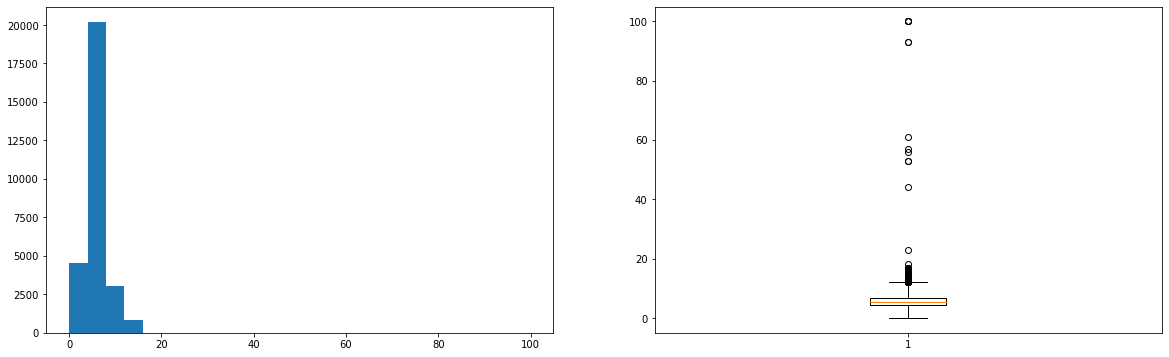

In [346]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(df.cons_avg, bins = 25)

plt.subplot(122)
plt.boxplot(df.cons_avg, whis=2.5)

plt.show()

In [347]:
df.sort_values(by=["cons_avg"], ascending=False)["cons_avg"].head(20)

# df["cons_avg"].sort_values(ascending=False).head(20)

265      99.9
18798    99.9
18799    99.9
23004    99.9
21012    93.0
20995    93.0
1771     61.0
6580     57.0
18546    56.0
23974    53.0
24144    53.0
19904    44.0
21345    23.0
21531    18.3
21569    16.8
610      16.7
613      16.7
10406    16.7
1214     16.5
1253     16.5
Name: cons_avg, dtype: float64

In [348]:
df.sort_values(by=["cons_avg"], ascending=True)["cons_avg"].head(20)

# df["cons_avg"].sort_values(ascending=True).head(20)
# df.cons_avg.sort_values().tail(20)

10626    0.0
7317     0.0
21759    0.0
21711    0.0
21670    0.0
4728     0.0
21642    0.0
21626    0.0
21620    0.0
11434    0.0
21469    0.0
20012    0.0
21421    0.0
23104    0.0
650      0.0
21414    0.0
11428    0.0
19986    0.0
21385    0.0
5753     0.0
Name: cons_avg, dtype: float64

In [349]:
df.groupby(["make_model", "body_type", "fuel_type", "cons_avg"]).mileage.describe()

count           mean  \
make_model   body_type        fuel_type cons_avg                         
Dacia        Compact          Benzine   5.600       3.0     865.333333   
             Sedan            Benzine   5.600       1.0   59098.000000   
             Station wagon    Benzine   5.600       1.0    2000.000000   
Dacia Break  Station wagon    Benzine   5.300       1.0     999.000000   
Dacia Dokker Compact          Diesel    4.200       1.0  141100.000000   
...                                                 ...            ...   
Volvo XC90   Off-Road/Pick-up Diesel    9.100       2.0  237102.000000   
                              Electric  2.359       4.0   40399.500000   
             Sedan            Diesel    6.700       3.0   58761.333333   
             Station wagon    Diesel    5.700       2.0  150000.000000   
                                        5.800       2.0  143550.000000   

                                                           std       min  \
make_model   body_type        fuel_type cons_avg                           
Dacia        Compact          Benzine   5.600      1308.275710     110.0   
             Sedan            Benzine   5.600              NaN   59098.0   
             Station wagon    Benzine   5.600              NaN    2000.0   
Dacia Break  Station wagon    Benzine   5.300              NaN     999.0   
Dacia Dokker Compact          Diesel    4.200              NaN  141100.0   
...                                                        ...       ...   
Volvo XC90   Off-Road/Pick-up Diesel    9.100         0.000000  237102.0   
                              Electric  2.359     32215.567671   12500.0   
             Sedan            Diesel    6.700     34192.796176   20635.0   
             Station wagon    Diesel    5.700         0.000000  150000.0   
                                        5.800         0.000000  143550.0   

                                                       25%       50%  \
make_model   body_type        fuel_type cons_avg                       
Dacia        Compact          Benzine   5.600        110.0     110.0   
             Sedan            Benzine   5.600      59098.0   59098.0   
             Station wagon    Benzine   5.600       2000.0    2000.0   
Dacia Break  Station wagon    Benzine   5.300        999.0     999.0   
Dacia Dokker Compact          Diesel    4.200     141100.0  141100.0   
...                                                    ...       ...   
Volvo XC90   Off-Road/Pick-up Diesel    9.100     237102.0  237102.0   
                              Electric  2.359      12500.0   40399.5   
             Sedan            Diesel    6.700      44787.5   68940.0   
             Station wagon    Diesel    5.700     150000.0  150000.0   
                                        5.800     143550.0  143550.0   

                                                       75%       max  
make_model   body_type        fuel_type cons_avg                      
Dacia        Compact          Benzine   5.600       1243.0    2376.0  
             Sedan            Benzine   5.600      59098.0   59098.0  
             Station wagon    Benzine   5.600       2000.0    2000.0  
Dacia Break  Station wagon    Benzine   5.300        999.0     999.0  
Dacia Dokker Compact          Diesel    4.200     141100.0  141100.0  
...                                                    ...       ...  
Volvo XC90   Off-Road/Pick-up Diesel    9.100     237102.0  237102.0  
                              Electric  2.359      68299.0   68299.0  
             Sedan            Diesel    6.700      77824.5   86709.0  
             Station wagon    Diesel    5.700     150000.0  150000.0  
                                        5.800     143550.0  143550.0  

[6836 rows x 8 columns]

In [350]:
df.loc[df["cons_avg"] >= 10][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]\
                                 .sort_values(by=["cons_avg"], ascending=False)

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight,co_emissions,cons_avg
18799,Nissan Qashqai,5.0,Compact,Manual,Front,6.0,1197.0,Benzine,1250.0,129.0,99.9
265,Mercedes-Benz A 180,2.0,Compact,Automatic,Front,7.0,1332.0,Benzine,1265.0,138.0,99.9
18798,Nissan Qashqai,3.0,Compact,Manual,Front,6.0,1332.0,Benzine,1275.0,121.0,99.9
23004,Ford Focus,3.0,Sedan,Automatic,Front,8.0,1499.0,Diesel,1280.0,112.0,99.9
20995,Ford Focus,4.0,Compact,Manual,Front,6.0,1499.0,Diesel,1263.0,93.0,93.0
...,...,...,...,...,...,...,...,...,...,...,...
22039,Ford Bronco,1.0,Off-Road/Pick-up,Automatic,4WD,8.0,1998.0,Benzine,2146.0,238.0,10.0
26221,Volvo C70,20.0,Convertible,Automatic,Front,5.0,2435.0,Benzine,1597.0,263.0,10.0
26569,Volvo C70,24.0,Coupe,Manual,Front,5.0,2319.0,Benzine,1459.0,250.0,10.0
26568,Volvo C70,24.0,Coupe,Manual,Front,5.0,2319.0,Benzine,1459.0,250.0,10.0


In [351]:
df.loc[df.make_model == "Mercedes-Benz A 180"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Nissan Qashqai"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Ford Focus"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Mercedes-Benz E 200"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Renault Megane"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Toyota Yaris"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Hyundai KONA"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Mercedes-Benz GLC 63 AMG"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Ford Mustang"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Nissan GT-R"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Nissan Skyline"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Nissan 370Z"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Peugeot 205"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Volvo C70"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Renault Alpine A310"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Hyundai Genesis"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Fiat Coupe"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]
# df.loc[df.make_model == "Ford Thunderbird"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight,co_emissions,cons_avg
13,Mercedes-Benz A 180,2.0,Compact,Manual,Front,6.0,1461.0,Diesel,1330.0,120.0,4.5
15,Mercedes-Benz A 180,12.0,Compact,Manual,Front,6.0,1991.0,Diesel,1295.0,138.0,5.2
18,Mercedes-Benz A 180,2.0,Compact,Automatic,Front,7.0,1461.0,Diesel,1445.0,99.5,3.9
20,Mercedes-Benz A 180,4.0,Compact,Automatic,Front,7.0,1461.0,Diesel,1425.0,99.5,3.7
21,Mercedes-Benz A 180,2.0,Compact,Automatic,Front,7.0,1461.0,Diesel,1455.0,99.5,3.9
...,...,...,...,...,...,...,...,...,...,...,...
2171,Mercedes-Benz A 180,2.0,Sedan,Automatic,Front,7.0,1332.0,Benzine,1380.0,128.0,5.3
2375,Mercedes-Benz A 180,2.0,Sedan,Automatic,Front,6.0,1461.0,Diesel,1460.0,101.0,3.8
2378,Mercedes-Benz A 180,3.0,Sedan,Automatic,Front,7.0,1461.0,Diesel,1425.0,100.0,3.8
2379,Mercedes-Benz A 180,3.0,Sedan,Automatic,Front,7.0,1461.0,Diesel,1425.0,121.0,3.8


### 📝 Domain Knowledge About ``Average Fuel Consumptions`` of some Vehicles:

- ``Mercedes-Benz A 180``'s Average Fuel Consumption value is **5.7 L/100km**
- ``Nissan Qashqai``'s Average Fuel Consumption value is **6.2 L/100 km**
- ``Ford Focus``'s co2 Average Fuel Consumption value is **4.6 to 6.7 L/100 km**
- ``Mercedes-Benz E 200``'s Average Fuel Consumption value is **7.1 to 8 L/100 km**
- ``Renault Megane``'s Average Fuel Consumption value is **4.4 to 6.8 L/100 km**
- ``Toyota Yaris``'s Average Fuel Consumption value is **5.4 to 6.9 L/100 km**
- ``Hyundai KONA``'s Average Fuel Consumption value is **4 to 5.8 L/100 km**
- ``Mercedes-Benz GLC 63 AMG``'s Average Fuel Consumption value is **9 to 16 L/100km**
- ``Ford Mustang``'s Average Fuel Consumption value is **12 to 16.2 L/100 km**
- ``Nissan GT-R``'s co2 Average Fuel Consumption value is **11.8 to 19.4 L/100 km**
- ``Nissan Skyline``'s Average Fuel Consumption value is **16 to 17.7 L/100 km**
- ``Nissan 370Z``'s Average Fuel Consumption value is **11.2 to 18.1 L/100 km**
- ``Peugeot 205``'s Average Fuel Consumption value is **6.3 to 9.9 L/100 km**
- ``Volvo C70``'s Average Fuel Consumption value is **8.9 to 9.8 L/100 km**
- ``Renault Alpine A310``'s Average Fuel Consumption value is **8.7 to 16.6 L/100 km**
- ``Hyundai Genesis``'s Average Fuel Consumption value is **9.4 to 14.4 L/100 km**
- ``Fiat Coupe``'s Average Fuel Consumption value is **8 to 14 L/100 km**
- ``Ford Thunderbird``'s Average Fuel Consumption value is **13.5 to 19 L/100 km**

<img src=https://i.ibb.co/YPB2RWx/least-fuel-consumption.png width="500" height="100">

**To get more information in detail about Average Car Emission of each maake and model, you can visit 🧐 [car-emissions.com](https://www.car-emissions.com/), 🧐 [incardoc.com](https://incardoc.com/en-us/), and 🧐 [carsfuelconsumption.com](http://carsfuelconsumption.com/)**

**Considering our domain knowledge, it can be concluded that the max value equal to/greater than 20 is anomaly.**

In [352]:
cond_cons_avg = (df["cons_avg"] >= 20)
df.loc[cond_cons_avg, "cons_avg"] = np.nan

# outlier_consumption = df["ons_avg"].isin([23.000, 44.000, 53.000, 56.000, 57.000, 61.000, 93.000, 99.900])
# df["cons_avg"].replace([23.000, 44.000, 53.000, 56.000, 57.000, 61.000, 93.000, 99.900], np.nan, inplace=True)

In [353]:
df["cons_avg"].isnull().sum()

13

In [354]:
fill(df, "make_model", "body_type", "cons_avg", "median")

COLUMN NAME    :  cons_avg
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  208
--------------------------------
4.90     1043
5.00      966
4.50      889
5.30      887
5.10      886
         ... 
5.55        1
4.25        1
8.55        1
8.65        1
14.50       1
Name: cons_avg, Length: 208, dtype: int64


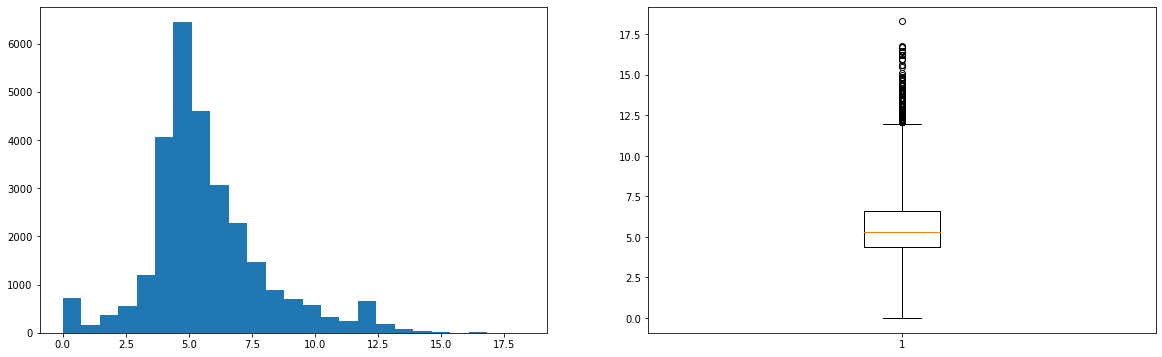

In [355]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(df.cons_avg, bins = 25)

plt.subplot(122)
plt.boxplot(df.cons_avg, whis=2.5)

plt.show()

## previous_owner

Being able to trace the car back to the original owner is important to some buyers, as you are able to directly find out about any faults with the vehicle. Having lots of previous_owners can be off-putting as it looks like the vehicle has lots of issues.

In [356]:
first_looking("previous_owner")

COLUMN NAME    :  previous_owner
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  13
--------------------------------
1.0     18696
2.0      7196
3.0      1756
4.0       498
5.0       205
6.0       100
8.0        71
7.0        57
9.0        25
12.0        6
10.0        2
14.0        1
13.0        1
Name: previous_owner, dtype: int64


In [357]:
df["previous_owner"].describe()

count    28614.000000
mean         1.512686
std          0.940194
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         14.000000
Name: previous_owner, dtype: float64

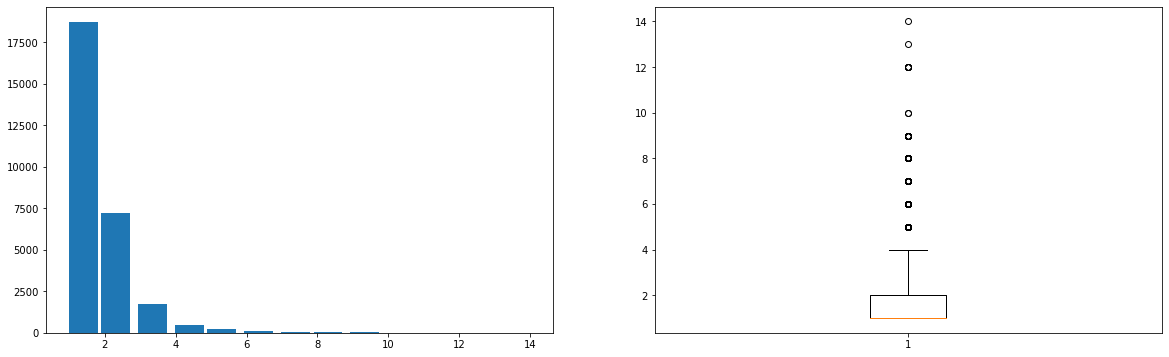

In [358]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["previous_owner"], bins=100, width=0.8)

plt.subplot(122)
plt.boxplot(df["previous_owner"], whis=2.5)

plt.show()

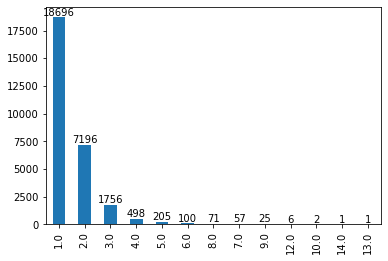

In [359]:
fig, ax = plt.subplots()

df["previous_owner"].value_counts(dropna = False).plot.bar()

for container in ax.containers:
    ax.bar_label(container);

In [360]:
df.sort_values(by=["previous_owner"], ascending=True)["previous_owner"].head(20)

# df["previous_owner"].sort_values(ascending=False).head(20)

14309    1.0
23062    1.0
13598    1.0
13596    1.0
23064    1.0
13594    1.0
13593    1.0
13592    1.0
13591    1.0
13590    1.0
13589    1.0
13588    1.0
13587    1.0
13586    1.0
13585    1.0
13584    1.0
23061    1.0
13582    1.0
13601    1.0
13603    1.0
Name: previous_owner, dtype: float64

In [361]:
df.sort_values(by=["previous_owner"], ascending=False)["previous_owner"].head(20)

# df["previous_owner"].sort_values(ascending=False).head(20)

7554     14.0
7828     13.0
27850    12.0
28401    12.0
19405    12.0
27820    12.0
28230    12.0
28200    12.0
17535    10.0
7259     10.0
26554     9.0
7571      9.0
3177      9.0
26176     9.0
25751     9.0
26067     9.0
26670     9.0
10385     9.0
26391     9.0
26621     9.0
Name: previous_owner, dtype: float64

In [362]:
df.groupby(["make_model", "body_type", "type", "previous_owner"]).age.describe()

count       mean  \
make_model  body_type        type           previous_owner                     
Dacia       Compact          Demonstration  1.0               1.0   1.000000   
                             Pre-registered 1.0               2.0   0.000000   
            Sedan            Used           1.0               1.0  47.000000   
            Station wagon    Demonstration  1.0               1.0   0.000000   
Dacia Break Station wagon    Demonstration  1.0               1.0   0.000000   
...                                                           ...        ...   
Volvo XC90  Off-Road/Pick-up Used           3.0               7.0  14.571429   
                                            8.0               1.0   8.000000   
            Sedan            Used           1.0               2.0   2.000000   
                                            2.0               1.0   4.000000   
            Station wagon    Used           1.0               4.0   6.000000   

                                                                 std   min  \
make_model  body_type        type           previous_owner                   
Dacia       Compact          Demonstration  1.0                  NaN   1.0   
                             Pre-registered 1.0             0.000000   0.0   
            Sedan            Used           1.0                  NaN  47.0   
            Station wagon    Demonstration  1.0                  NaN   0.0   
Dacia Break Station wagon    Demonstration  1.0                  NaN   0.0   
...                                                              ...   ...   
Volvo XC90  Off-Road/Pick-up Used           3.0             0.975900  14.0   
                                            8.0                  NaN   8.0   
            Sedan            Used           1.0             1.414214   1.0   
                                            2.0                  NaN   4.0   
            Station wagon    Used           1.0             0.000000   6.0   

                                                             25%   50%   75%  \
make_model  body_type        type           previous_owner                     
Dacia       Compact          Demonstration  1.0              1.0   1.0   1.0   
                             Pre-registered 1.0              0.0   0.0   0.0   
            Sedan            Used           1.0             47.0  47.0  47.0   
            Station wagon    Demonstration  1.0              0.0   0.0   0.0   
Dacia Break Station wagon    Demonstration  1.0              0.0   0.0   0.0   
...                                                          ...   ...   ...   
Volvo XC90  Off-Road/Pick-up Used           3.0             14.0  14.0  15.0   
                                            8.0              8.0   8.0   8.0   
            Sedan            Used           1.0              1.5   2.0   2.5   
                                            2.0              4.0   4.0   4.0   
            Station wagon    Used           1.0              6.0   6.0   6.0   

                                                             max  
make_model  body_type        type           previous_owner        
Dacia       Compact          Demonstration  1.0              1.0  
                             Pre-registered 1.0              0.0  
            Sedan            Used           1.0             47.0  
            Station wagon    Demonstration  1.0              0.0  
Dacia Break Station wagon    Demonstration  1.0              0.0  
...                                                          ...  
Volvo XC90  Off-Road/Pick-up Used           3.0             16.0  
                                            8.0              8.0  
            Sedan            Used           1.0              3.0  
                                            2.0              4.0  
            Station wagon    Used           1.0              6.0  

[3239 rows x 8 columns]

In [363]:
df.loc[df["previous_owner"] >= 10][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg", "previous_owner"]]\
                                 .sort_values(by=["previous_owner"], ascending=False)

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight,co_emissions,cons_avg,previous_owner
7554,Peugeot 207,15.0,Convertible,Manual,Front,5.0,1598.0,Benzine,1327.0,155.0,6.50,14.0
7828,Peugeot 306,25.0,Convertible,Manual,Front,5.0,1998.0,Benzine,1245.0,0.0,7.60,13.0
19405,Nissan 370Z,12.0,Coupe,Automatic,Rear,7.0,3696.0,Benzine,1483.0,245.0,10.50,12.0
27820,Volvo V70,25.0,Station wagon,Automatic,4WD,8.0,2319.0,Benzine,1651.0,0.0,10.75,12.0
27850,Volvo 945,25.0,Station wagon,Manual,Rear,5.0,1986.0,Liquid/Natural Gas,1320.0,124.0,10.20,12.0
28200,Volvo V70,25.0,Station wagon,Automatic,4WD,8.0,2319.0,Benzine,1651.0,0.0,10.75,12.0
28230,Volvo 945,25.0,Station wagon,Manual,Rear,5.0,1986.0,Liquid/Natural Gas,1320.0,124.0,10.20,12.0
28401,Volvo S70,25.0,Sedan,Manual,Front,5.0,2435.0,Benzine,1370.0,168.0,10.00,12.0
7259,Peugeot 206,18.0,Compact,Automatic,Front,4.0,1587.0,Benzine,1039.0,171.0,7.10,10.0
17535,Toyota MR 2,29.0,Coupe,Manual,Rear,5.0,1998.0,Benzine,1290.0,0.0,7.40,10.0


In [364]:
drop_pre_owner_index = df[df["previous_owner"] >= 10].index
drop_pre_owner_index

Int64Index([7259, 7554, 7828, 17535, 19405, 27820, 27850, 28200, 28230, 28401], dtype='int64')

In [365]:
print(df.shape)
df.drop(drop_pre_owner_index, inplace=True)
print(df.shape)

(28614, 27)
(28604, 27)


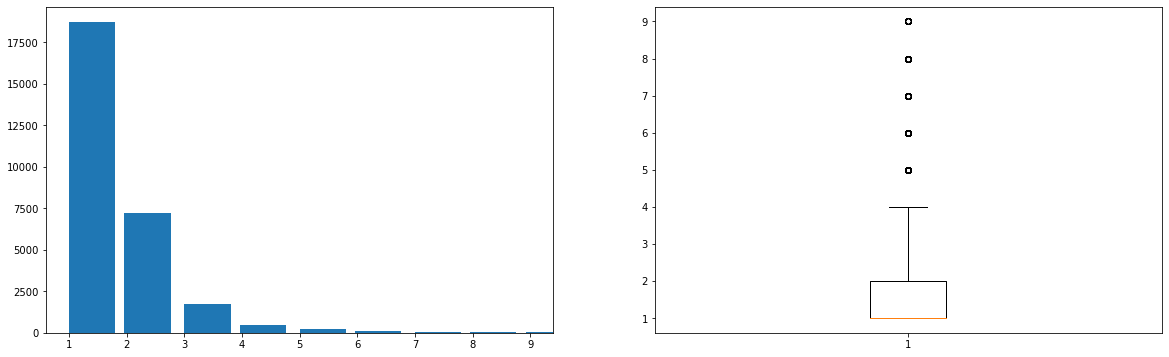

In [366]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["previous_owner"], bins=100, width=0.8)

plt.subplot(122)
plt.boxplot(df["previous_owner"], whis=2.5)

plt.show()

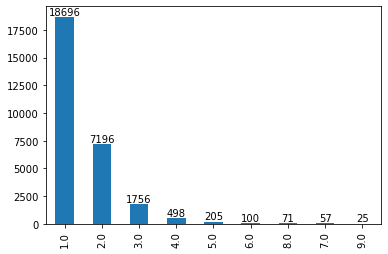

In [367]:
fig, ax = plt.subplots()

df["previous_owner"].value_counts(dropna = False).plot.bar()

for container in ax.containers:
    ax.bar_label(container);

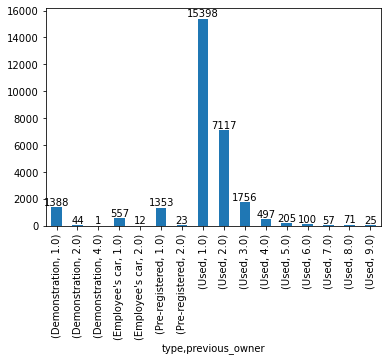

In [368]:
fig, ax = plt.subplots()

df.groupby(["type", "previous_owner"])["previous_owner"].count().plot.bar()

for container in ax.containers:
    ax.bar_label(container);

## age

Probably one of the most obvious factors. The older the car, the more worn it will be and therefore the less desirable it will become. Classics are the exception to this rule, but typically a 15 year old car will hold significantly less value than a five year old model.

In [369]:
first_looking("age")

COLUMN NAME    :  age
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  83
--------------------------------
 3.0      3666
 4.0      3489
 0.0      3087
 1.0      2870
 2.0      2473
          ... 
 89.0        1
 76.0        1
 66.0        1
-180.0       1
-3.0         1
Name: age, Length: 83, dtype: int64


In [370]:
df["age"].describe()

count    28604.000000
mean         6.821389
std          8.735451
min       -180.000000
25%          2.000000
50%          4.000000
75%          8.000000
max        122.000000
Name: age, dtype: float64

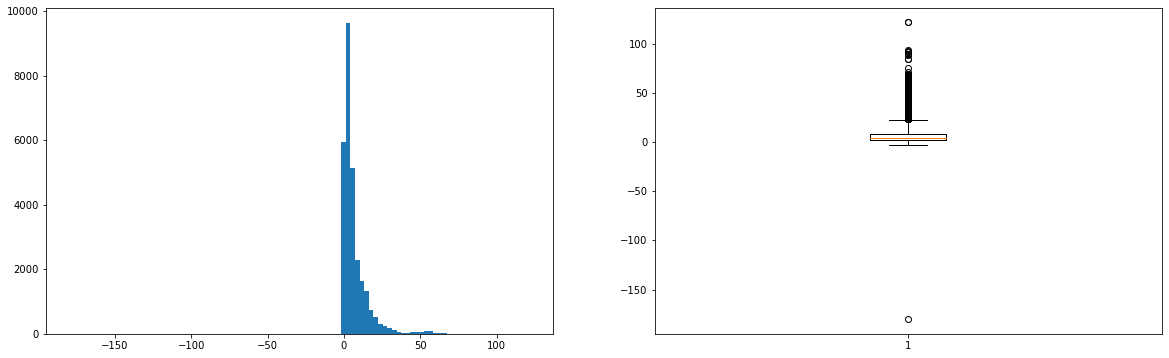

In [371]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["age"], bins=100)

plt.subplot(122)
plt.boxplot(df["age"], whis=2.5)

plt.show()

In [372]:
df.sort_values(by=["age"], ascending=True)["age"].head(20)

# df["age"].sort_values(ascending=False).head(20)

7011    -180.0
9764      -3.0
19213     -1.0
9250       0.0
10677      0.0
27461      0.0
10674      0.0
21979      0.0
21980      0.0
21990      0.0
21994      0.0
10634      0.0
21997      0.0
21998      0.0
10630      0.0
10625      0.0
22004      0.0
22008      0.0
22028      0.0
27440      0.0
Name: age, dtype: float64

In [373]:
df.sort_values(by=["age"], ascending=False)["age"].head(20)

# df["age"].sort_values(ascending=False).head(20)

24783    122.0
22058    122.0
21372     94.0
21200     93.0
21317     92.0
8043      92.0
21386     90.0
21461     90.0
21338     90.0
10009     89.0
21454     85.0
21349     85.0
9258      76.0
3358      72.0
5300      70.0
771       70.0
26698     69.0
26523     69.0
26668     68.0
26493     68.0
Name: age, dtype: float64

In [374]:
df.groupby(["make_model", "body_type", "type", "previous_owner"]).age.describe()

count       mean  \
make_model  body_type        type           previous_owner                     
Dacia       Compact          Demonstration  1.0               1.0   1.000000   
                             Pre-registered 1.0               2.0   0.000000   
            Sedan            Used           1.0               1.0  47.000000   
            Station wagon    Demonstration  1.0               1.0   0.000000   
Dacia Break Station wagon    Demonstration  1.0               1.0   0.000000   
...                                                           ...        ...   
Volvo XC90  Off-Road/Pick-up Used           3.0               7.0  14.571429   
                                            8.0               1.0   8.000000   
            Sedan            Used           1.0               2.0   2.000000   
                                            2.0               1.0   4.000000   
            Station wagon    Used           1.0               4.0   6.000000   

                                                                 std   min  \
make_model  body_type        type           previous_owner                   
Dacia       Compact          Demonstration  1.0                  NaN   1.0   
                             Pre-registered 1.0             0.000000   0.0   
            Sedan            Used           1.0                  NaN  47.0   
            Station wagon    Demonstration  1.0                  NaN   0.0   
Dacia Break Station wagon    Demonstration  1.0                  NaN   0.0   
...                                                              ...   ...   
Volvo XC90  Off-Road/Pick-up Used           3.0             0.975900  14.0   
                                            8.0                  NaN   8.0   
            Sedan            Used           1.0             1.414214   1.0   
                                            2.0                  NaN   4.0   
            Station wagon    Used           1.0             0.000000   6.0   

                                                             25%   50%   75%  \
make_model  body_type        type           previous_owner                     
Dacia       Compact          Demonstration  1.0              1.0   1.0   1.0   
                             Pre-registered 1.0              0.0   0.0   0.0   
            Sedan            Used           1.0             47.0  47.0  47.0   
            Station wagon    Demonstration  1.0              0.0   0.0   0.0   
Dacia Break Station wagon    Demonstration  1.0              0.0   0.0   0.0   
...                                                          ...   ...   ...   
Volvo XC90  Off-Road/Pick-up Used           3.0             14.0  14.0  15.0   
                                            8.0              8.0   8.0   8.0   
            Sedan            Used           1.0              1.5   2.0   2.5   
                                            2.0              4.0   4.0   4.0   
            Station wagon    Used           1.0              6.0   6.0   6.0   

                                                             max  
make_model  body_type        type           previous_owner        
Dacia       Compact          Demonstration  1.0              1.0  
                             Pre-registered 1.0              0.0  
            Sedan            Used           1.0             47.0  
            Station wagon    Demonstration  1.0              0.0  
Dacia Break Station wagon    Demonstration  1.0              0.0  
...                                                          ...  
Volvo XC90  Off-Road/Pick-up Used           3.0             16.0  
                                            8.0              8.0  
            Sedan            Used           1.0              3.0  
                                            2.0              4.0  
            Station wagon    Used           1.0              6.0  

[3231 rows x 8 columns]

### 📝 Domain Knowledge About Age:


**🧐 [When does a car become a classic?](https://www.axa.ie/articles/driving/when-does-a-car-become-a-classic/#:~:text=Many%20insurance%20companies%20say%20a,used%20as%20a%20second%20car.)**

UK motor tax laws define a vintage car as one that’s 30 or more years old. UK Revenue, however, specifies that a car is a classic if it is older than 15 years and has a value of more than £15,000, which would include cars such as Jaguars, Mercedes, Porsches and Triumphs. If you’re looking for classic car insurance, you’ll also find that each insurer has its own criteria. Many insurance companies say a classic car is one that’s more than 25 years old. It should be in excellent condition, driven 10,000 kilometres or less a year, and used as a second car. So, on that basis, it’s not all about Aston Martins and Porsches. In the US, they are much clearer on the subject. Their definition of a classic car comes from the Classic Car Club of America, which says that classic cars are ‘fine or unusual motor cars that were built between and including the years 1915 to 1948’. So, this would include the Aston Martin, Bentley and Austin - as well as the Jaguar, Rolls Royce, MG and Morris.

**🧐 [Understanding the Difference Between Classic, Antique, and Vintage Cars](https://americancollectors.com/articles/vintage-vs-classic-vs-antique-cars/)**

Many people classify vintage, antique and classic cars as the same thing. However, there are a few unique things that classify a car as “antique”, “classic”, or “vintage.” It is important to have a comprehensive understanding of your vehicle’s status. The key differences between vintage, classic and antique cars include:

- Price
- Historic Status
- Age

**Age**

The first key difference between the three types of collectors vehicles is their age. Classic, vintage and antique cars typically vary in age. Depending on your car’s classification, the age can interfere with the overall value and condition of your car. Older cars will need more work and care to remain in good condition. 

Here is how you can tell if your car is **``antique``**, **``classic``** or **``vintage``** by the year it was manufactured:

- **Vintage Car**: Manufactured between 1919 and 1930. Either a “survivor” or restored in conformance to the original manufacturer specifications
- **Antique Car**: Manufactured 1975 or earlier (>45 years old). Either a “survivor” or restored in conformance to the original manufacturer specifications
- **Classic Car**: Manufactured 2000 or earlier (>20 years old)



In [375]:
df.loc[df["age"] > 20][["make_model", "age", "previous_owner", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "cons_avg"]]\
                                 .sort_values(by=["age"], ascending=False)

,make_model,age,previous_owner,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,cons_avg
22058,Ford Bronco,122.0,1.0,Off-Road/Pick-up,Automatic,4WD,8.0,2000.0,Benzine,8.3
24783,Hyundai IONIQ,122.0,1.0,Sedan,Automatic,Front,6.0,1580.0,Benzine,1.1
21372,Ford,94.0,1.0,Convertible,Automatic,Rear,3.0,3600.0,Benzine,12.0
21200,Ford M,93.0,1.0,Convertible,Manual,Front,6.0,2043.0,Benzine,5.3
21317,Ford,92.0,3.0,Convertible,Automatic,Rear,3.0,5700.0,Benzine,12.0
...,...,...,...,...,...,...,...,...,...,...
20645,Nissan Patrol,21.0,2.0,Sedan,Automatic,4WD,5.0,2953.0,Diesel,9.5
20114,Nissan Primera,21.0,2.0,Station wagon,Manual,Front,5.0,1998.0,Benzine,8.3
20103,Nissan Primera,21.0,3.0,Station wagon,Manual,Front,5.0,1769.0,Benzine,7.4
3348,Opel Astra,21.0,1.0,Coupe,Manual,Front,5.0,1998.0,Benzine,8.9


**If you want,** **``Vintage Cars``**, **``Antique Cars``** **and** **``Classic Cars``** **might be excluded from this analysis due to the lack of their counts**

In [376]:
# Get the count of each value

car_counts = df['age'].value_counts()
car_counts

 3.0      3666
 4.0      3489
 0.0      3087
 1.0      2870
 2.0      2473
          ... 
 89.0        1
 76.0        1
 66.0        1
-180.0       1
-3.0         1
Name: age, Length: 83, dtype: int64

In [377]:
drop_old_cars_index = df.loc[(df["age"] > 20) | (df["age"] < 0)].index
drop_old_cars_index

Int64Index([   88,   282,   402,   442,   443,   452,   487,   516,   529,
              538,
            ...
            28463, 28496, 28504, 28511, 28560, 28564, 28573, 28602, 28614,
            28615],
           dtype='int64', length=1695)

In [378]:
print(df.shape)
df.drop(drop_old_cars_index, axis=0, inplace=True)
print(df.shape)

(28604, 27)
(26909, 27)


In [379]:
# Get the count of each value
car_age_counts = df['age'].value_counts()
car_age_counts

# # Select the values where the count is less than 10 (or whatever you desire)
# drop_age_cars_index = car_age_counts[car_age_counts < 10].index

# df.drop(drop_age_cars_index, axis=0, inplace=True)

# OR

# # Keep rows where the age column is not in to_remove
# # df = df[~df.age.isin(drop_age_cars_index)]

3.0     3666
4.0     3489
0.0     3087
1.0     2870
2.0     2473
5.0     2426
6.0     1486
7.0     1237
8.0      936
9.0      703
10.0     655
11.0     641
12.0     558
15.0     491
14.0     441
13.0     424
16.0     395
17.0     287
18.0     246
19.0     211
20.0     187
Name: age, dtype: int64

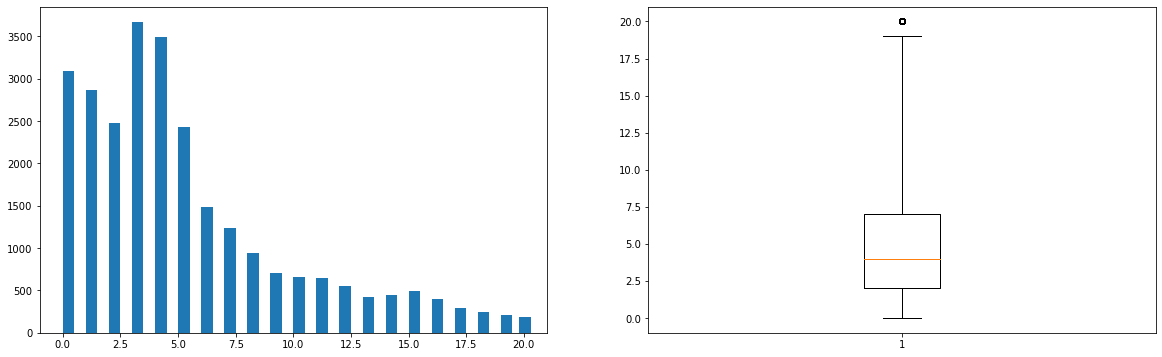

In [380]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["age"], bins=100, width=0.5)

plt.subplot(122)
plt.boxplot(df["age"], whis=2.5)

plt.show()

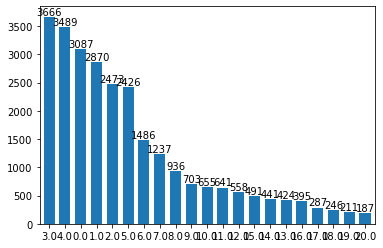

In [381]:
fig, ax = plt.subplots()

df["age"].value_counts(dropna=False).plot.bar(width=0.7)

plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container);

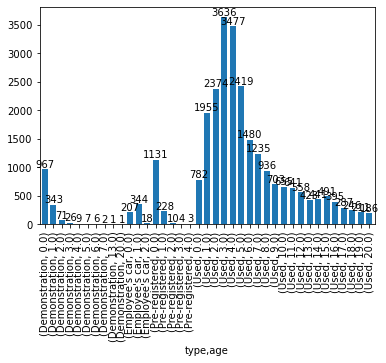

In [382]:
fig, ax = plt.subplots()

df.groupby(["type", "age"])["age"].count().plot.bar(width=0.7)

for container in ax.containers:
    ax.bar_label(container);

## power_kW

In [383]:
first_looking("power_kW")

COLUMN NAME    :  power_kW
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  321
--------------------------------
110.0    1987
96.0     1353
88.0     1181
81.0     1156
66.0     1087
         ... 
665.0       1
883.0       1
246.0       1
9.0         1
746.0       1
Name: power_kW, Length: 321, dtype: int64


In [384]:
df["power_kW"].describe()

count    26909.000000
mean       119.473782
std         68.503394
min          1.000000
25%         80.000000
50%        100.000000
75%        135.000000
max        883.000000
Name: power_kW, dtype: float64

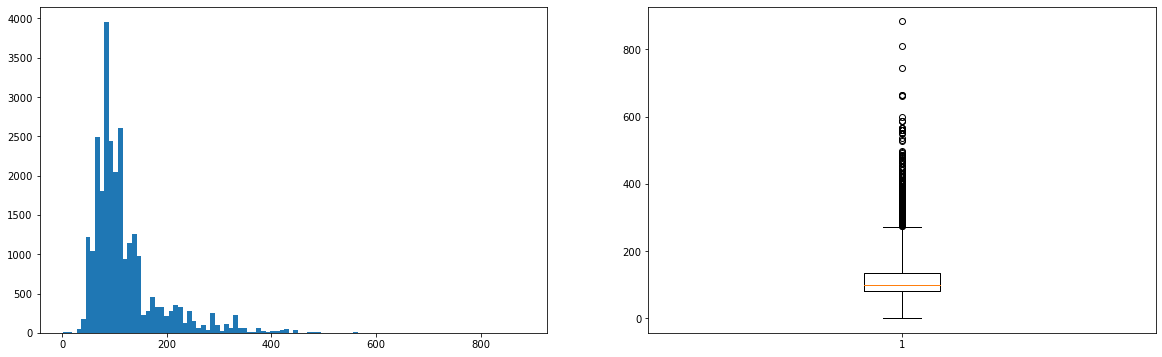

In [385]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["power_kW"], bins=100)

plt.subplot(122)
plt.boxplot(df["power_kW"], whis=2.5)

plt.show()

In [386]:
df.sort_values(by=["power_kW"], ascending=False)["power_kW"].head(20)

# df["kW"].sort_values(ascending=False).head(20)

19469    883.0
19499    810.0
19288    746.0
19473    665.0
19584    664.0
21772    662.0
19534    600.0
1076     588.0
1451     588.0
19483    588.0
21569    567.0
21541    567.0
21662    567.0
21818    559.0
21801    559.0
21781    559.0
21780    559.0
21821    559.0
21777    559.0
21794    559.0
Name: power_kW, dtype: float64

In [387]:
# df.sort_values(by=["kW"], ascending=True)["kW"].head(20)

df["power_kW"].sort_values(ascending=True).head(20)

5173      1.0
5430      1.0
22101     3.0
5786      4.0
6205      4.0
5748      4.0
6166      4.0
5936      4.0
24429     6.0
5545      7.0
5919      8.0
5952      8.0
5816      8.0
5140      9.0
5836     12.0
4838     12.0
4886     13.0
16416    18.0
16471    18.0
16405    19.0
Name: power_kW, dtype: float64

In [388]:
df.groupby(["make_model", "body_type", "fuel_type"]).power_kW.describe()

count        mean        std    min  \
make_model   body_type        fuel_type                                        
Dacia        Compact          Benzine      3.0   33.000000   0.000000   33.0   
             Station wagon    Benzine      1.0   81.000000        NaN   81.0   
Dacia Break  Station wagon    Benzine      1.0  110.000000        NaN  110.0   
Dacia Dokker Compact          Diesel       1.0   66.000000        NaN   66.0   
             Off-Road/Pick-up Benzine      1.0   75.000000        NaN   75.0   
...                                        ...         ...        ...    ...   
Volvo XC90   Off-Road/Pick-up Benzine     38.0  240.157895  35.373319  184.0   
                              Diesel     157.0  182.312102  40.423377  120.0   
                              Electric     4.0  290.500000   4.041452  287.0   
             Sedan            Diesel       3.0  189.666667  28.867513  173.0   
             Station wagon    Diesel       4.0  165.000000   0.000000  165.0   

                                           25%    50%     75%    max  
make_model   body_type        fuel_type                               
Dacia        Compact          Benzine     33.0   33.0   33.00   33.0  
             Station wagon    Benzine     81.0   81.0   81.00   81.0  
Dacia Break  Station wagon    Benzine    110.0  110.0  110.00  110.0  
Dacia Dokker Compact          Diesel      66.0   66.0   66.00   66.0  
             Off-Road/Pick-up Benzine     75.0   75.0   75.00   75.0  
...                                        ...    ...     ...    ...  
Volvo XC90   Off-Road/Pick-up Benzine    223.0  228.0  287.75  288.0  
                              Diesel     173.0  173.0  173.00  300.0  
                              Electric   287.0  290.5  294.00  294.0  
             Sedan            Diesel     173.0  173.0  198.00  223.0  
             Station wagon    Diesel     165.0  165.0  165.00  165.0  

[1542 rows x 8 columns]

In [389]:
df.loc[(df["power_kW"] == 9) | (df["power_kW"] == 12)][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg", "power_kW"]]\
                                 .sort_values(by=["power_kW"], ascending=False)

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight,co_emissions,cons_avg,power_kW
4838,Renault Twizy,10.0,Compact,Automatic,Rear,1.0,1598.0,Electric,473.0,0.0,2.359,12.0
5836,Renault Megane,9.0,Coupe,Manual,Front,6.0,1998.0,Benzine,1387.0,178.0,7.600,12.0
5140,Renault Twizy,0.0,Compact,Automatic,Rear,1.0,1598.0,Electric,562.0,0.0,2.359,9.0


In [390]:
# df.loc[df.make_model == "Renault Twizy"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg", "power_kW"]]
df.loc[df.make_model == "Renault Megane"][["make_model", "age", "body_type", "gearbox", "drivetrain", "gears", "engine_size", "fuel_type", "empty_weight", "co_emissions", "cons_avg", "power_kW"]]

,make_model,age,body_type,gearbox,drivetrain,gears,engine_size,fuel_type,empty_weight,co_emissions,cons_avg,power_kW
4783,Renault Megane,1.0,Compact,Manual,Front,6.0,1332.0,Benzine,1180.0,126.0,5.50,103.0
4786,Renault Megane,1.0,Compact,Automatic,Front,6.0,1798.0,Benzine,1381.0,133.5,0.00,221.0
4789,Renault Megane,4.0,Compact,Automatic,Front,7.0,1500.0,Diesel,1180.0,104.0,3.95,81.0
4791,Renault Megane,7.0,Compact,Manual,Front,6.0,1461.0,Diesel,1215.0,104.0,3.50,81.0
4793,Renault Megane,8.0,Compact,Manual,Front,6.0,1461.0,Diesel,1190.0,90.0,3.40,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7111,Renault Megane,0.0,Sedan,Automatic,Front,6.0,1461.0,Benzine,1315.0,127.0,5.65,160.0
7115,Renault Megane,10.0,Sedan,Manual,Front,6.0,1200.0,Benzine,1315.0,127.0,5.65,85.0
7117,Renault Megane,2.0,Sedan,Manual,Front,6.0,1461.0,Diesel,1315.0,102.0,3.90,85.0
7118,Renault Megane,2.0,Sedan,Automatic,Front,7.0,1461.0,Diesel,1315.0,104.0,3.90,85.0


### 📝 Domain Knowledge on kW of Some Cars:

- Nissan Leaf - 110kW
- Hyundai Kona Electric – 150kW
- Mercedes-Benz EQC - 300kW
- Porsche Taycan Turbo S – 560kW
- Tesla Model S Performance – 595kW

**🧐 [List of production cars by power output](https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output)**

In [391]:
# Get the count of each value
car_kW_counts = df['power_kW'].value_counts()
car_kW_counts

110.0    1987
96.0     1353
88.0     1181
81.0     1156
66.0     1087
         ... 
665.0       1
883.0       1
246.0       1
9.0         1
746.0       1
Name: power_kW, Length: 321, dtype: int64

In [392]:
car_kW_counts[car_kW_counts < 10]

559.0    9
123.0    9
127.0    9
239.0    9
343.0    8
        ..
665.0    1
883.0    1
246.0    1
9.0      1
746.0    1
Name: power_kW, Length: 145, dtype: int64

In [393]:
# run the command %pprint. This turns pretty printing off. The list will now display horizontally.
%pprint

less_freq_kW = car_kW_counts[car_kW_counts < 10].index.to_list()
less_freq_kW

Pretty printing has been turned ON


[559.0,
 123.0,
 127.0,
 239.0,
 343.0,
 324.0,
 198.0,
 188.0,
 131.0,
 153.0,
 166.0,
 47.0,
 385.0,
 69.0,
 178.0,
 370.0,
 380.0,
 207.0,
 470.0,
 345.0,
 299.0,
 271.0,
 40.0,
 295.0,
 111.0,
 353.0,
 149.0,
 368.0,
 174.0,
 203.0,
 392.0,
 307.0,
 148.0,
 4.0,
 286.0,
 126.0,
 193.0,
 357.0,
 230.0,
 248.0,
 420.0,
 106.0,
 109.0,
 309.0,
 339.0,
 487.0,
 214.0,
 167.0,
 146.0,
 360.0,
 240.0,
 94.0,
 400.0,
 196.0,
 340.0,
 229.0,
 266.0,
 387.0,
 216.0,
 8.0,
 293.0,
 58.0,
 567.0,
 441.0,
 484.0,
 313.0,
 588.0,
 222.0,
 354.0,
 463.0,
 312.0,
 358.0,
 311.0,
 279.0,
 189.0,
 1.0,
 552.0,
 292.0,
 18.0,
 244.0,
 346.0,
 12.0,
 209.0,
 35.0,
 274.0,
 124.0,
 267.0,
 493.0,
 372.0,
 3.0,
 499.0,
 46.0,
 144.0,
 234.0,
 365.0,
 316.0,
 255.0,
 6.0,
 341.0,
 485.0,
 39.0,
 551.0,
 662.0,
 530.0,
 328.0,
 332.0,
 41.0,
 303.0,
 32.0,
 236.0,
 242.0,
 254.0,
 13.0,
 384.0,
 373.0,
 19.0,
 34.0,
 342.0,
 45.0,
 217.0,
 24.0,
 409.0,
 7.0,
 537.0,
 31.0,
 284.0,
 179.0,
 89.0,
 471.0,

**Let us assign the values of observations whose frequencies are less than 10 to NaN:** 

In [394]:
df["power_kW"].replace(less_freq_kW, np.nan, inplace=True)

In [395]:
df["power_kW"].isnull().sum()

464

In [396]:
fill(df, "make_model", "body_type", "power_kW", "median")

COLUMN NAME    :  power_kW
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  186
--------------------------------
110.0    2005
96.0     1369
88.0     1185
81.0     1157
66.0     1094
         ... 
212.5       1
355.0       1
440.0       1
230.0       1
98.5        1
Name: power_kW, Length: 186, dtype: int64


In [397]:
df.shape

(26909, 27)

## Final_Step

In [398]:
df.head(3).T

,0,1,2
make_model,Mercedes-Benz A 160,Mercedes-Benz EQE 350,Mercedes-Benz A 45 AMG
make,Mercedes-Benz,Mercedes-Benz,Mercedes-Benz
location,"P.I. EL PALMAR C/FORJA 6, 11500 PUERTO DE SAN...","APARTADO DE CORREOS 1032, 26140 LOGROÑO, ES","PORT. TARRACO, MOLL DE LLEVANT, Nº 5, LOC. 6-8..."
price,16950.0,80900.0,69900.0
body_type,Compact,Compact,Compact
type,Used,Pre-registered,Used
warranty,Yes,Yes,Yes
mileage,120200.0,5000.0,18900.0
gearbox,Manual,Automatic,Automatic
fuel_type,Diesel,Electric,Benzine


In [399]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26909 entries, 0 to 28629
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   make_model                     26909 non-null  object 
 1   make                           26909 non-null  object 
 2   location                       26909 non-null  object 
 3   price                          26909 non-null  float64
 4   body_type                      26909 non-null  object 
 5   type                           26909 non-null  object 
 6   warranty                       26909 non-null  object 
 7   mileage                        26909 non-null  float64
 8   gearbox                        26909 non-null  object 
 9   fuel_type                      26909 non-null  object 
 10  seller                         26909 non-null  object 
 11  engine_size                    26909 non-null  float64
 12  gears                          26909 non-null 

In [400]:
numeric_col.head()

,price,doors,mileage,seats,engine_size,gears,co_emissions,empty_weight,previous_owner,age,power_kW,cons_avg
0,16950.0,5.0,120200.0,5.0,1595.0,5.0,98.0,1270.0,2.0,6.0,75.0,3.800
1,80900.0,4.0,5000.0,5.0,1.0,9.0,0.0,2355.0,1.0,0.0,215.0,2.359
2,69900.0,5.0,18900.0,5.0,1991.0,8.0,162.0,1555.0,2.0,2.0,310.0,8.400
3,46990.0,5.0,18995.0,5.0,1991.0,7.0,169.0,1455.0,2.0,2.0,225.0,7.300
4,16800.0,5.0,197000.0,5.0,2143.0,7.0,162.0,1545.0,2.0,7.0,100.0,4.900


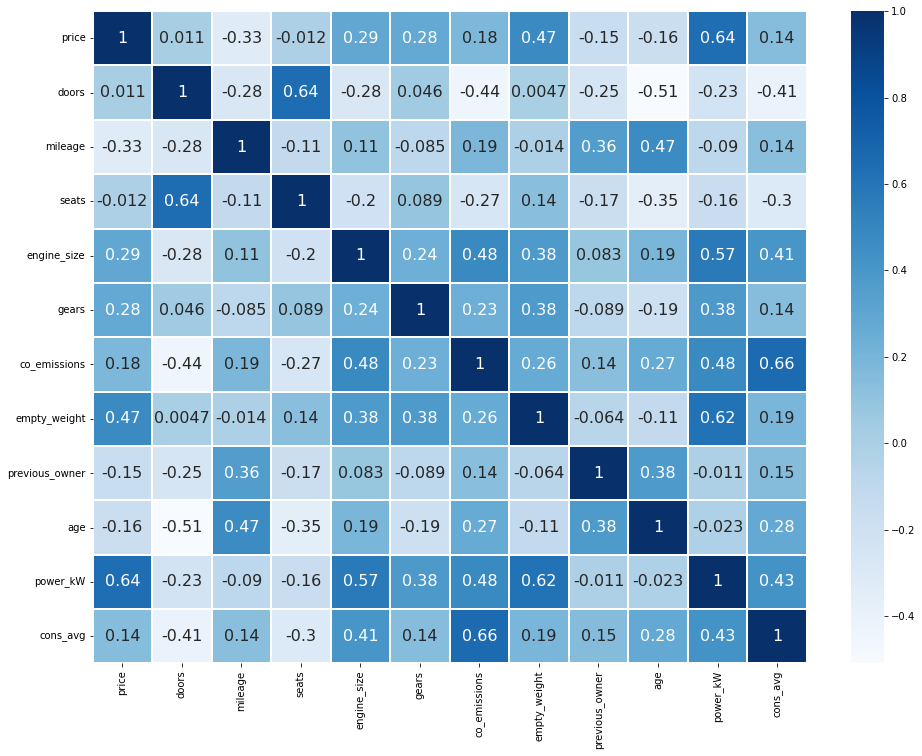

In [401]:
plt.figure(figsize=(16, 12))

sns.heatmap(numeric_col.corr(), annot=True, cmap="Blues", linewidths=0.2, annot_kws={"size": 16});

In [402]:
# function for set text color of correlation values in Dataframes

def color_correlation(val):
    """
    Takes a scalar and returns a string with
    the css property in a variety of color scales 
    for different correlations.
    """
    if val >= 0.6 and val < 0.99999 or val <= -0.6 and val > -0.99999:
        color = 'red'
    elif val < 0.6 and val >= 0.3 or val > -0.6 and val <= -0.3:
        color = 'blue'
    elif val == 1:
        color = 'cyan'    
    else:
        color = 'black'
    return 'color: %s' % color
 
numeric_col.corr().style.applymap(color_correlation)

,price,doors,mileage,seats,engine_size,gears,co_emissions,empty_weight,previous_owner,age,power_kW,cons_avg
price,1.000000,0.010924,-0.326521,-0.012043,0.288914,0.279404,0.177056,0.469819,-0.153524,-0.163697,0.637681,0.141508
doors,0.010924,1.000000,-0.275260,0.641343,-0.278144,0.045606,-0.437707,0.004659,-0.246056,-0.509599,-0.226294,-0.409310
mileage,-0.326521,-0.275260,1.000000,-0.112290,0.107828,-0.085081,0.185934,-0.014000,0.359346,0.468608,-0.090270,0.138120
seats,-0.012043,0.641343,-0.112290,1.000000,-0.197151,0.089172,-0.267465,0.135834,-0.166477,-0.352069,-0.160814,-0.297735
engine_size,0.288914,-0.278144,0.107828,-0.197151,1.000000,0.235189,0.480938,0.375618,0.082693,0.187713,0.574683,0.406594
gears,0.279404,0.045606,-0.085081,0.089172,0.235189,1.000000,0.234726,0.378272,-0.089035,-0.187567,0.382190,0.143344
co_emissions,0.177056,-0.437707,0.185934,-0.267465,0.480938,0.234726,1.000000,0.264167,0.135849,0.266255,0.476275,0.656592
empty_weight,0.469819,0.004659,-0.014000,0.135834,0.375618,0.378272,0.264167,1.000000,-0.063775,-0.110257,0.616131,0.187480
previous_owner,-0.153524,-0.246056,0.359346,-0.166477,0.082693,-0.089035,0.135849,-0.063775,1.000000,0.379135,-0.011411,0.147931
age,-0.163697,-0.509599,0.468608,-0.352069,0.187713,-0.187567,0.266255,-0.110257,0.379135,1.000000,-0.023097,0.277533


### The Examination of Multicolineraty

If there is a strong correlation between the independent variables, this situation is called **multicolineraty**.
 
**Multicolineraty** prevents my model from detecting important features.

**🧐 [Multi-Collinearity in Regression](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)**

In [403]:
from termcolor import cprint

def multicolinearity_control(df):                    
    df_temp = df.corr()
    count = 'Done'
    feature =[]
    collinear= []
    for col in df_temp.columns:
        for i in df_temp.index:
            if abs(df_temp[col][i] > .6 and df_temp[col][i] < 1):
                    feature.append(col)
                    collinear.append(i)
                    cprint(f"Multicolinearity alert in between --> {col} - {i} --> {round(df_temp[col][i], 6)}", "red", attrs=["bold"])
    else:
#         cprint(f"There is NO multicollinearity problem.", "blue", attrs=["bold"])
        pass

In [404]:
multicolinearity_control(numeric_col)

Multicolinearity alert in between --> price - power_kW --> 0.637681
Multicolinearity alert in between --> doors - seats --> 0.641343
Multicolinearity alert in between --> seats - doors --> 0.641343
Multicolinearity alert in between --> co_emissions - cons_avg --> 0.656592
Multicolinearity alert in between --> empty_weight - power_kW --> 0.616131
Multicolinearity alert in between --> power_kW - price --> 0.637681
Multicolinearity alert in between --> power_kW - empty_weight --> 0.616131
Multicolinearity alert in between --> cons_avg - co_emissions --> 0.656592


In [405]:
target = 'price'

corr_by_target = df.corr()[target].sort_values()
corr_by_target

age              -0.405785
mileage          -0.397009
previous_owner   -0.190523
gears             0.214484
co_emissions      0.215779
cons_avg          0.224945
engine_size       0.436431
empty_weight      0.581159
power_kW          0.710088
price             1.000000
Name: price, dtype: float64

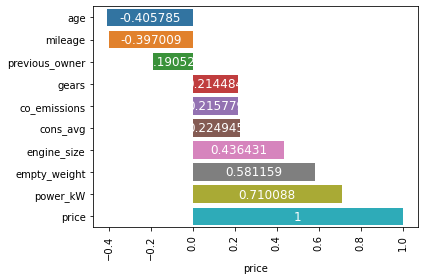

In [406]:
ax = sns.barplot(y = corr_by_target.index, x = corr_by_target)
plt.xticks(rotation=90)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fontsize=12, rotation=0, label_type='center', color="white")

In [407]:
# def check_dist(numeric_col, var):
#     plt.figure(figsize=(15,6))
#     plt.subplot(1, 2, 1)
#     sns.histplot(x=var, data=numeric_col)
#     plt.subplot(1, 2, 2)
#     stats.probplot(numeric_col[var], dist="norm", plot=plt)
#     plt.show()

In [408]:
# for col in numeric_col.drop("price", axis=1).columns:
#     check_dist(numeric_col, col)

In [409]:
# sns.pairplot(df_num, size=2.5);

In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26909 entries, 0 to 28629
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   make_model                     26909 non-null  object 
 1   make                           26909 non-null  object 
 2   location                       26909 non-null  object 
 3   price                          26909 non-null  float64
 4   body_type                      26909 non-null  object 
 5   type                           26909 non-null  object 
 6   warranty                       26909 non-null  object 
 7   mileage                        26909 non-null  float64
 8   gearbox                        26909 non-null  object 
 9   fuel_type                      26909 non-null  object 
 10  seller                         26909 non-null  object 
 11  engine_size                    26909 non-null  float64
 12  gears                          26909 non-null 

In [411]:
df.duplicated(keep=False).sum()

3526

In [412]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(26909, 27)
(25087, 27)


## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Some Specific Questions on Analysis</p>

<a id="3"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

### 1. What is the`` average`` ``Mileage`` of the vehicles according to their ``body types``?

In [413]:
# Average mileage of Vehicles by body_type

avg_mileage = df.groupby(["make_model", "body_type"]).mileage.mean()
avg_mileage

make_model    body_type       
Dacia         Compact                865.333333
              Station wagon         2000.000000
Dacia Break   Station wagon          999.000000
Dacia Dokker  Compact             141100.000000
              Off-Road/Pick-up    100000.000000
                                      ...      
Volvo XC70    Station wagon       181608.000000
Volvo XC90    Coupe                81250.000000
              Off-Road/Pick-up     84454.754902
              Sedan                58761.333333
              Station wagon       146775.000000
Name: mileage, Length: 1073, dtype: float64

In [414]:
# Average mileage of body_type

avg_mileage_body = df.groupby("body_type").mileage.mean()
avg_mileage_body

body_type
Compact             67803.469546
Convertible         96081.404525
Coupe               87163.014346
Off-Road/Pick-up    50264.271537
Sedan               51642.836338
Station wagon       73793.763436
Name: mileage, dtype: float64

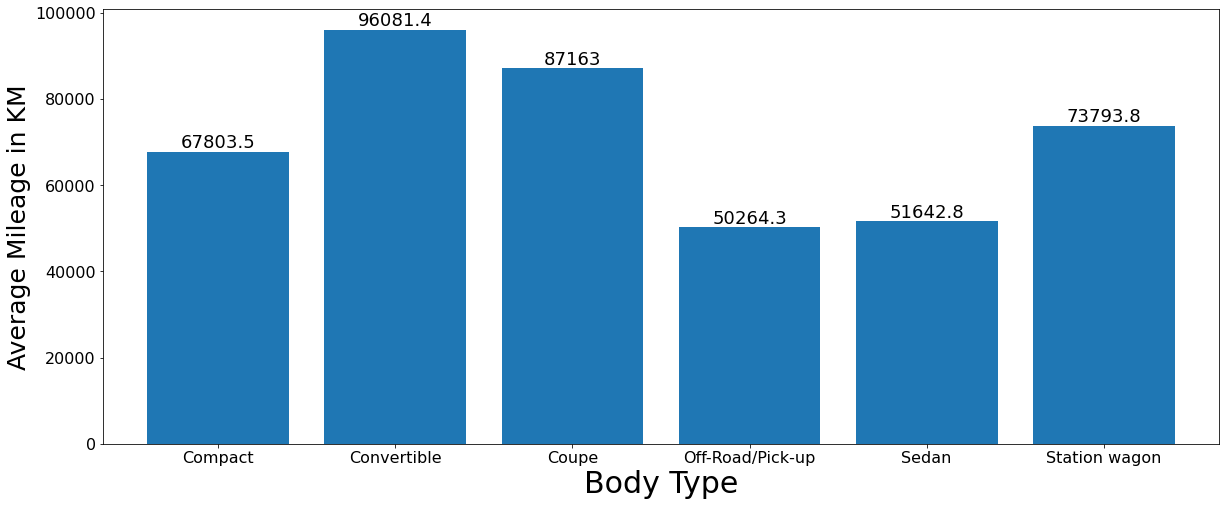

In [415]:
ax = avg_mileage_body.plot.bar(figsize=(20, 8), fontsize=16, width=0.8, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=18, rotation=0)
    
ax.set_xlabel('Body Type', fontsize=30)
ax.set_ylabel('Average Mileage in KM', fontsize=25);
# plt.legend(title="body_type", title_fontsize=14, prop={'size': 14}, bbox_to_anchor=(0.72, 0.9));

### 2. What is the ``average`` ``price`` of the vehicles according to the ``gearbox`` they have?

In [416]:
# Average Price of Vehicles by gearbox and make_model

avg_price1 = df.groupby(["make_model", "gearbox"]).price.mean()
avg_price1

make_model    gearbox       
Dacia         Automatic         21431.000000
              Manual            21799.000000
Dacia Break   Manual            20500.000000
Dacia Dokker  Manual            13209.000000
Dacia Duster  Automatic         18861.200000
                                    ...     
Volvo XC70    Automatic         21652.187500
              Manual            15950.000000
Volvo XC90    Automatic         52388.904762
              Manual             7333.000000
              Semi-automatic    36000.000000
Name: price, Length: 754, dtype: float64

In [417]:
# Average Price of body_type

avg_price_body = df.groupby("body_type").price.mean().sort_values(ascending=False)
avg_price_body

body_type
Coupe               30300.197691
Off-Road/Pick-up    29432.908296
Sedan               22672.017411
Station wagon       22258.382736
Convertible         21127.275690
Compact             15994.584437
Name: price, dtype: float64

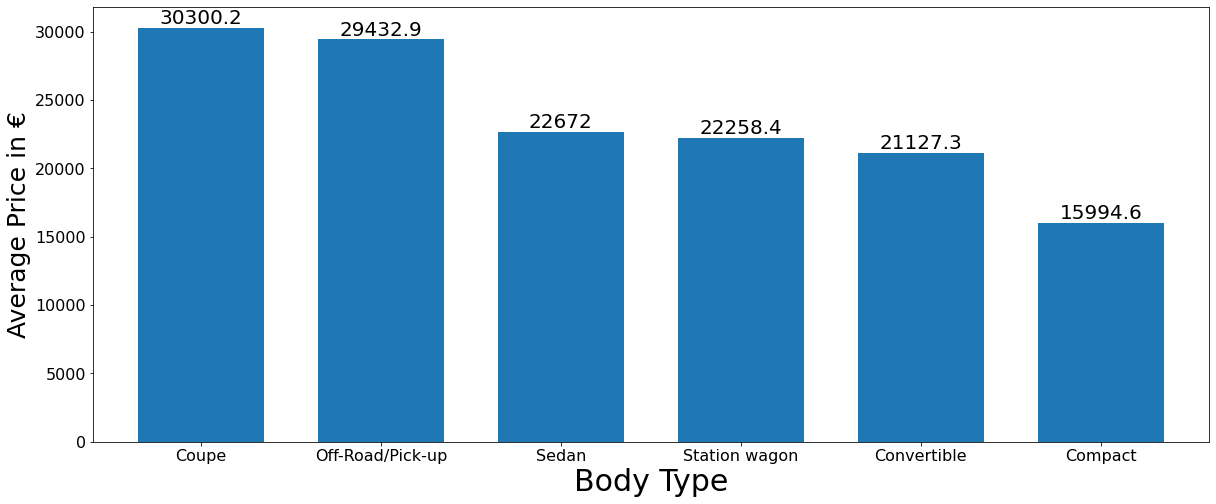

In [418]:
ax = avg_price_body.plot.bar(figsize=(20, 8), fontsize=16, width=0.7, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=0)
    
ax.set_xlabel('Body Type', fontsize=30)
ax.set_ylabel('Average Price in €', fontsize=25);
# plt.legend(title="body_type", title_fontsize=14, prop={'size': 14}, bbox_to_anchor=(0.23, 0.92));

In [419]:
# Average Price of make

avg_price_make = df.groupby("make").price.mean().sort_values(ascending=False)
avg_price_make

make
Mercedes-Benz    52409.721785
Ford             30086.158018
Volvo            27195.896281
Skoda            23440.235526
Toyota           22863.069244
Nissan           21338.532454
Hyundai          19700.102186
SEAT             19339.567872
Opel             17569.146119
Renault          17044.089350
Peugeot          16806.602045
Fiat             15716.802532
Dacia            13343.732510
Name: price, dtype: float64

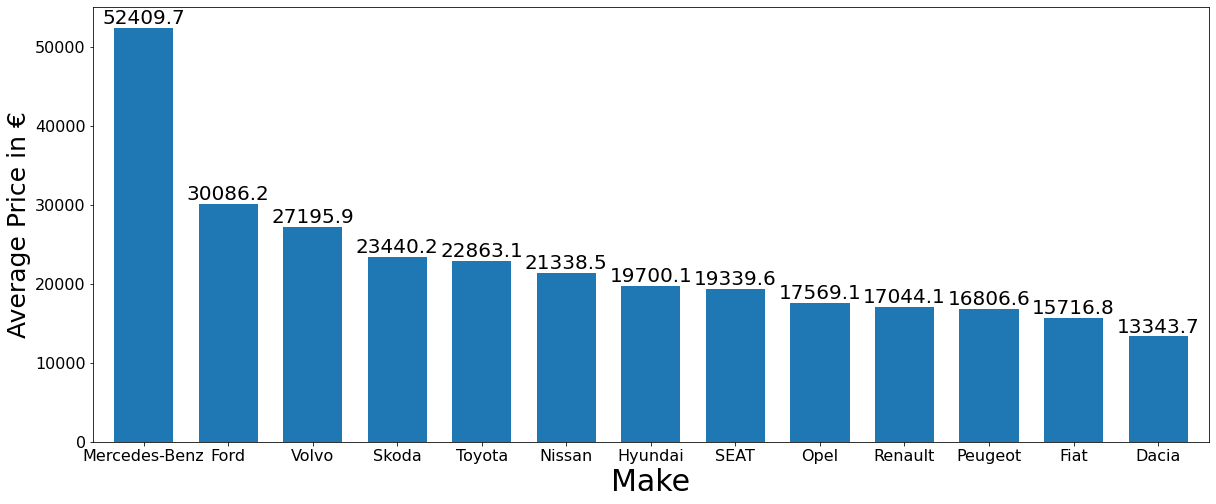

In [420]:
ax = avg_price_make.plot.bar(figsize=(20, 8), fontsize=16, width=0.7, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=0)
    
ax.set_xlabel('Make', fontsize=30)
ax.set_ylabel('Average Price in €', fontsize=25);

### 3. What is the ``average`` ``price`` of the vehicles according to the ``fuel types`` they use?

In [421]:
# Average Price of Vehicles by fuel_type & make_model

avg_price2 = df.groupby(["make_model", "fuel_type"]).price.mean()
avg_price2

make_model    fuel_type         
Dacia         Benzine               21523.000000
Dacia Break   Benzine               20500.000000
Dacia Dokker  Benzine               14114.666667
              Diesel                12864.516129
              Liquid/Natural Gas    12405.714286
                                        ...     
Volvo XC70    Benzine               26950.000000
              Diesel                20964.687500
Volvo XC90    Benzine               65273.894737
              Diesel                47611.704545
              Electric              64400.000000
Name: price, Length: 778, dtype: float64

In [422]:
# Average Price of fuel_type by body_type

avg_price_fuel_type1 = df.groupby(["body_type", "fuel_type"]).price.mean().sort_values(ascending=False)
avg_price_fuel_type1

body_type         fuel_type         
Off-Road/Pick-up  Electric              56601.365854
Station wagon     Electric              50525.235294
Sedan             Electric              45247.360544
Coupe             Benzine               32905.467995
Off-Road/Pick-up  Benzine               29883.824448
Convertible       Electric              29242.235294
Off-Road/Pick-up  Diesel                28216.136852
Compact           Electric              25359.613333
Coupe             Electric              23225.538462
Station wagon     Benzine               23170.189451
Convertible       Benzine               22691.157309
Sedan             Benzine               22477.141308
Station wagon     Diesel                21486.112377
Sedan             Diesel                21166.104215
Coupe             Diesel                18117.845011
Off-Road/Pick-up  Liquid/Natural Gas    17739.985507
Sedan             Liquid/Natural Gas    16306.567568
Compact           Benzine               16191.150374
         

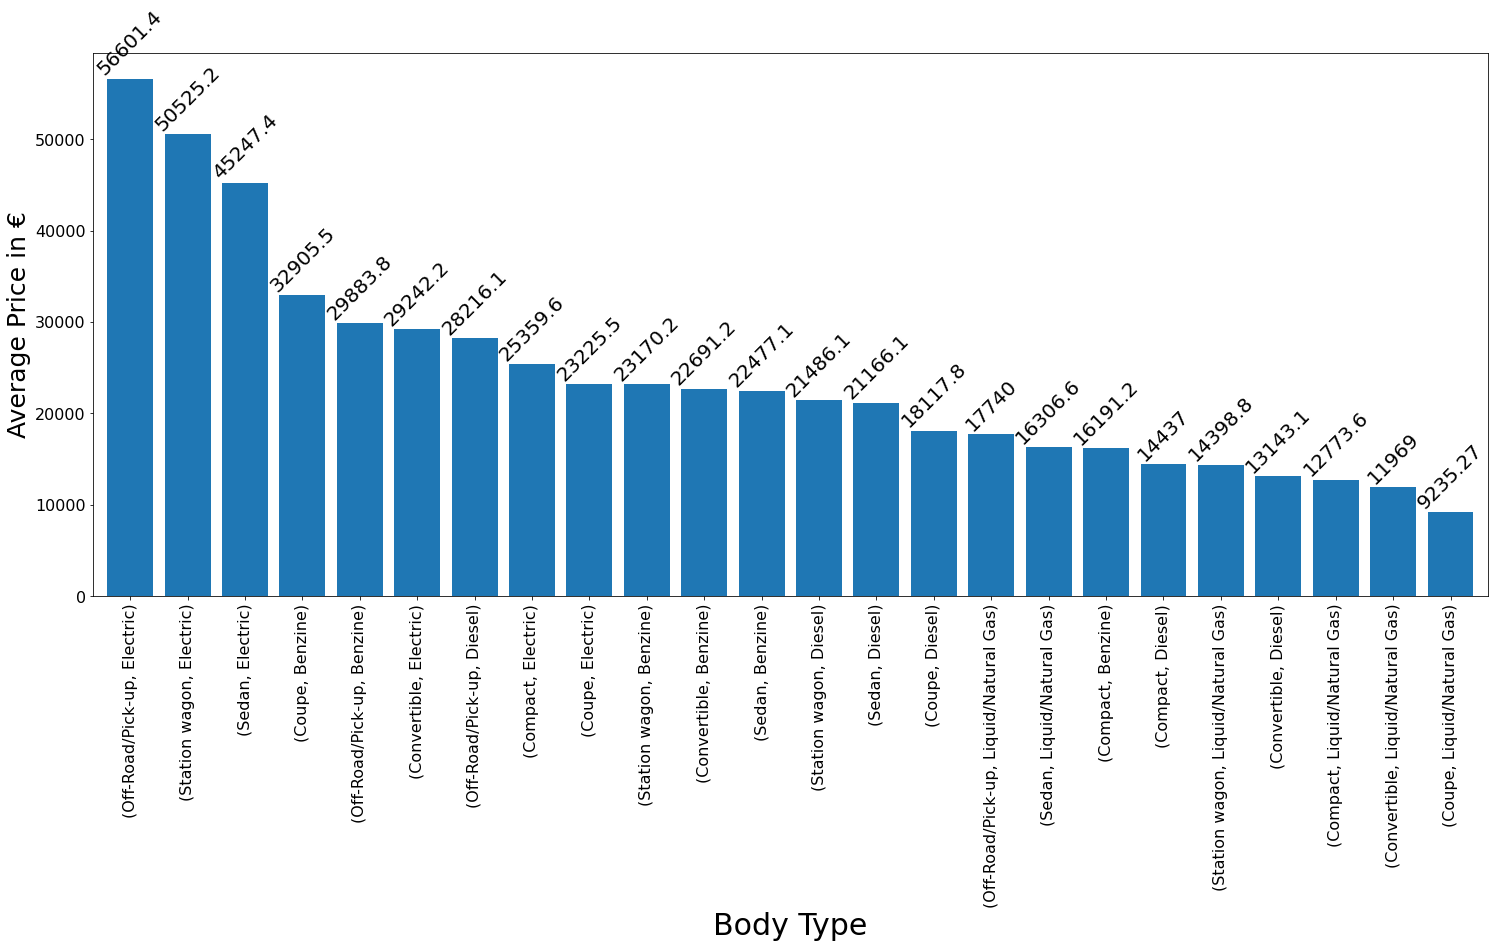

In [423]:
ax = avg_price_fuel_type1.plot.bar(figsize=(25, 10), fontsize=16, width=0.8, rot=90)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=45)
    
ax.set_xlabel('Body Type', fontsize=30)
ax.set_ylabel('Average Price in €', fontsize=25);
# plt.legend(title="fuel_type", title_fontsize=16, prop={'size': 16}, loc='best');

In [424]:
# Average Price of fuel_type by make

avg_price_fuel_type2 = df.groupby(["make", "fuel_type"]).price.mean().sort_values(ascending=False)
avg_price_fuel_type2

make           fuel_type         
Mercedes-Benz  Electric              100173.353846
Ford           Electric               62985.652174
Skoda          Electric               59448.437500
Mercedes-Benz  Benzine                58950.722963
Volvo          Electric               58150.000000
Toyota         Electric               45599.800000
Mercedes-Benz  Diesel                 38822.480969
Toyota         Liquid/Natural Gas     34738.900000
Hyundai        Electric               33213.333333
Ford           Benzine                31153.449938
               Liquid/Natural Gas     30630.000000
Volvo          Benzine                29844.283916
Peugeot        Electric               29648.562500
Fiat           Electric               28934.522388
Opel           Electric               26750.000000
Volvo          Diesel                 25658.782019
Toyota         Diesel                 25224.855895
Ford           Diesel                 25065.555556
Skoda          Diesel                 24644.4836

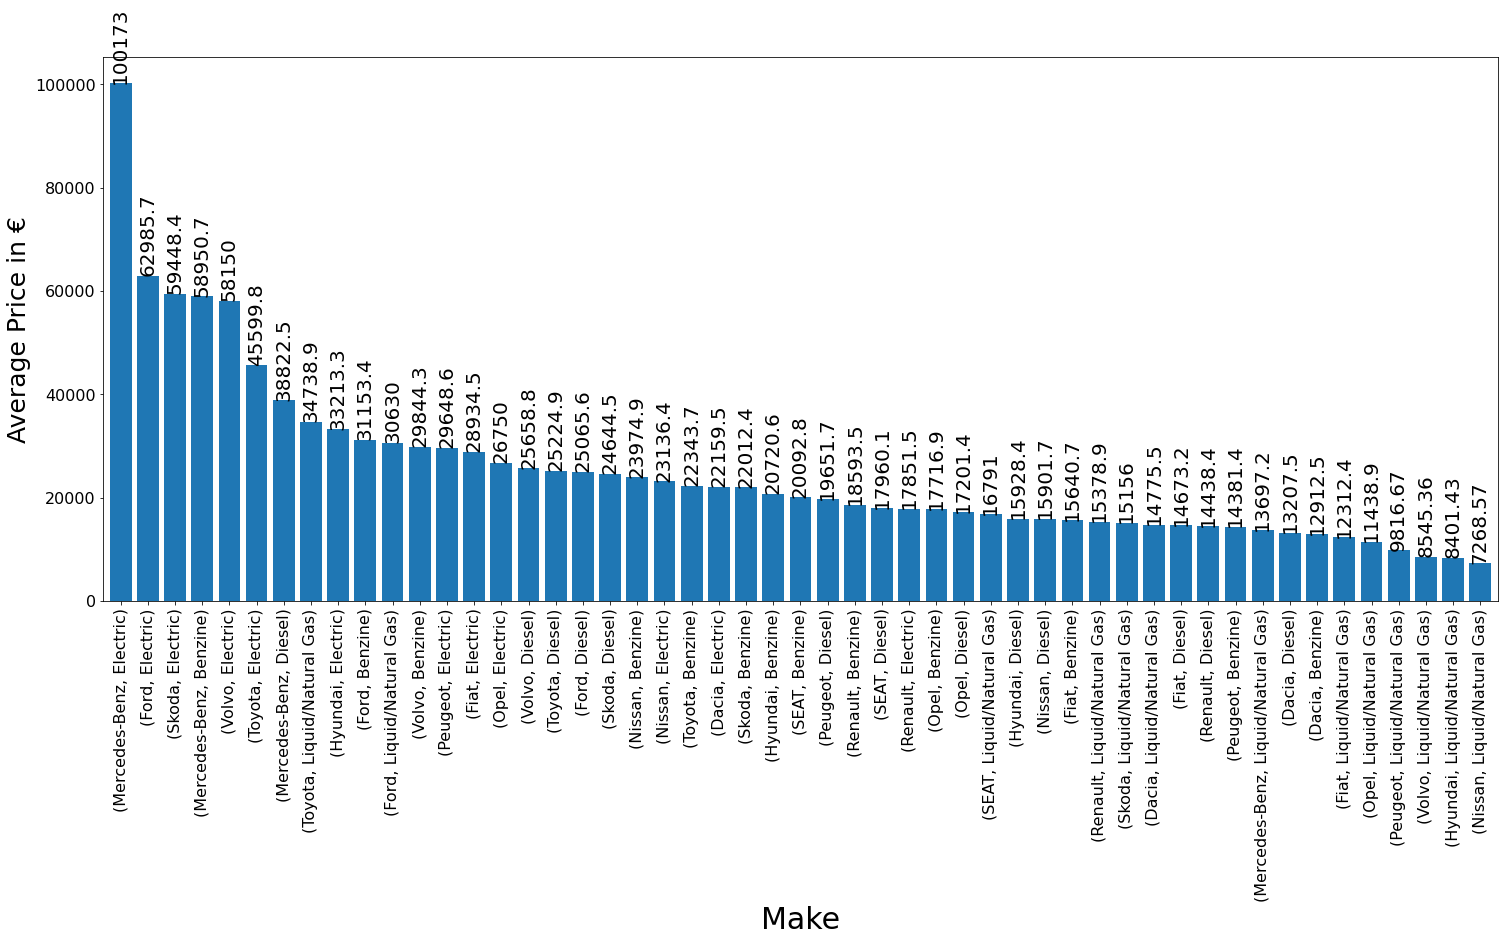

In [425]:
ax = avg_price_fuel_type2.plot.bar(figsize=(25, 10), fontsize=16, width=0.8, rot=90)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=90)
    
ax.set_xlabel('Make', fontsize=30)
ax.set_ylabel('Average Price in €', fontsize=25);
# plt.legend(title="fuel_type", title_fontsize=16, prop={'size': 16}, loc='best');

### 4. Which ``make & model`` has the ``highest`` number of vehicles for sale?

In [426]:
df["make_model"].value_counts().nlargest(1)

Renault Megane    825
Name: make_model, dtype: int64

In [427]:
num_sale = df["make_model"].value_counts()
num_sale_df = pd.DataFrame(num_sale).rename(columns={"make_model": "No of Sales"})
num_sale_df

,No of Sales
Renault Megane,825
SEAT Leon,757
Dacia Sandero,721
Hyundai i30,699
Opel Astra,634
...,...
Peugeot iOn,1
Peugeot,1
Mercedes-Benz GLB 180,1
Nissan Ariya,1


In [428]:
# Let us test the PARETO RULE

num_sale /= num_sale.sum()/100
category_classes = pd.qcut(num_sale, q=[0, .20, 0.80, 1.], 
                 labels=['Bottom 20%', 'Mid 60%', 'Top 20%'])
prob_groups = num_sale.groupby(category_classes).sum().sort_values(ascending=False)

display(prob_groups)
display(category_classes)

make_model
Top 20%       82.381313
Mid 60%       16.909156
Bottom 20%     0.709531
Name: make_model, dtype: float64

Renault Megane              Top 20%
SEAT Leon                   Top 20%
Dacia Sandero               Top 20%
Hyundai i30                 Top 20%
Opel Astra                  Top 20%
                            ...    
Peugeot iOn              Bottom 20%
Peugeot                  Bottom 20%
Mercedes-Benz GLB 180    Bottom 20%
Nissan Ariya             Bottom 20%
Dacia Break              Bottom 20%
Name: make_model, Length: 503, dtype: category
Categories (3, object): ['Bottom 20%' < 'Mid 60%' < 'Top 20%']

In [429]:
PARETO_category = pd.DataFrame(category_classes).rename(columns={0: "PARETO_category"})
PARETO_Rule = pd.merge(num_sale_df, PARETO_category, left_index=True, right_index=True).reset_index()\
                                            .rename(columns={"index": "make_model", "make_model": "Pareto_category"})

PARETO_Rule

# top20 = pd.DataFrame(category_classes[category_classes == "Top 20%"]).rename(columns={0: "Top 20%"})
# top20

,make_model,No of Sales,Pareto_category
0,Renault Megane,825,Top 20%
1,SEAT Leon,757,Top 20%
2,Dacia Sandero,721,Top 20%
3,Hyundai i30,699,Top 20%
4,Opel Astra,634,Top 20%
...,...,...,...
498,Peugeot iOn,1,Bottom 20%
499,Peugeot,1,Bottom 20%
500,Mercedes-Benz GLB 180,1,Bottom 20%
501,Nissan Ariya,1,Bottom 20%


In [430]:
top20 = PARETO_Rule[PARETO_Rule["Pareto_category"] == "Top 20%"]

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
make_model,Renault Megane,SEAT Leon,Dacia Sandero,Hyundai i30,Opel Astra,Ford Mustang,Peugeot 308,Nissan Qashqai,Ford Focus,SEAT Ibiza,...,Opel Mokka,Skoda Rapid/Spaceback,Dacia Lodgy,Mercedes-Benz A 45 AMG,Mercedes-Benz AMG GT,Peugeot 108,Renault Arkana,Toyota Supra,Nissan Leaf,Mercedes-Benz E 220
No of Sales,825,757,721,699,634,572,536,484,483,433,...,73,72,72,71,68,67,62,61,61,61
Pareto_category,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,...,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%,Top 20%


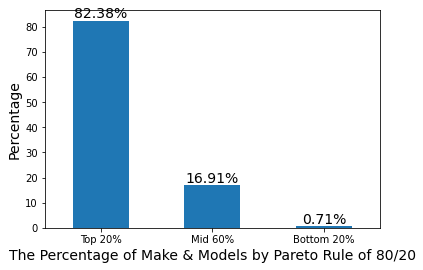

In [431]:
ax = prob_groups.plot(kind='bar')

display(top20.T)

for container in ax.containers:
    ax.bar_label(container, fontsize=14, rotation=0, fmt='%.2f%%')
    
ax.set_xlabel('The Percentage of Make & Models by Pareto Rule of 80/20', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)

plt.xticks(rotation=0)
plt.show()

### 5. Which vehicle ``make & models`` has the ``lowest`` ``average`` ``fuel consumption`` ``by body_type`` and What are their ``fuel_types``?

In [432]:
# Minimum Fuel Consumption of Vehicles by body_type & make_model

cons_avg = df.groupby(["make_model", "body_type", "fuel_type"]).cons_avg.min()
cons_avg

make_model    body_type         fuel_type
Dacia         Compact           Benzine      5.600
              Station wagon     Benzine      5.600
Dacia Break   Station wagon     Benzine      5.300
Dacia Dokker  Compact           Diesel       4.200
              Off-Road/Pick-up  Benzine      6.300
                                             ...  
Volvo XC90    Off-Road/Pick-up  Benzine      1.200
                                Diesel       1.500
                                Electric     2.359
              Sedan             Diesel       6.700
              Station wagon     Diesel       5.700
Name: cons_avg, Length: 1542, dtype: float64

In [433]:
# Average Price by make & fuel_type

avg_price_fuel_type = df.groupby(["make", "fuel_type"]).price.mean().sort_values(ascending=False)
avg_price_fuel_type

make           fuel_type         
Mercedes-Benz  Electric              100173.353846
Ford           Electric               62985.652174
Skoda          Electric               59448.437500
Mercedes-Benz  Benzine                58950.722963
Volvo          Electric               58150.000000
Toyota         Electric               45599.800000
Mercedes-Benz  Diesel                 38822.480969
Toyota         Liquid/Natural Gas     34738.900000
Hyundai        Electric               33213.333333
Ford           Benzine                31153.449938
               Liquid/Natural Gas     30630.000000
Volvo          Benzine                29844.283916
Peugeot        Electric               29648.562500
Fiat           Electric               28934.522388
Opel           Electric               26750.000000
Volvo          Diesel                 25658.782019
Toyota         Diesel                 25224.855895
Ford           Diesel                 25065.555556
Skoda          Diesel                 24644.4836

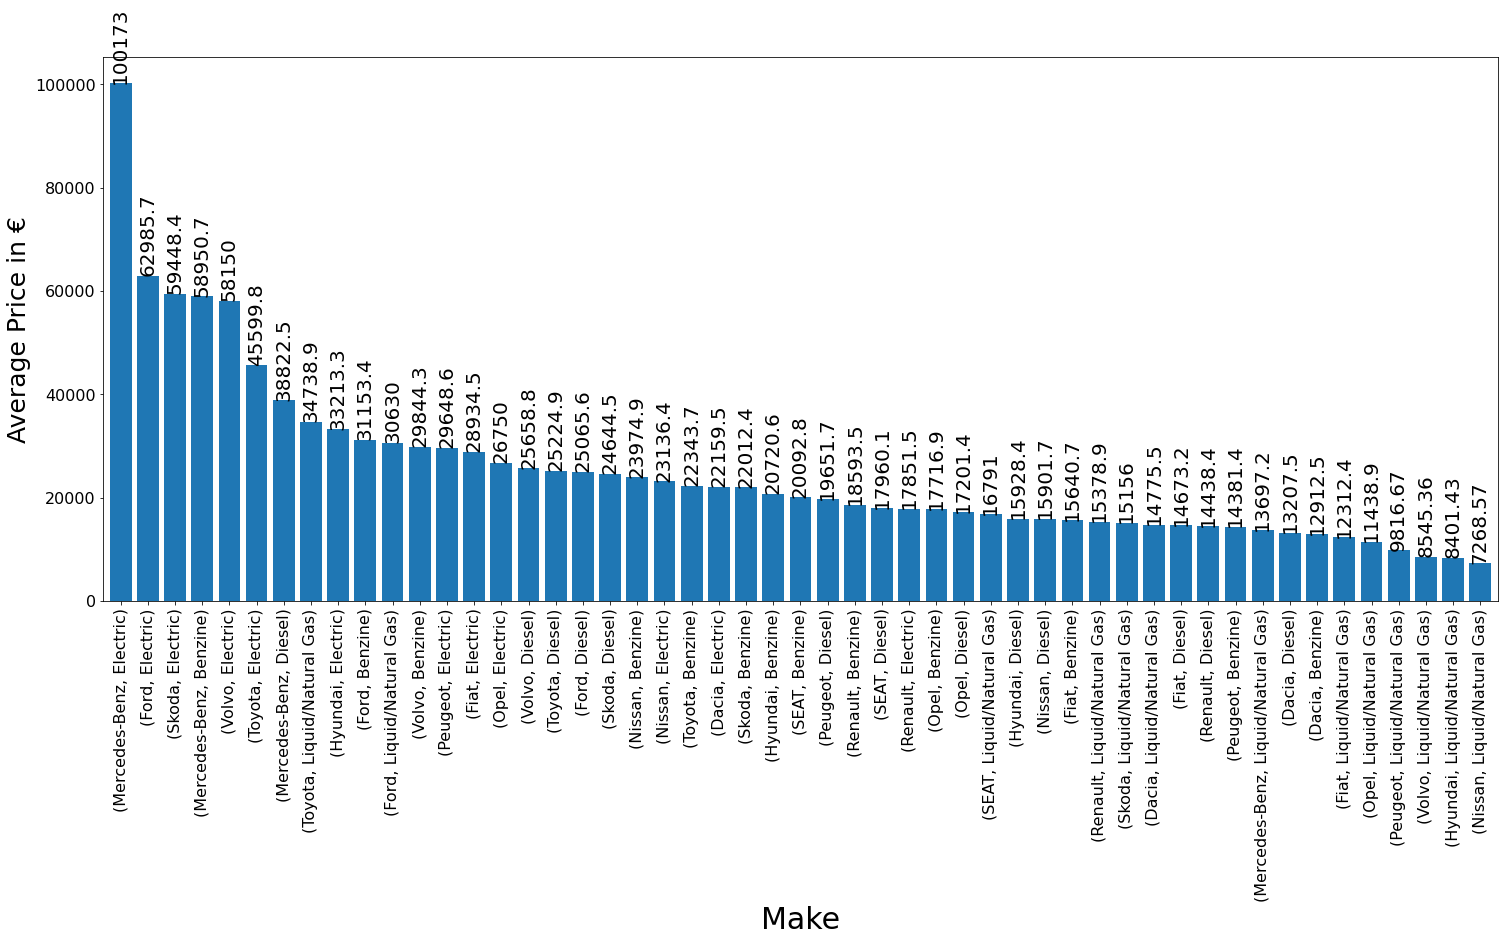

In [434]:
ax = avg_price_fuel_type.plot.bar(figsize=(25, 10), fontsize=16, width=0.8, rot=90)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=90)
    
ax.set_xlabel('Make', fontsize=30);
ax.set_ylabel('Average Price in €', fontsize=25);

In [435]:
# Average fuel_consumption by make & fuel_type

avg_fuel_cons = df.groupby(["make", "fuel_type"]).cons_avg.mean().sort_values(ascending=True)
avg_fuel_cons

make           fuel_type         
Toyota         Liquid/Natural Gas     1.700000
Hyundai        Electric               2.359000
Peugeot        Electric               2.359000
Nissan         Electric               2.359000
Skoda          Electric               2.359000
Ford           Electric               2.359000
Renault        Electric               2.359000
Volvo          Electric               2.359000
Fiat           Electric               2.359000
Opel           Electric               2.359000
Dacia          Electric               2.359000
Toyota         Electric               2.359000
Mercedes-Benz  Electric               2.359000
Skoda          Liquid/Natural Gas     3.940000
Dacia          Diesel                 4.151168
SEAT           Liquid/Natural Gas     4.178000
Fiat           Diesel                 4.214410
Peugeot        Diesel                 4.217263
SEAT           Diesel                 4.434354
Renault        Diesel                 4.455195
Skoda          Diesel     

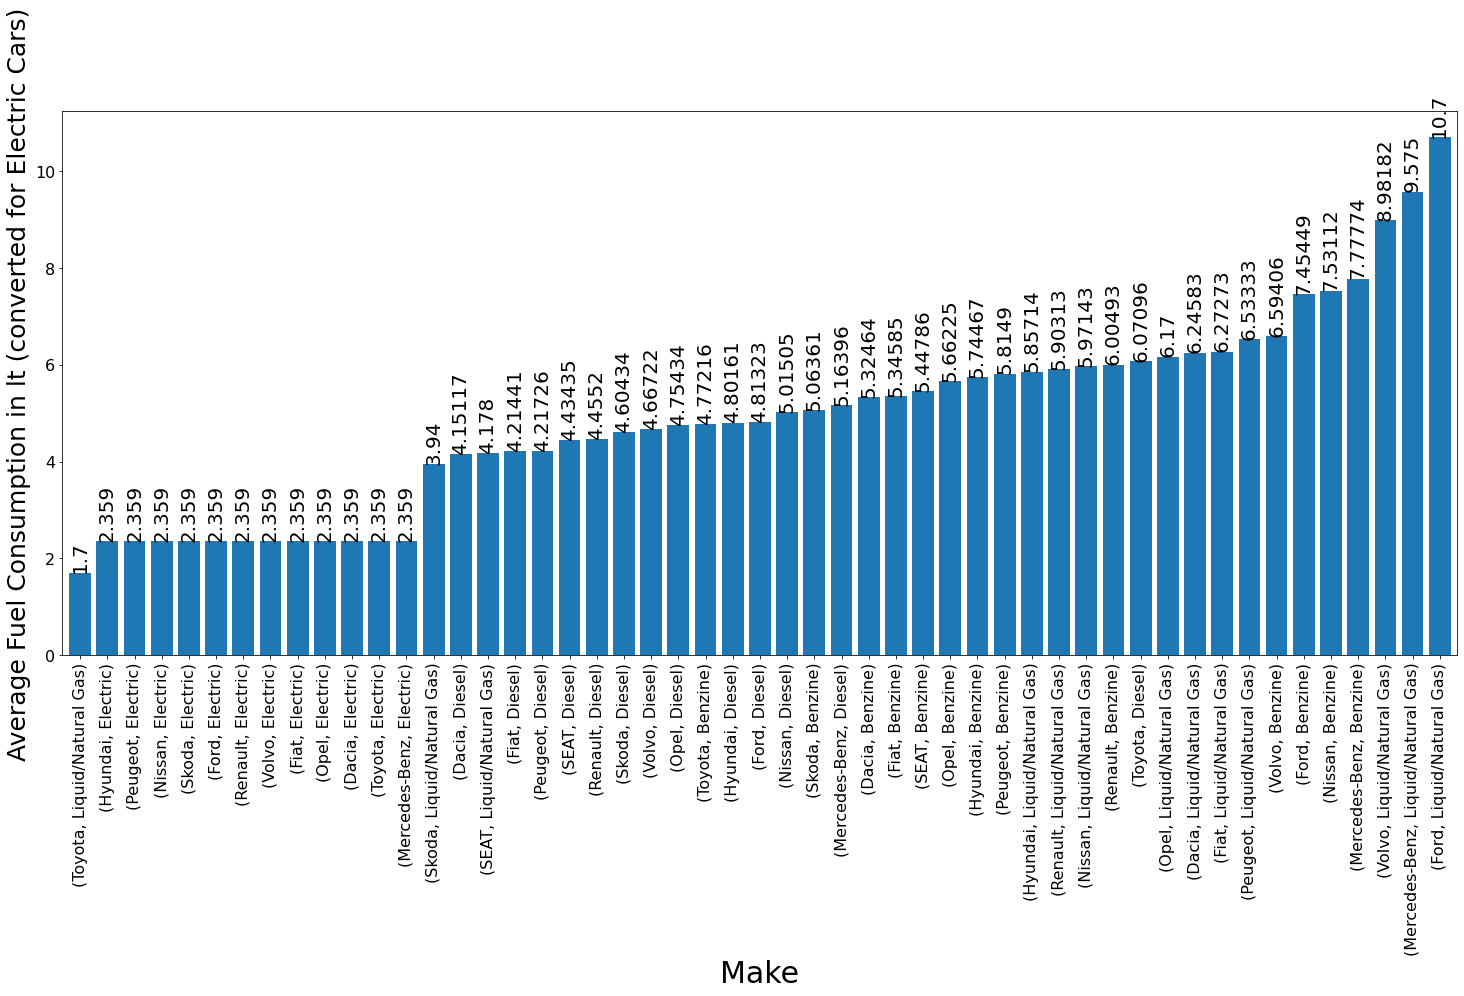

In [436]:
ax = avg_fuel_cons.plot.bar(figsize=(25, 10), fontsize=16, width=0.8, rot=90)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=90)
    
ax.set_xlabel('Make', fontsize=30);
ax.set_ylabel('Average Fuel Consumption in lt (converted for Electric Cars)', fontsize=25);

In [437]:
# ax = cons_avg.unstack(level=0).plot.bar(figsize=(20, 8), fontsize=14, width=0.9, rot=60)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=12, rotation=90)
    
# ax.set_xlabel('Body & fuel_type', fontsize=30)
# ax.set_ylabel('Average Consumption', fontsize=30)
# plt.legend(title="Make & Model", title_fontsize=12, prop={'size': 10}, bbox_to_anchor=(0.2, 0.7));

In [438]:
# ax = cons_avg.unstack(level=2).plot.bar(figsize=(20, 8), fontsize=14, width=0.9, rot=90)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=12, rotation=90)
    
# ax.set_xlabel('Make-Model & Body Type', fontsize=30)
# ax.set_ylabel('Average Consumption', fontsize=30)
# plt.legend(title="fuel_type", title_fontsize=16, prop={'size': 14});

### 6. What are the ``lowest`` and ``highest`` sales ``prices`` of the vehicles according to the ``make & model``? What is the ``selling price`` ``difference`` for each ``make & model`` group. Which vehicle group has the ``biggest price difference``?

In [439]:
df.groupby(["make_model"]).price.min()

make_model
Dacia                      19515.0
Dacia Break                20500.0
Dacia Dokker                3890.0
Dacia Duster                4800.0
Dacia Jogger               18160.0
                            ...   
Volvo V90 Cross Country    28190.0
Volvo XC40                 25480.0
Volvo XC60                  9990.0
Volvo XC70                  8750.0
Volvo XC90                  6400.0
Name: price, Length: 503, dtype: float64

In [440]:
df.groupby(["make_model"]).price.max()

make_model
Dacia                      22479.0
Dacia Break                20500.0
Dacia Dokker               19997.0
Dacia Duster               29950.0
Dacia Jogger               26298.0
                            ...   
Volvo V90 Cross Country    71850.0
Volvo XC40                 68990.0
Volvo XC60                 83890.0
Volvo XC70                 29990.0
Volvo XC90                 97450.0
Name: price, Length: 503, dtype: float64

In [441]:
min_max_price = df.groupby(["make"]).agg({'price': ['max', 'min']}).sort_values(by=("price", 'max'), ascending=False)
min_max_price

price        
                    max     min
make                           
Ford           549000.0  1075.0
Mercedes-Benz  375900.0  1790.0
Nissan         237500.0  1000.0
Volvo           97450.0  1600.0
Renault         81980.0   490.0
Toyota          80490.0  1200.0
Hyundai         75991.0   700.0
Skoda           74490.0  1400.0
Peugeot         64290.0   790.0
Opel            59990.0   800.0
SEAT            51990.0   999.0
Fiat            41570.0  1199.0
Dacia           29950.0  1490.0

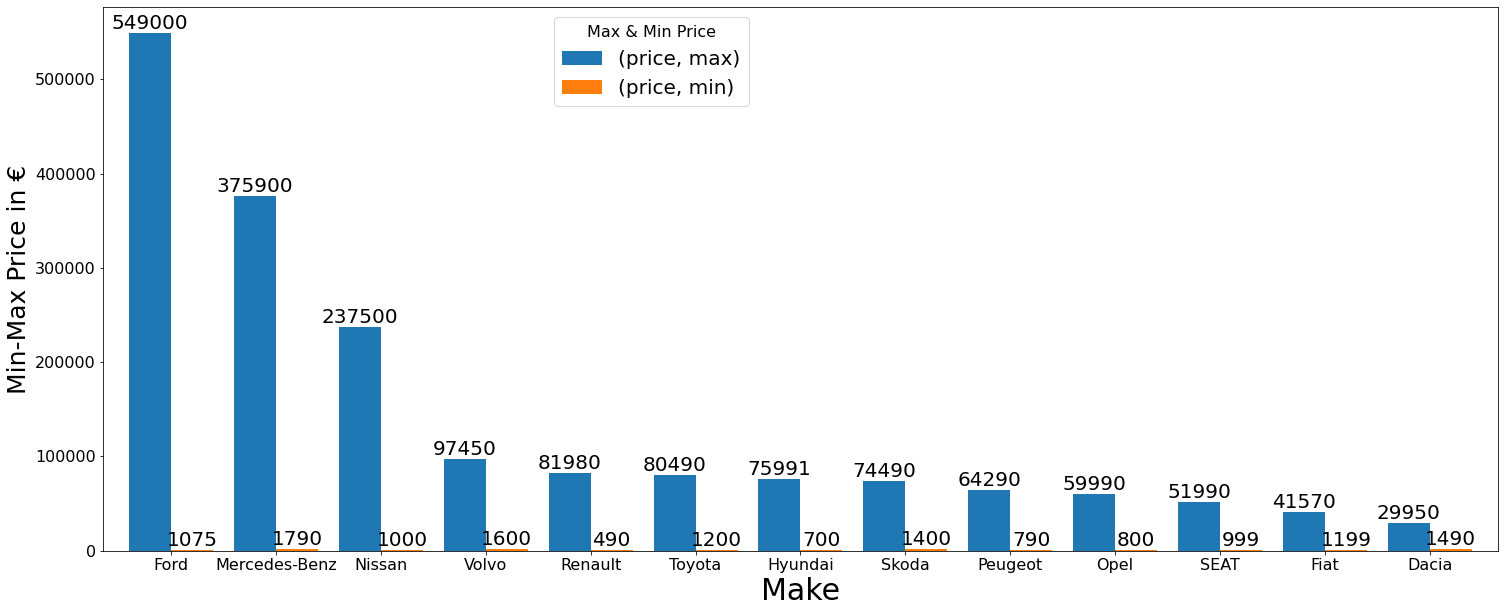

In [442]:
ax = min_max_price.plot.bar(figsize=(25, 10), fontsize=16, width=0.8, rot=0)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=0)
    
ax.set_xlabel('Make', fontsize=30);
ax.set_ylabel('Min-Max Price in €', fontsize=25)

plt.legend(title="Max & Min Price", title_fontsize=16, prop={'size': 20}, bbox_to_anchor=(0.47, 1));

**Let us also see the Price differences for each Make & Model in the plot.**

In [443]:
min_max_price.columns

MultiIndex([('price', 'max'),
            ('price', 'min')],
           )

In [444]:
min_max_price['price', 'difference'] = min_max_price['price', 'max'] - min_max_price['price', 'min']
min_max_price.sort_values(by=('price', 'difference'), ascending=False)

price                   
                    max     min difference
make                                      
Ford           549000.0  1075.0   547925.0
Mercedes-Benz  375900.0  1790.0   374110.0
Nissan         237500.0  1000.0   236500.0
Volvo           97450.0  1600.0    95850.0
Renault         81980.0   490.0    81490.0
Toyota          80490.0  1200.0    79290.0
Hyundai         75991.0   700.0    75291.0
Skoda           74490.0  1400.0    73090.0
Peugeot         64290.0   790.0    63500.0
Opel            59990.0   800.0    59190.0
SEAT            51990.0   999.0    50991.0
Fiat            41570.0  1199.0    40371.0
Dacia           29950.0  1490.0    28460.0

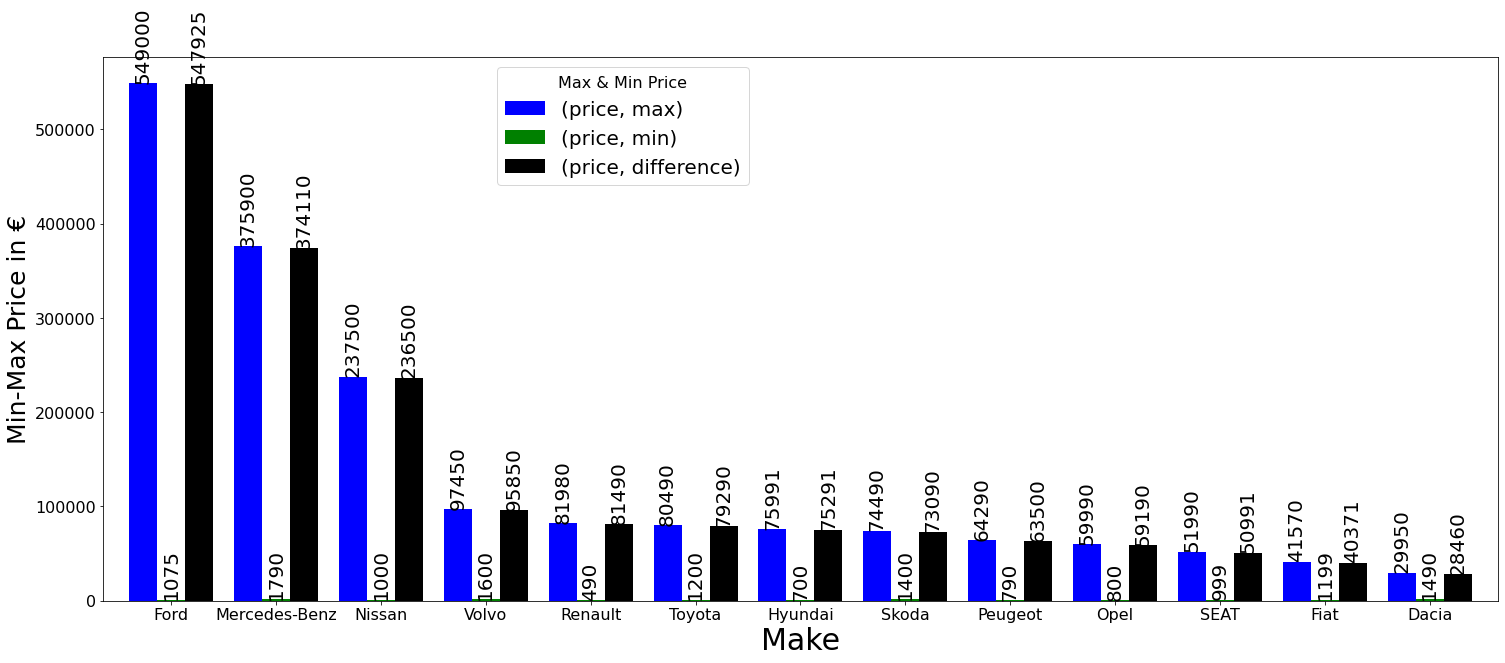

In [445]:
from itertools import cycle, islice

# Make a list by cycling through the colors we care about to match the length of our data.
my_colors = list(islice(cycle(['b', 'g', 'k']), None, len(min_max_price)))

ax = min_max_price.plot.bar(figsize=(25, 10), fontsize=16, width=0.8, rot=0, color=my_colors)

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=90)
    
ax.set_xlabel('Make', fontsize=30);
ax.set_ylabel('Min-Max Price in €', fontsize=25)

plt.legend(title="Max & Min Price", title_fontsize=16, prop={'size': 20}, bbox_to_anchor=(0.47, 1));

### 7. What is the ``average`` selling ``price`` of vehicles whose ``make & model`` is ``Ford Fiesta`` and ``body_type`` is ``Sedan``?

In [446]:
df[(df["make_model"] == "Ford Fiesta") & (df["body_type"] == "Sedan")].price.mean()

17408.605095541403

### 8. What are the ``average``, ``minimum`` and ``maximum`` selling ``prices`` of vehicles by ``body_type``?

In [447]:
# Average, minimum, and maximum price for sale by make_maodel & body_type

df.groupby(['make_model', 'body_type']).agg({'price': ['mean', 'min', 'max']})

price                  
                                       mean      min      max
make_model   body_type                                       
Dacia        Compact           21431.000000  19515.0  22479.0
             Station wagon     21799.000000  21799.0  21799.0
Dacia Break  Station wagon     20500.000000  20500.0  20500.0
Dacia Dokker Compact           11930.000000  11930.0  11930.0
             Off-Road/Pick-up  12490.000000  12490.0  12490.0
...                                     ...      ...      ...
Volvo XC70   Station wagon     21905.666667   8750.0  29990.0
Volvo XC90   Coupe             49900.000000  49900.0  49900.0
             Off-Road/Pick-up  51102.294118   6400.0  97450.0
             Sedan             60366.666667  47700.0  84900.0
             Station wagon     32750.000000  29500.0  36000.0

[1073 rows x 3 columns]

In [448]:
# Average, minimum, and maximum price for sale by body_type

min_max_avg_price = df.groupby(['body_type']).agg({'price': ['max', 'min', 'mean']}).sort_values(by=('price', 'max'), ascending=False)
min_max_avg_price

price                      
                       max     min          mean
body_type                                       
Coupe             549000.0   490.0  30300.197691
Off-Road/Pick-up  375900.0  3295.0  29432.908296
Convertible       283900.0   699.0  21127.275690
Sedan             188008.0   999.0  22672.017411
Compact           184900.0   950.0  15994.584437
Station wagon     177879.0   790.0  22258.382736

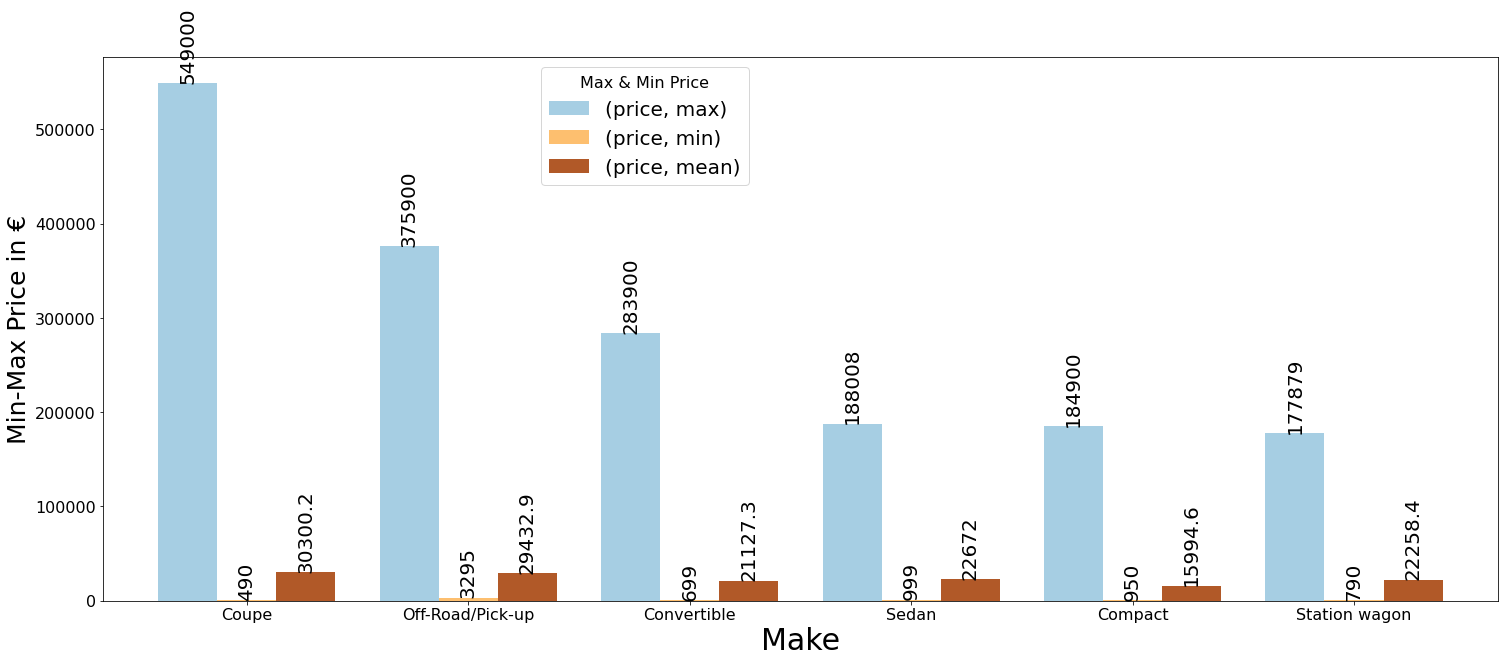

In [449]:
ax = min_max_avg_price.plot.bar(figsize=(25, 10), fontsize=16, width=0.8, rot=0, colormap='Paired')

for container in ax.containers:
    ax.bar_label(container, fontsize=20, rotation=90)
    
ax.set_xlabel('Make', fontsize=30);
ax.set_ylabel('Min-Max Price in €', fontsize=25)

plt.legend(title="Max & Min Price", title_fontsize=16, prop={'size': 20}, bbox_to_anchor=(0.47, 1));

### 9. What is the ``make_model`` of the vehicles whose sales ``price`` is ``between 59000 and 60000`` in € (inclusive)?

In [450]:
df[(df.price >= 59000) & (df.price <= 60000)]["make_model"].unique()

array(['Mercedes-Benz A 35 AMG', 'Mercedes-Benz C 43 AMG',
       'Mercedes-Benz C 400', 'Mercedes-Benz E 220',
       'Mercedes-Benz E 300', 'Mercedes-Benz E 400',
       'Mercedes-Benz E 53 AMG', 'Mercedes-Benz GLE 300',
       'Mercedes-Benz GLC 300', 'Mercedes-Benz GLA 45 AMG',
       'Mercedes-Benz C 63 AMG', 'Mercedes-Benz C 220',
       'Mercedes-Benz S 450', 'Mercedes-Benz A 45 AMG',
       'Mercedes-Benz S 350', 'Mercedes-Benz S 400',
       'Mercedes-Benz S 63 AMG', 'Opel Movano', 'Renault Alpine A110',
       'Renault Clio', 'Peugeot Traveller', 'Peugeot 508', 'Toyota Supra',
       'Toyota Highlander', 'Toyota RAV 4', 'Toyota Proace',
       'Nissan GT-R', 'Ford Mustang', 'Ford Ranger', 'Hyundai IONIQ 5',
       'Volvo XC90', 'Volvo XC60', 'Volvo V60', 'Volvo V90', 'Volvo S60',
       'Volvo S90'], dtype=object)

### 10. What is the most common ``gearbox`` type among the vehicles for sale whose ``make & model`` is ``Peugeot 508`` and ``body`` is ``Sedan``?

In [451]:
df[(df["make_model"] == "Peugeot 508") & (df["body_type"] == "Sedan")].gearbox.mode()

0    Automatic
Name: gearbox, dtype: object

## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">An Analysis of Inferential Statistics/Hypothesis Testing on Some Specific Features</p>

<a id="4"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

In [452]:
df0.select_dtypes(exclude=["number", "bool_"]).head(3)

,make_model,make,location,body_type,type,warranty,gearbox,fuel_type,seller,drivetrain,extras,full_service_history,upholstery,energy_efficiency_class,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package
0,Mercedes-Benz A 160,Mercedes-Benz,"P.I. EL PALMAR C/FORJA 6, 11500 PUERTO DE SAN...",Compact,Used,Yes,Manual,Diesel,Dealer,Front,Alloy wheels,No,Cloth,efficient,Standard,Standard,Safety Premium Package
1,Mercedes-Benz EQE 350,Mercedes-Benz,"APARTADO DE CORREOS 1032, 26140 LOGROÑO, ES",Compact,Pre-registered,Yes,Automatic,Electric,Dealer,4WD,"Alloy wheels (21""), Shift paddles, Sport packa...",No,Part/Full Leather,efficient,Premium,Plus,Safety Premium Package
2,Mercedes-Benz A 45 AMG,Mercedes-Benz,"PORT. TARRACO, MOLL DE LLEVANT, Nº 5, LOC. 6-8...",Compact,Used,Yes,Automatic,Benzine,Dealer,4WD,Alloy wheels,No,Part/Full Leather,unefficient,Standard,Standard,Safety Premium Plus Package


As seen above, there are many categorical features in the dataset such as ``"make_model"``, ``"make"``, ``"body_type"``, ``"type"``, ``"warranty"``, ``"gearbox"``, ``"fuel_type"``, ``"seller"``, etc. We will be using some of these features and check whether one feature effect affects other features using several tests i.e ``Z-Test``, ``correlation test``, ``ANOVA test``, and ``Chi-square test``.

### ANOVA:

ANOVA stands for Analysis Of Variance. Actually, this test measures if there are any significant differences between the means of the values of the numeric variable for each categorical value. This is something that you can visualize using a box plot as well.

In the below example, we are trying to measure if there is any correlation between fuel types on car prices. Here **``fuel_type``** is a categorical predictor and **``price`**` is the numeric target/label variable.

### Is there statistacally any correlation between fuel types on car prices❓

In [453]:
# f_oneway() function takes the group data as input and returns F-statistic and P-value
from scipy.stats import f_oneway
 
# Running the one-way anova test between price and fuel_type
# Assumption(H0) is that fuel_type and price are NOT correlated
# H0: μ1 = μ2 = μ3 ... = μk (Means are all equal)

print(f"Null Hypothesis: There is NO significant difference between the mean price among different groups of dependents.")
print(f"Alternate  Hypothesis: There is significant difference between the mean price among different groups of dependents.")
print("*"*120)
 
# Finds out the price for each fuel_type as a list
CategoryGroupLists = df0.groupby('fuel_type')['price'].apply(list)
 
# Performing the ANOVA test
# We accept/fail to reject the Assumption(H0) only when P-Value > 0.05
AnovaResults = f_oneway(*CategoryGroupLists)

print('F-Value for Anova is: ', AnovaResults[0], '\nP-Value for Anova is: ', AnovaResults[1])
print("*"*45)

# Defining significance level
alpha = 0.05

if AnovaResults[1] <= alpha:
    print(f"Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected.\nCONCLUSION:\nThere is a statistically significant difference between the groups and their effects on price F={AnovaResults[0]}, p-value={AnovaResults[1]}")
else:
    print(f"Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is failed to reject/accepted.\nCONCLUSION:\nThere is NO a statistically significant difference between the groups and their effects on price F={AnovaResults[0]}, p-value={AnovaResults[1]}")     

Null Hypothesis: There is NO significant difference between the mean price among different groups of dependents.
Alternate  Hypothesis: There is significant difference between the mean price among different groups of dependents.
************************************************************************************************************************
F-Value for Anova is:  98.25371382605583 
P-Value for Anova is:  2.861879775472066e-63
*********************************************
Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected.
CONCLUSION:
There is a statistically significant difference between the groups and their effects on price F=98.25371382605583, p-value=2.861879775472066e-63


In [454]:
AnovaResults

F_onewayResult(statistic=98.25371382605583, pvalue=2.861879775472066e-63)

The Null hypothesis in the ANOVA test is; **Ho: Two variables are NOT correlated.**<br>
Hence, if the p-value comes as 0, we will reject H0 and say the variables are correlated with each other.

**As the output of the P-value is almost zero, hence, we reject H0. Which means the variables are correlated with each other.**

🔥 👉 P-Value of 6.285388473498683e-63 means 6.285388473498683×10−63. For example; e-5 just means x 10^(-5), i.e. divided by 100000.

**[How to measure the correlation between a numeric and a categorical variable in Python](https://thinkingneuron.com/how-to-measure-the-correlation-between-a-numeric-and-a-categorical-variable-in-python/)**

Now in the below example, we are trying to measure if there is any correlation between body types on car prices. Here **``bodyl_type``** is a categorical predictor and **``price`**` is the numeric target/label variable.

### Is there statistically any correlation between body types on car prices❓

In [455]:
# f_oneway() function takes the group data as input and returns F-statistic and P-value
from scipy.stats import f_oneway
 
# Running the one-way anova test between price and body_type
# Assumption(H0) is that body_type and price are NOT correlated
# H0: μ1 = μ2 = μ3 ... = μk (Means are all equal)

print(f"Null Hypothesis: There is NO significant difference between the mean price among different groups of dependents.")
print(f"Alternate  Hypothesis: There is significant difference between the mean price among different groups of dependents.")
print("*"*120)
 
# Finds out the price for each fuel_type as a list
CategoryGroupLists = df0.groupby('body_type')['price'].apply(list)
 
# Performing the ANOVA test
# We accept/fail to reject the Assumption(H0) only when P-Value > 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('F-Value for Anova is: ', AnovaResults[0], '\nP-Value for Anova is: ', AnovaResults[1])
print("*"*45)

# Defining significance level
alpha = 0.05

if AnovaResults[1] <= alpha:
    print(f"Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected.\nCONCLUSION:\nThere is a statistically significant difference between the groups and their effects on price F={AnovaResults[0]}, p-value={AnovaResults[1]}")
else:
    print(f"Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is failed to reject/accepted.\nCONCLUSION:\nThere is NO a statistically significant difference between the groups and their effects on price F={AnovaResults[0]}, p-value={AnovaResults[1]}")     

Null Hypothesis: There is NO significant difference between the mean price among different groups of dependents.
Alternate  Hypothesis: There is significant difference between the mean price among different groups of dependents.
************************************************************************************************************************
F-Value for Anova is:  253.62130822126625 
P-Value for Anova is:  4.091167952928636e-266
*********************************************
Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected.
CONCLUSION:
There is a statistically significant difference between the groups and their effects on price F=253.62130822126625, p-value=4.091167952928636e-266


**As the output of the P-value is almost zero, hence, we reject H0. Which means the variables are correlated with each other.**

In [456]:
df0['make'].unique()

array(['Mercedes-Benz', 'Opel', 'Renault', 'Peugeot', 'Fiat', 'SEAT',
       'Skoda', 'Dacia', 'Toyota', 'Nissan', 'Ford', 'Hyundai', 'Volvo'],
      dtype=object)

### Is there statistically any correlation between some of car makes (Mercedes-Benz, Opel, Volvo) on car prices❓

In [457]:
# f_oneway() function takes the group data as input and returns F-statistic and P-value
from scipy.stats import f_oneway

# derive the groups (i.e. types of makes)
groups = pd.unique(df0.make.values)

# Create a dictionary to hold respective price of the types of make groups
statData = {grp: df0['price'][df0['make'] == grp] for grp in groups}
F, p = stats.f_oneway(statData['Mercedes-Benz'], statData['Opel'], statData['Volvo'])

print('F-Value for Anova is: ', F, '\nP-Value for Anova is: ', p)
print("*"*45)

# Defining significance level
alpha = 0.05

if AnovaResults[1] <= alpha:
    print(f"Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected.\nCONCLUSION:\nThere is a statistically significant difference between the groups and their effects on price F={F}, p-value={p}")
else:
    print(f"Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is failed to reject/accepted.\nCONCLUSION:\nThere is NO a statistically significant difference between the groups and their effects on price F={F}, p-value={p}")     

F-Value for Anova is:  871.4043839940206 
P-Value for Anova is:  0.0
*********************************************
Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected.
CONCLUSION:
There is a statistically significant difference between the groups and their effects on price F=871.4043839940206, p-value=0.0


**Interpretation of results:**

The null hypothesis is rejected, with a p-value less than 0.05. There is a significant difference between the price of the analyzed groups of make.

**[Navigating Statistical Tests](https://towardsdatascience.com/levels-of-measurement-statistics-and-python-implementations-8ff8e7867d0b)**

### z-test & t-test

**``Z-test``** is the statistical test, used to analyze whether two population means are different or not when the variances are known and the sample size is large. This test statistic is assumed to have a normal distribution, and **standard deviation** must be **known** to perform an accurate z-test.

A z-statistic, or z-score, is a number representing the value’s relationship to the mean of a group of values, it is measured with population parameters such as population standard deviation and used to validate a hypothesis. For example, the null hypothesis is “sample mean is the same as the population mean”, and alternative hypothesis is “the sample mean  is not the same as the population mean”. Z-test is not prefered to be implemented when the sample size is less than 30.

In order to know how significant the difference between two groups are, **``T-test``** is used, basically it tells that difference (measured in means) between two separate groups could have occurred by chance. This test assumes to have a normal distribution while based on t-distribution, and **population parameters such as mean, or standard deviation** are **unknown**.

The ratio between the difference between two groups and the difference within the group is known as T-score. Greater is the t-score, more is the difference between groups, and smaller is the t-score, more similarities are there among groups. For example, a t-score value of 2 indicates that the groups are two times as different from each other as they are with each other.

**Key Differences between t-test and z-test can be drawn clearly on the following grounds:**
 - The t-test can be understood as a statistical test which is used to compare and analyse whether the means of the two population is different from one another or not when the standard deviation is not known. As against, Z-test is a parametric test, which is applied when the standard deviation is known, to determine, if the means of the two datasets differ from each other.
 - The t-test is based on Student’s t-distribution. On the contrary, z-test relies on the assumption that the distribution of sample means is normal. Both student’s t-distribution and normal distribution appear alike, as both are symmetrical and bell-shaped. However, they differ in the sense that in a t-distribution, there is less space in the centre and more in the tails.
 - One of the important conditions for adopting t-test is that population variance is unknown. Conversely, population variance should be known or assumed to be known in case of a z-test.
 - Z-test is used to when the sample size is large, i.e. n > 30, and t-test is appropriate when the size of the sample is small, in the sense that n < 30.

### Is there statistically significant difference in price among the groups of car makes❓

In [458]:
df0.make.unique()

array(['Mercedes-Benz', 'Opel', 'Renault', 'Peugeot', 'Fiat', 'SEAT',
       'Skoda', 'Dacia', 'Toyota', 'Nissan', 'Ford', 'Hyundai', 'Volvo'],
      dtype=object)

**Let us calculate the ``mean`` of each make for price:**

In [459]:
Mercedes_mean = df0.loc[df0['make'] == 'Mercedes-Benz', 'price'].mean()
Opel_mean = df0.loc[df0['make'] == 'Opel', 'price'].mean()
Renault_mean = df0.loc[df0['make'] == 'Renault', 'price'].mean()
Peugeot_mean = df0.loc[df0['make'] == 'Peugeot', 'price'].mean()
Fiat_mean = df0.loc[df0['make'] == 'Fiat', 'price'].mean()
SEAT_mean = df0.loc[df0['make'] == 'SEAT', 'price'].mean()
Skoda_mean = df0.loc[df0['make'] == 'Skoda', 'price'].mean()
Dacia_mean = df0.loc[df0['make'] == 'Dacia', 'price'].mean()
Toyota_mean = df0.loc[df0['make'] == 'Toyota', 'price'].mean()
Nissan_mean = df0.loc[df0['make'] == 'Nissan', 'price'].mean()
Ford_mean = df0.loc[df0['make'] == 'Ford', 'price'].mean()
Hyundai_mean = df0.loc[df0['make'] == 'Hyundai', 'price'].mean()
Volvo_mean = df0.loc[df0['make'] == 'Volvo', 'price'].mean()

In [460]:
# print("The Price Mean of Mercedes-Benz make is", Mercedes_mean, "€")
# print("The Price Mean of Opel make is", Opel_mean, "€")
# print("The Price Mean of Renault make is", Renault_mean, "€")
# print("The Price Mean of Peugeot make is", Peugeot_mean, "€")
# print("The Price Mean of Fiat make is", Fiat_mean, "€")
# print("The Price Mean of SEAT make is", SEAT_mean, "€")
# print("The Price Mean of Skoda make is", Skoda_mean, "€")
# print("The Price Mean of Dacia make is", Dacia_mean, "€")
# print("The Price Mean of Toyota make is", Toyota_mean, "€")
# print("The Price Mean of Nissan make is", Nissan_mean, "€")
# print("The Price Mean of Ford make is", Ford_mean, "€")
# print("The Price Mean of Hyundai make is", Hyundai_mean, "€")
# print("The Price Mean of Volvo make is", Volvo_mean, "€")

def displaymean(df, group_col, target_col):
    mean_lst = []
    for group in df[group_col].unique():
        cond = df[group_col] == group
        unique_mean = df[cond][target_col].mean()
        mean_lst.append(unique_mean)
#     print(mean_lst)
        print("The Price Mean of", group, "is", unique_mean)
        
displaymean(df0, "make", "price") 

The Price Mean of Mercedes-Benz is 52398.824020016684
The Price Mean of Opel is 17063.384905660376
The Price Mean of Renault is 17411.98766482348
The Price Mean of Peugeot is 16469.12118644068
The Price Mean of Fiat is 15896.91745081266
The Price Mean of SEAT is 19427.01835915089
The Price Mean of Skoda is 23650.35312899106
The Price Mean of Dacia is 13874.427456083278
The Price Mean of Toyota is 22166.600098135426
The Price Mean of Nissan is 21946.21511627907
The Price Mean of Ford is 31213.901462994836
The Price Mean of Hyundai is 19541.789501874664
The Price Mean of Volvo is 26489.72806777808


**Let us calculate the ``standard deviation`` of each make for price:**

In [461]:
Mercedes_std = df0.loc[df0['make'] == 'Mercedes-Benz', 'price'].std()
Opel_std = df0.loc[df0['make'] == 'Opel', 'price'].std()
Renault_std = df0.loc[df0['make'] == 'Renault', 'price'].std()
Peugeot_std = df0.loc[df0['make'] == 'Peugeot', 'price'].std()
Fiat_std = df0.loc[df0['make'] == 'Fiat', 'price'].std()
SEAT_std = df0.loc[df0['make'] == 'SEAT', 'price'].std()
Skoda_std = df0.loc[df0['make'] == 'Skoda', 'price'].std()
Dacia_std = df0.loc[df0['make'] == 'Dacia', 'price'].std()
Toyota_std = df0.loc[df0['make'] == 'Toyota', 'price'].std()
Nissan_std = df0.loc[df0['make'] == 'Nissan', 'price'].std()
Ford_std = df0.loc[df0['make'] == 'Ford', 'price'].std()
Hyundai_std = df0.loc[df0['make'] == 'Hyundai', 'price'].std()
Volvo_std = df0.loc[df0['make'] == 'Volvo', 'price'].std()

# for make in df0.make.unique():
#     make_std = df0.loc[df0['make'] == make, 'price'].std()
#     print("The Standard Deviation of", make, "make is", make_std)

def displaystd(df, group_col, target_col):
    for group in df[group_col].unique():
        cond = df[group_col] == group
        unique_std = df[cond][target_col].std()
#         print(unique_std)
        print("The Standard Deviation of", group, "is", unique_std)
        
displaystd(df0, "make", "price")        

The Standard Deviation of Mercedes-Benz is 43613.08953245111
The Standard Deviation of Opel is 9570.483993783982
The Standard Deviation of Renault is 14143.09994766475
The Standard Deviation of Peugeot is 11323.723310440806
The Standard Deviation of Fiat is 10103.102471321787
The Standard Deviation of SEAT is 9049.450614002883
The Standard Deviation of Skoda is 11118.462028292477
The Standard Deviation of Dacia is 5409.182169690417
The Standard Deviation of Toyota is 14390.282528682923
The Standard Deviation of Nissan is 22990.80995135525
The Standard Deviation of Ford is 33265.92155995493
The Standard Deviation of Hyundai is 10649.16087114497
The Standard Deviation of Volvo is 29304.985281584126


**Let us calculate the ``number`` of each make:**

In [462]:
Mercedes_num = df0.loc[df0['make'] == 'Mercedes-Benz', 'price'].count()
Opel_num = df0.loc[df0['make'] == 'Opel', 'price'].count()
Renault_num = df0.loc[df0['make'] == 'Renault', 'price'].count()
Peugeot_num = df0.loc[df0['make'] == 'Peugeot', 'price'].count()
Fiat_num = df0.loc[df0['make'] == 'Fiat', 'price'].count()
SEAT_num = df0.loc[df0['make'] == 'SEAT', 'price'].count()
Skoda_num = df0.loc[df0['make'] == 'Skoda', 'price'].count()
Dacia_num = df0.loc[df0['make'] == 'Dacia', 'price'].count()
Toyota_num = df0.loc[df0['make'] == 'Toyota', 'price'].count()
Nissan_num = df0.loc[df0['make'] == 'Nissan', 'price'].count()
Ford_num = df0.loc[df0['make'] == 'Ford', 'price'].count()
Hyundai_num = df0.loc[df0['make'] == 'Hyundai', 'price'].count()
Volvo_num = df0.loc[df0['make'] == 'Volvo', 'price'].count()

# for make in df0.make.unique():
#     make_num = df0.loc[df0['make'] == make, 'price'].count()
#     print("The number of", make, "make is", make_num)
    
def displaystd(df, group_col, target_col):
    for group in df[group_col].unique():
        cond = df[group_col] == group
        unique_count = df[cond][target_col].count()
#         print(unique_count)
        print("The number of", group, "is", unique_count)
        
displaystd(df0, "make", "price")     

The number of Mercedes-Benz is 2398
The number of Opel is 2385
The number of Renault is 2351
The number of Peugeot is 2360
The number of Fiat is 2338
The number of SEAT is 1743
The number of Skoda is 1566
The number of Dacia is 1537
The number of Toyota is 2038
The number of Nissan is 2064
The number of Ford is 2324
The number of Hyundai is 1867
The number of Volvo is 3659


**The above code is calculating the ``means`` of car prices for each make, their ``standard deviations``, and the ``number`` of samples of each make.**

**``twoSampZ``** **function belove will calculate the z-statistic and p-value bypassing the input parameters calculated above.**

In [463]:
from numpy import sqrt, abs, round
import scipy.stats as stats
from scipy.stats import norm
from  scipy.stats import zscore

def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), pval

z, p = twoSampZ(Skoda_mean, Opel_mean, 0, Skoda_std, Opel_std, Skoda_num, Opel_num)
print('The Z-score of z-test is', z, '\nThe P-Value of z-test is', p)
print("*"*45)
    
# Defining significance level
alpha = 0.05

if AnovaResults[1] <= alpha:
    print(f"Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected.\nCONCLUSION:\nThere is a statistically significant difference between the groups and their effects on price z-score={z}, p-value={p}")
else:
    print(f"Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is failed to reject/accepted.\nCONCLUSION:\nThere is NO a statistically significant difference between the groups and their effects on price z-score={z}, p-value={p}")         

The Z-score of z-test is 19.229 
The P-Value of z-test is 0.0
*********************************************
Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected.
CONCLUSION:
There is a statistically significant difference between the groups and their effects on price z-score=19.229, p-value=0.0


**Interpretation of results:**

Since value p is less than 0.5 we reject the null hypothesis. Therefore, it can be concluded that there is significant difference in price among make groups.

### Mann-Whitney U:

Also known as Mann Whitney Wilcoxon Test or Wilcoxon Rank Sum Test.

Compares differences between two variables when the dependent variable is either ordinal or continuous & not normally distributed.
independent variable should consist of two categorical, independent groups.

### Is there statistically significant difference between warranty, Yes & No, and car prices❓

In [464]:
# mann-whitney u test
stats.mannwhitneyu(x=df0['warranty'].map({"No": 0, "Yes": 1}),
                   y=df0['price'])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

**Interpretation of results:**

With a p-value less than 0.05, we can **reject the null hypothesis** assuming that there is statistically difference between warranty, Yes & No, and car prices.

### Point-biserial correlation:

 - Used to measure the strength and direction of the association
 - Between continuous & categorical variable

### Are X ('warranty') and y ('price') statistically dependent with each other❓

In [465]:
# point-biserial correlation
# output is a tuple

X = df0['warranty'].map({"No": 0, "Yes": 1})
y = df0['price']
                        
result = stats.pointbiserialr(X, y)
print(f'correlation between X and y: {result[0]:.2f}')
print(f'p-value: {result[1]:.2g}')

correlation between X and y: 0.02
p-value: 0.0033


**Interpretation of results:**

With a p-value less than 0.05, we reject the null hypothesis. X ``('warranty')`` and y ``('price')`` are dependent; with a strong association between them.

### The Chi-Square Test:

The chi-square test is a hypothesis test designed to test for a statistically significant relationship between nominal and ordinal variables organized in a bivariate table. In other words, it tells us whether two variables are independent of one another. so when the target variable and the predictors are categorical, then the strength of the relationship between them can be measured using a Chi-square test.

🔥 👉 **SPECIAL NOTE:** Even if our target variable, "price", is NOT categorical, we will test some of other categorical variables in our DataFrame to practice Chi-Square Testing

**🧐 [A beginner’s guide to Chi-square test in python from scratch](https://analyticsindiamag.com/a-beginners-guide-to-chi-square-test-in-python-from-scratch/)**

**🧐 [Measure the correlation between numerical and categorical variables and the correlation between two categorical variables in Python: Chi-Square and ANOVA](http://www.sefidian.com/2021/07/02/measure-the-correlation-between-numerical-and-categorical-variables-and-the-correlation-between-two-categorical-variables-in-python-chi-square-and-anova/)**

### Is there statistically significant association between 'gearbox' and 'body_type'❓

In [466]:
# Cross tabulation between "gearbox" and "body_type"
CrosstabResult = pd.crosstab(index=df0['gearbox'], columns=df0['body_type'])
print(CrosstabResult)
 
# Importing the required function
from scipy.stats import chi2_contingency
 
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
 
# P-Value is the Probability of H0 being True
# If P-Value>0.05 then only we Accept (Fail to reject) the assumption(H0)
 
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

body_type       Compact  Convertible  Coupe  Off-Road/Pick-up  Sedan  \
gearbox                                                                
Automatic          1415         1188   1176              3017   1992   
Manual             3964         2120   2813              2393   3043   
Semi-automatic        8           20     20                 5      8   

body_type       Station wagon  
gearbox                        
Automatic                2579  
Manual                   2858  
Semi-automatic             11  
The P-Value of the ChiSq Test is: 2.4978488898651774e-284


Chi-square test between two categorical variables to find the correlation

We now define the null hypothesis and alternate hypothesis:

 - H₀ (Null Hypothesis) — that the 2 categorical variables being compared are independent of each other.
 - H₁ (Alternate Hypothesis) — that the 2 categorical variables being compared are dependent on each other.
 
 And we draw conclusions based on the following p-value conditions:

 - p < 0.05 — this means the two categorical variables are correlated.
 - p > 0.05 — this means the two categorical variables are not correlated.

**Interpretation of results:**

In the above example, the p-value came ``less than 0.05`` with a value of ``2.4978488898651774e-284``. Hence H0 will be rejected. This means the variables are correlated with each other. This means that if two variables are correlated, then the p-value is expected to come very close to zero, which is the case above.

### Is there statistically significant association between 'warranty' and 'type'❓

In [467]:
def chi2_by_hand(df, col1, col2):   
    # Creating the contingency table
    print('---Crosstab Contingency Table---')
    df_cont = pd.crosstab(index=df[col1], columns=df[col2])
    
    # Calculating degree of freedom
    degree_f = (df_cont.shape[0]-1) * (df_cont.shape[1]-1)
    #  Note: The degrees of freedom for a test of independence equals the product of the number of categories 
    #  in each variable minus 1. In this case we have a 4×2 table, so degrees of freedom = 3×1 = 3.

    display(df_cont)    
    
    # Summing up the totals for row and columns
    print('---Observed (O) Contingency Table---')
    df_cont.loc[:, 'Row Totals'] = df_cont.sum(axis=1)
    df_cont.loc['Column Totals'] = df_cont.sum()
    display(df_cont)    
  
    # Creating the expected value dataframe
    print('---Expected (E) Contingency Table---')
    df_exp = df_cont.copy()   
    df_exp.iloc[:,:] = np.multiply.outer(df_cont.sum(1).values, df_cont.sum().values) / df_cont.sum().sum()           
    display(df_exp)    
    
    # Calculating chi-square values
    print('---Chi-Square---')
    df_chi2 = ((df_cont - df_exp)**2) / df_exp   
    df_chi2.loc[:, 'Row Totals'] = df_chi2.sum(axis=1)
    df_chi2.loc['Column Totals'] = df_chi2.sum()
    display(df_chi2)  
    
    # Getting the chi-square score  
    chi_square_score = df_chi2.iloc[:-1, :-1].sum().sum()

    #  Calculating the p-value
    from scipy import stats
    p = stats.distributions.chi2.sf(chi_square_score, degree_f)   
    return chi_square_score, degree_f, p

chi_score, degree_f, p = chi2_by_hand(df,'type','warranty')
print(f'Chi2_score: {chi_score}, Degrees of freedom: {degree_f}, p-value: {p}')

print("*"*85)
# Defining significance level
alpha = 0.05

if p <= alpha:
    conclusion1 = "Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected."
    print(conclusion1)
else:
    conclusion2 = "Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is failed to reject (accepted)."
    print(conclusion2) 

---Crosstab Contingency Table---


warranty,No,Yes
type,,
Demonstration,797,542
Employee's car,219,303
Pre-registered,636,611
Used,10947,11032


---Observed (O) Contingency Table---


warranty,No,Yes,Row Totals
type,,,
Demonstration,797,542,1339
Employee's car,219,303,522
Pre-registered,636,611,1247
Used,10947,11032,21979
Column Totals,12599,12488,25087


---Expected (E) Contingency Table---


warranty,No,Yes,Row Totals
type,,,
Demonstration,672.462271,666.537729,1339.0
Employee's car,262.154821,259.845179,522.0
Pre-registered,626.258740,620.741260,1247.0
Used,11038.124168,10940.875832,21979.0
Column Totals,12599.000000,12488.000000,25087.0


---Chi-Square---


warranty,No,Yes,Row Totals
type,,,
Demonstration,23.063964,23.268969,46.332934
Employee's car,7.103965,7.167109,14.271073
Pre-registered,0.151522,0.152869,0.304391
Used,0.752267,0.758953,1.511220
Column Totals,31.071718,31.347900,62.419618


Chi2_score: 62.4196182391055, Degrees of freedom: 3, p-value: 1.7871064403187108e-13
*************************************************************************************
Null Hypothesis, H0: μ1 = μ2 = μ3 ... = μk (Means are all equal), is rejected.


In the above example, as the calculated chi-square score of ``62.4196182391055`` is greater than ``7.81`` found in the chi-square Distribution Table at ``α = 0.05`` significance level and ``degrees of freedom = 3``, it, therefore, falls in the rejection region, and hence the null hypothesis is rejected and the alternate hypothesis is accepted (Fail to reject).

<img src=https://i.ibb.co/VVdn8Fd/chi-square.png width="600" height="100">

Recalling our alternate hypothesis as H₁ (Alternate Hypothesis) — that the 2 categorical variables being compared are dependent on each other. So we can either accept or reject the hypotheses and form the conclusion based on the following p-value conditions:

 - p < 0.05 — this means the two categorical variables are correlated.
 - p > 0.05 — this means the two categorical variables are not correlated.

**Interpretation of results:**

In this sense, since the p-value came less than 0.05, p < 0.05, — this means the two categorical variables, ``"warranty"`` and ``"type"``, are correlated and dependent on each other. 

### Pearson Correlation Coefficient:

It is used to measure the linear correlation between 2 variables. Its values lie between -1 and 1.

If the value of r is 0, it means there is no relationship between variables X and Y.

If the value of r is between 0 and 1, it means there is a positive relation between X and Y, and their strength increases from 0 to 1. Positive relation means if the value of X increases, the value of Y also increases.

If the value of r is between -1 and 0, it means there is a negative relation between X and Y, and their strength decreases from -1 to 0. Negative relation means if the value of X increases, the value of Y decreases.

In [468]:
df0.select_dtypes(include="number").head(3)

,price,doors,mileage,seats,engine_size,gears,co_emissions,empty_weight,previous_owner,age,power_kW,cons_avg
0,16950.0,5.0,120200.0,5.0,1595.0,5.0,98.0,1270.0,2.0,6.0,75.0,3.800
1,80900.0,4.0,5000.0,5.0,1.0,9.0,0.0,2355.0,1.0,0.0,215.0,2.359
2,69900.0,5.0,18900.0,5.0,1991.0,8.0,162.0,1555.0,2.0,2.0,310.0,8.400


**Numpy makes it easy to calculate the correlation matrix between different variables. The library has a function named ``.corrcoef()``. We can pass in two columns from a Pandas Dataframe to calculate the correlation matrix between them.**

### Is there statistically significant association between 'price' and 'mileage'❓

In [469]:
pearson = np.corrcoef(df0.price, df0.mileage)
print(pearson)

[[ 1.        -0.3265212]
 [-0.3265212  1.       ]]


The values on the diagonals indicate the correlation of features with themselves. -0.3265212 represent that there is some negative correlation between the two features.

**While numpy makes it easy to calculate the correlation coefficient, we can also make use of the popular SciPy library. We can use the ``scipy.stats.pearsonr()`` function to calculate Pearson’s r. The function takes two parameters, an x and a y value.**

### Is there statistically significant association between 'price' and 'age'❓

In [470]:
import scipy.stats as stats

stats.pearsonr(df0['price'], df0['age'])

(-0.1636965611649015, 4.0342451648057923e-171)

**We can also simply call the ``.corr()`` method on the dataframe of interest. The method returns a correlation matrix that shows the coefficient of correlation between different variables.**

In [471]:
df0.corr()

,price,doors,mileage,seats,engine_size,gears,co_emissions,empty_weight,previous_owner,age,power_kW,cons_avg
price,1.000000,0.010924,-0.326521,-0.012043,0.288914,0.279404,0.177056,0.469819,-0.153524,-0.163697,0.637681,0.141508
doors,0.010924,1.000000,-0.275260,0.641343,-0.278144,0.045606,-0.437707,0.004659,-0.246056,-0.509599,-0.226294,-0.409310
mileage,-0.326521,-0.275260,1.000000,-0.112290,0.107828,-0.085081,0.185934,-0.014000,0.359346,0.468608,-0.090270,0.138120
seats,-0.012043,0.641343,-0.112290,1.000000,-0.197151,0.089172,-0.267465,0.135834,-0.166477,-0.352069,-0.160814,-0.297735
engine_size,0.288914,-0.278144,0.107828,-0.197151,1.000000,0.235189,0.480938,0.375618,0.082693,0.187713,0.574683,0.406594
gears,0.279404,0.045606,-0.085081,0.089172,0.235189,1.000000,0.234726,0.378272,-0.089035,-0.187567,0.382190,0.143344
co_emissions,0.177056,-0.437707,0.185934,-0.267465,0.480938,0.234726,1.000000,0.264167,0.135849,0.266255,0.476275,0.656592
empty_weight,0.469819,0.004659,-0.014000,0.135834,0.375618,0.378272,0.264167,1.000000,-0.063775,-0.110257,0.616131,0.187480
previous_owner,-0.153524,-0.246056,0.359346,-0.166477,0.082693,-0.089035,0.135849,-0.063775,1.000000,0.379135,-0.011411,0.147931
age,-0.163697,-0.509599,0.468608,-0.352069,0.187713,-0.187567,0.266255,-0.110257,0.379135,1.000000,-0.023097,0.277533


## <p style="background-color:#9d4f8c; font-family:newtimeroman; color:#FFF9ED; font-size:175%; text-align:center; border-radius:10px 10px;">Dummy Operation</p>

<a id="5"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

In [472]:
# Before going further for Encoding process, save the dateset

df.to_csv("final_scout_not_dummy2022.csv", index=False)
pd.read_csv("final_scout_not_dummy2022.csv")

,make_model,make,location,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,full_service_history,upholstery,previous_owner,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package
0,Mercedes-Benz A 160,Mercedes-Benz,"P.I. EL PALMAR C/FORJA 6, 11500 PUERTO DE SAN...",16950.0,Compact,Used,Yes,120200.0,Manual,Diesel,...,No,Cloth,2.0,efficient,6.0,75.0,3.800,Standard,Standard,Safety Premium Package
1,Mercedes-Benz EQE 350,Mercedes-Benz,"APARTADO DE CORREOS 1032, 26140 LOGROÑO, ES",80900.0,Compact,Pre-registered,Yes,5000.0,Automatic,Electric,...,No,Part/Full Leather,1.0,efficient,0.0,215.0,2.359,Premium,Plus,Safety Premium Package
2,Mercedes-Benz A 45 AMG,Mercedes-Benz,"PORT. TARRACO, MOLL DE LLEVANT, Nº 5, LOC. 6-8...",69900.0,Compact,Used,Yes,18900.0,Automatic,Benzine,...,No,Part/Full Leather,2.0,unefficient,2.0,310.0,8.400,Standard,Standard,Safety Premium Plus Package
3,Mercedes-Benz A 35 AMG,Mercedes-Benz,"Carrer de Provença, 31 Local, 8029 BARCELONA, ES",46990.0,Compact,Used,Yes,18995.0,Automatic,Benzine,...,No,Part/Full Leather,2.0,unefficient,2.0,225.0,7.300,Standard,Standard,Safety Premium Package
4,Mercedes-Benz A 45 AMG,Mercedes-Benz,"CARRIL ARAGONES 4, 30007 CASILLAS, ES",16800.0,Compact,Used,Yes,197000.0,Automatic,Diesel,...,No,Part/Full Leather,2.0,unefficient,7.0,100.0,4.900,Standard,Standard,Safety Premium Plus Package
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25082,Volvo S90,Volvo,"HERMANOS LUMIERE Nº16, 29004 MALAGA, ES",37600.0,Sedan,Used,Yes,40345.0,Automatic,Diesel,...,No,Part/Full Leather,2.0,efficient,3.0,288.0,2.000,Standard,Standard,Safety Premium Plus Package
25083,Volvo S40,Volvo,"Stobbeweg 6, 2461 EX TER AAR, NL",5499.0,Sedan,Used,No,145000.0,Automatic,Benzine,...,Yes,Cloth,3.0,efficient,18.0,125.0,9.100,Standard,Standard,Safety Standard Package
25084,Volvo C30,Volvo,"Sur rendez-vous, 5060 Sambreville, BE",7300.0,Sedan,Used,Yes,96000.0,Manual,Diesel,...,Yes,Cloth,1.0,unefficient,11.0,84.0,3.800,Standard,Standard,Safety Premium Package
25085,Volvo S90,Volvo,"Bergambachterstraat 5, 2871 JB SCHOONHOVEN, NL",29900.0,Sedan,Used,Yes,94343.0,Automatic,Benzine,...,Yes,Part/Full Leather,1.0,efficient,5.0,187.0,6.500,Standard,Standard,Safety Premium Package


In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25087 entries, 0 to 28629
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   make_model                     25087 non-null  object 
 1   make                           25087 non-null  object 
 2   location                       25087 non-null  object 
 3   price                          25087 non-null  float64
 4   body_type                      25087 non-null  object 
 5   type                           25087 non-null  object 
 6   warranty                       25087 non-null  object 
 7   mileage                        25087 non-null  float64
 8   gearbox                        25087 non-null  object 
 9   fuel_type                      25087 non-null  object 
 10  seller                         25087 non-null  object 
 11  engine_size                    25087 non-null  float64
 12  gears                          25087 non-null 

In [474]:
print(df.shape)
# df.drop(["location", "full_location", "zip_country", "latitude", "longitude"], axis=1, inplace=True)
df.drop(["location"], axis=1, inplace=True)
print(df.shape)

(25087, 27)
(25087, 26)


In [475]:
categoric_col = df.select_dtypes(include="object")
display(categoric_col.columns)

Index(['make_model', 'make', 'body_type', 'type', 'warranty', 'gearbox',
       'fuel_type', 'seller', 'drivetrain', 'extras', 'full_service_history',
       'upholstery', 'energy_efficiency_class',
       'comfort_&_convenience_Package', 'entertainment_&_media_Package',
       'safety_&_security_Package'],
      dtype='object')

In [476]:
from termcolor import colored

print(colored("Number of Uniques:\n", 'blue', attrs=['bold']),
      colored("****"*10, "green"),'\n',
      categoric_col.nunique())

Number of Uniques:
 **************************************** 
 make_model                        503
make                               13
body_type                           6
type                                4
warranty                            2
gearbox                             3
fuel_type                           4
seller                              2
drivetrain                          3
extras                           9048
full_service_history                2
upholstery                          2
energy_efficiency_class             2
comfort_&_convenience_Package       3
entertainment_&_media_Package       2
safety_&_security_Package           3
dtype: int64


## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#9d4f8c; font-size:150%; text-align:center; border-radius:10px 10px;">Various Encoding Approaches</p>

## Aproach 1: Using factorize() method for some categorical features:

Pandas is the best python module for manipulating dataframes. It has many useful functions. The pandas ``factorize()`` method is one of them. So what does it do? It finds out the uniques values in the array and returns it as a numerical value. This method is useful for obtaining a numeric representation of an array when all that matters is identifying distinct values.

**🧐 [Pandas: How to Use factorize() to Encode Strings as Numbers](https://www.statology.org/pandas-factorize/)**<br>
**🧐 [Pandas factorize: a fast track from text to numbers](https://towardsdatascience.com/pandas-factorize-a-fast-track-from-text-to-numbers-2a343d91b1f9)**<br>
**🧐 [Pandas Factorize Implementation in Python with Examples](https://www.datasciencelearner.com/pandas-factorize-python-examples/)**<br>

In [477]:
# Encoding the object as an enumerated type or categorical variable.

pd.factorize(df["make_model"])

(array([  0,   1,   2, ..., 488, 493, 484]),
 Index(['Mercedes-Benz A 160', 'Mercedes-Benz EQE 350',
        'Mercedes-Benz A 45 AMG', 'Mercedes-Benz A 35 AMG',
        'Mercedes-Benz C 160', 'Mercedes-Benz CLA 180', 'Mercedes-Benz A 220',
        'Mercedes-Benz A 200', 'Mercedes-Benz A 250', 'Mercedes-Benz A 180',
        ...
        'Volvo S90', 'Volvo C40', 'Volvo V90 Cross Country', 'Volvo XC40',
        'Volvo V60 Cross Country', 'Volvo XC70', 'Volvo V90', 'Volvo V50',
        'Volvo V60', 'Volvo V70'],
       dtype='object', length=503))

In [478]:
df["make_model"].apply(lambda x: pd.factorize(x))

0        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4        ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                               ...                        
28625           ([0, 0, 0, 0, 0, 0, 0, 0, 0], [Volvo S90])
28626           ([0, 0, 0, 0, 0, 0, 0, 0, 0], [Volvo S40])
28627           ([0, 0, 0, 0, 0, 0, 0, 0, 0], [Volvo C30])
28628           ([0, 0, 0, 0, 0, 0, 0, 0, 0], [Volvo S90])
28629           ([0, 0, 0, 0, 0, 0, 0, 0, 0], [Volvo S80])
Name: make_model, Length: 25087, dtype: object

In [479]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25087 entries, 0 to 28629
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   make_model                     25087 non-null  object 
 1   make                           25087 non-null  object 
 2   price                          25087 non-null  float64
 3   body_type                      25087 non-null  object 
 4   type                           25087 non-null  object 
 5   warranty                       25087 non-null  object 
 6   mileage                        25087 non-null  float64
 7   gearbox                        25087 non-null  object 
 8   fuel_type                      25087 non-null  object 
 9   seller                         25087 non-null  object 
 10  engine_size                    25087 non-null  float64
 11  gears                          25087 non-null  float64
 12  co_emissions                   25087 non-null 

In [480]:
# Encoding all categorical variable (except for "make", "body_type", "fuel_type", seller", drivetrain", "extras", "full_service_history", "upholstery", "energy_efficiency_class", "comfort_convenience_package", "entertainment_media_package", "safety_security_package") in our DataFrame.

df[["make_model_ordinal", "type_ordinal", "warranty_ordinal", "gearbox_ordinal"]] = df[["make_model", "type", "warranty", "gearbox"]].apply(lambda x: pd.factorize(x)[0])
df.head()

,make_model,make,price,body_type,type,warranty,mileage,gearbox,fuel_type,seller,...,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package,make_model_ordinal,type_ordinal,warranty_ordinal,gearbox_ordinal
0,Mercedes-Benz A 160,Mercedes-Benz,16950.0,Compact,Used,Yes,120200.0,Manual,Diesel,Dealer,...,6.0,75.0,3.800,Standard,Standard,Safety Premium Package,0,0,0,0
1,Mercedes-Benz EQE 350,Mercedes-Benz,80900.0,Compact,Pre-registered,Yes,5000.0,Automatic,Electric,Dealer,...,0.0,215.0,2.359,Premium,Plus,Safety Premium Package,1,1,0,1
2,Mercedes-Benz A 45 AMG,Mercedes-Benz,69900.0,Compact,Used,Yes,18900.0,Automatic,Benzine,Dealer,...,2.0,310.0,8.400,Standard,Standard,Safety Premium Plus Package,2,0,0,1
3,Mercedes-Benz A 35 AMG,Mercedes-Benz,46990.0,Compact,Used,Yes,18995.0,Automatic,Benzine,Dealer,...,2.0,225.0,7.300,Standard,Standard,Safety Premium Package,3,0,0,1
4,Mercedes-Benz A 45 AMG,Mercedes-Benz,16800.0,Compact,Used,Yes,197000.0,Automatic,Diesel,Dealer,...,7.0,100.0,4.900,Standard,Standard,Safety Premium Plus Package,2,0,0,1


In [481]:
make_model_ordinal = df.pop("make_model_ordinal")
df.insert(1, 'make_model_ordinal', make_model_ordinal)
df.head()

,make_model,make_model_ordinal,make,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package,type_ordinal,warranty_ordinal,gearbox_ordinal
0,Mercedes-Benz A 160,0,Mercedes-Benz,16950.0,Compact,Used,Yes,120200.0,Manual,Diesel,...,efficient,6.0,75.0,3.800,Standard,Standard,Safety Premium Package,0,0,0
1,Mercedes-Benz EQE 350,1,Mercedes-Benz,80900.0,Compact,Pre-registered,Yes,5000.0,Automatic,Electric,...,efficient,0.0,215.0,2.359,Premium,Plus,Safety Premium Package,1,0,1
2,Mercedes-Benz A 45 AMG,2,Mercedes-Benz,69900.0,Compact,Used,Yes,18900.0,Automatic,Benzine,...,unefficient,2.0,310.0,8.400,Standard,Standard,Safety Premium Plus Package,0,0,1
3,Mercedes-Benz A 35 AMG,3,Mercedes-Benz,46990.0,Compact,Used,Yes,18995.0,Automatic,Benzine,...,unefficient,2.0,225.0,7.300,Standard,Standard,Safety Premium Package,0,0,1
4,Mercedes-Benz A 45 AMG,2,Mercedes-Benz,16800.0,Compact,Used,Yes,197000.0,Automatic,Diesel,...,unefficient,7.0,100.0,4.900,Standard,Standard,Safety Premium Plus Package,0,0,1


**Since this is the first time, let us check how factorize() method made changes on the DataFrame:** 

In [482]:
df["make_model"].unique()

array(['Mercedes-Benz A 160', 'Mercedes-Benz EQE 350',
       'Mercedes-Benz A 45 AMG', 'Mercedes-Benz A 35 AMG',
       'Mercedes-Benz C 160', 'Mercedes-Benz CLA 180',
       'Mercedes-Benz A 220', 'Mercedes-Benz A 200',
       'Mercedes-Benz A 250', 'Mercedes-Benz A 180',
       'Mercedes-Benz GLC 220', 'Mercedes-Benz E 220',
       'Mercedes-Benz B 200', 'Mercedes-Benz A 150',
       'Mercedes-Benz V 220', 'Mercedes-Benz AMG GT', 'Mercedes-Benz EQS',
       'Mercedes-Benz A 140', 'Mercedes-Benz ', 'Mercedes-Benz CL',
       'Mercedes-Benz B 180', 'Mercedes-Benz GLB 200',
       'Mercedes-Benz E 350', 'Mercedes-Benz CLA 200',
       'Mercedes-Benz GLA 180', 'Mercedes-Benz Viano',
       'Mercedes-Benz E 53 AMG', 'Mercedes-Benz SLK 200',
       'Mercedes-Benz GLE 350', 'Mercedes-Benz 220',
       'Mercedes-Benz E 400', 'Mercedes-Benz SLC 43 AMG',
       'Mercedes-Benz SL 350', 'Mercedes-Benz SLC 250',
       'Mercedes-Benz SLK 350', 'Mercedes-Benz SLS',
       'Mercedes-Benz CLK 200',

In [483]:
display(df[df["make_model"] == "Mercedes-Benz A 160"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Opel Insignia"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Renault Megane"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Peugeot 5008"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Fiat Panda"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "SEAT Ibiza"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Skoda Superb"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Toyota Camry"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Nissan Qashqai"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Volvo C70"][["make_model", "make_model_ordinal"]].sample(5))
display(df[df["make_model"] == "Hyundai Genesis"][["make_model", "make_model_ordinal"]].sample(5))

,make_model,make_model_ordinal
188,Mercedes-Benz A 160,0
0,Mercedes-Benz A 160,0
203,Mercedes-Benz A 160,0
130,Mercedes-Benz A 160,0
218,Mercedes-Benz A 160,0


,make_model,make_model_ordinal
4123,Opel Insignia,193
2791,Opel Insignia,193
4442,Opel Insignia,193
4244,Opel Insignia,193
3991,Opel Insignia,193


,make_model,make_model_ordinal
5342,Renault Megane,216
5243,Renault Megane,216
6551,Renault Megane,216
5350,Renault Megane,216
6993,Renault Megane,216


,make_model,make_model_ordinal
8577,Peugeot 5008,272
8448,Peugeot 5008,272
8411,Peugeot 5008,272
8545,Peugeot 5008,272
8868,Peugeot 5008,272


,make_model,make_model_ordinal
9551,Fiat Panda,288
9580,Fiat Panda,288
9583,Fiat Panda,288
9789,Fiat Panda,288
9854,Fiat Panda,288


,make_model,make_model_ordinal
13321,SEAT Ibiza,311
13301,SEAT Ibiza,311
12290,SEAT Ibiza,311
11904,SEAT Ibiza,311
12000,SEAT Ibiza,311


,make_model,make_model_ordinal
15021,Skoda Superb,331
14363,Skoda Superb,331
14600,Skoda Superb,331
14768,Skoda Superb,331
14819,Skoda Superb,331


,make_model,make_model_ordinal
18700,Toyota Camry,378
18389,Toyota Camry,378
18548,Toyota Camry,378
18363,Toyota Camry,378
18558,Toyota Camry,378


,make_model,make_model_ordinal
20432,Nissan Qashqai,382
18942,Nissan Qashqai,382
19699,Nissan Qashqai,382
19857,Nissan Qashqai,382
20705,Nissan Qashqai,382


,make_model,make_model_ordinal
25885,Volvo C70,490
26055,Volvo C70,490
25859,Volvo C70,490
25754,Volvo C70,490
26037,Volvo C70,490


,make_model,make_model_ordinal
24959,Hyundai Genesis,467
23535,Hyundai Genesis,467
24939,Hyundai Genesis,467
24952,Hyundai Genesis,467
23489,Hyundai Genesis,467


**It's time to change the location of all features factorized:**

In [484]:
# list_of_ordinal_features = ["type_ordinal", "Fuel_ordinal", "Paint_type_ordinal", "upholstery_type_ordinal", "Gearing_type_ordinal", "Drive_chain_ordinal", "comfort_convenience_package_ordinal", "entertainment_media_package_ordinal", "safety_security_package_ordinal"]

# pop() method works for a single column and returns a Series

type_ordinal = df.pop("type_ordinal")
warranty_ordinal = df.pop("warranty_ordinal")
gearbox_ordinal = df.pop("gearbox_ordinal")

# Let's insert the columns we have popp

df.insert(6, "type_ordinal", type_ordinal)
df.insert( 8, "warranty_ordinal", warranty_ordinal)
df.insert(11, "gearbox_ordinal", gearbox_ordinal)

df.head()

,make_model,make_model_ordinal,make,price,body_type,type,type_ordinal,warranty,warranty_ordinal,mileage,...,full_service_history,upholstery,previous_owner,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package
0,Mercedes-Benz A 160,0,Mercedes-Benz,16950.0,Compact,Used,0,Yes,0,120200.0,...,No,Cloth,2.0,efficient,6.0,75.0,3.800,Standard,Standard,Safety Premium Package
1,Mercedes-Benz EQE 350,1,Mercedes-Benz,80900.0,Compact,Pre-registered,1,Yes,0,5000.0,...,No,Part/Full Leather,1.0,efficient,0.0,215.0,2.359,Premium,Plus,Safety Premium Package
2,Mercedes-Benz A 45 AMG,2,Mercedes-Benz,69900.0,Compact,Used,0,Yes,0,18900.0,...,No,Part/Full Leather,2.0,unefficient,2.0,310.0,8.400,Standard,Standard,Safety Premium Plus Package
3,Mercedes-Benz A 35 AMG,3,Mercedes-Benz,46990.0,Compact,Used,0,Yes,0,18995.0,...,No,Part/Full Leather,2.0,unefficient,2.0,225.0,7.300,Standard,Standard,Safety Premium Package
4,Mercedes-Benz A 45 AMG,2,Mercedes-Benz,16800.0,Compact,Used,0,Yes,0,197000.0,...,No,Part/Full Leather,2.0,unefficient,7.0,100.0,4.900,Standard,Standard,Safety Premium Plus Package


**Let us drop unnecassary features from our DataFrame.**

In [485]:
print(df.shape)
df.drop(["make_model", "type", "warranty", "gearbox"], axis=1, inplace=True)
print(df.shape)

df.head()

(25087, 30)
(25087, 26)


,make_model_ordinal,make,price,body_type,type_ordinal,warranty_ordinal,mileage,gearbox_ordinal,fuel_type,seller,...,full_service_history,upholstery,previous_owner,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package
0,0,Mercedes-Benz,16950.0,Compact,0,0,120200.0,0,Diesel,Dealer,...,No,Cloth,2.0,efficient,6.0,75.0,3.800,Standard,Standard,Safety Premium Package
1,1,Mercedes-Benz,80900.0,Compact,1,0,5000.0,1,Electric,Dealer,...,No,Part/Full Leather,1.0,efficient,0.0,215.0,2.359,Premium,Plus,Safety Premium Package
2,2,Mercedes-Benz,69900.0,Compact,0,0,18900.0,1,Benzine,Dealer,...,No,Part/Full Leather,2.0,unefficient,2.0,310.0,8.400,Standard,Standard,Safety Premium Plus Package
3,3,Mercedes-Benz,46990.0,Compact,0,0,18995.0,1,Benzine,Dealer,...,No,Part/Full Leather,2.0,unefficient,2.0,225.0,7.300,Standard,Standard,Safety Premium Package
4,2,Mercedes-Benz,16800.0,Compact,0,0,197000.0,1,Diesel,Dealer,...,No,Part/Full Leather,2.0,unefficient,7.0,100.0,4.900,Standard,Standard,Safety Premium Plus Package


In [486]:
df.dtypes

make_model_ordinal                 int64
make                              object
price                            float64
body_type                         object
type_ordinal                       int64
warranty_ordinal                   int64
mileage                          float64
gearbox_ordinal                    int64
fuel_type                         object
seller                            object
engine_size                      float64
gears                            float64
co_emissions                     float64
drivetrain                        object
extras                            object
empty_weight                     float64
full_service_history              object
upholstery                        object
previous_owner                   float64
energy_efficiency_class           object
age                              float64
power_kW                         float64
cons_avg                         float64
comfort_&_convenience_Package     object
entertainment_&_

## Aproach 2: Using ``count()`` method for "extras" feature

In [487]:
df.extras.str.count(",").add(1)

0        1
1        6
2        1
3        1
4        1
        ..
28625    1
28626    2
28627    3
28628    2
28629    4
Name: extras, Length: 25087, dtype: int64

In [488]:
df["extras"].apply(lambda x: x.count(",")).add(1)

0        1
1        6
2        1
3        1
4        1
        ..
28625    1
28626    2
28627    3
28628    2
28629    4
Name: extras, Length: 25087, dtype: int64

In [489]:
df["num_of_extras"] = df["extras"].apply(lambda x: x.count(",")).add(1)

df.head()

,make_model_ordinal,make,price,body_type,type_ordinal,warranty_ordinal,mileage,gearbox_ordinal,fuel_type,seller,...,upholstery,previous_owner,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package,num_of_extras
0,0,Mercedes-Benz,16950.0,Compact,0,0,120200.0,0,Diesel,Dealer,...,Cloth,2.0,efficient,6.0,75.0,3.800,Standard,Standard,Safety Premium Package,1
1,1,Mercedes-Benz,80900.0,Compact,1,0,5000.0,1,Electric,Dealer,...,Part/Full Leather,1.0,efficient,0.0,215.0,2.359,Premium,Plus,Safety Premium Package,6
2,2,Mercedes-Benz,69900.0,Compact,0,0,18900.0,1,Benzine,Dealer,...,Part/Full Leather,2.0,unefficient,2.0,310.0,8.400,Standard,Standard,Safety Premium Plus Package,1
3,3,Mercedes-Benz,46990.0,Compact,0,0,18995.0,1,Benzine,Dealer,...,Part/Full Leather,2.0,unefficient,2.0,225.0,7.300,Standard,Standard,Safety Premium Package,1
4,2,Mercedes-Benz,16800.0,Compact,0,0,197000.0,1,Diesel,Dealer,...,Part/Full Leather,2.0,unefficient,7.0,100.0,4.900,Standard,Standard,Safety Premium Plus Package,1


In [490]:
print(df.shape)
df.drop("extras", axis=1, inplace=True)
print(df.shape)

df.head().T

(25087, 27)
(25087, 26)


,0,1,2,3,4
make_model_ordinal,0,1,2,3,2
make,Mercedes-Benz,Mercedes-Benz,Mercedes-Benz,Mercedes-Benz,Mercedes-Benz
price,16950.0,80900.0,69900.0,46990.0,16800.0
body_type,Compact,Compact,Compact,Compact,Compact
type_ordinal,0,1,0,0,0
warranty_ordinal,0,0,0,0,0
mileage,120200.0,5000.0,18900.0,18995.0,197000.0
gearbox_ordinal,0,1,1,1,1
fuel_type,Diesel,Electric,Benzine,Benzine,Diesel
seller,Dealer,Dealer,Dealer,Dealer,Dealer


In [491]:
df.dtypes

make_model_ordinal                 int64
make                              object
price                            float64
body_type                         object
type_ordinal                       int64
warranty_ordinal                   int64
mileage                          float64
gearbox_ordinal                    int64
fuel_type                         object
seller                            object
engine_size                      float64
gears                            float64
co_emissions                     float64
drivetrain                        object
empty_weight                     float64
full_service_history              object
upholstery                        object
previous_owner                   float64
energy_efficiency_class           object
age                              float64
power_kW                         float64
cons_avg                         float64
comfort_&_convenience_Package     object
entertainment_&_media_Package     object
safety_&_securit

## Aproach 3: Using ``map()`` for ``"fuel_type"``, ``"seller"``, ``"drivetrain"``, ``"full_service_history"``, ``"upholstery"``, & ``"energy_efficiency_class"`` features

In [492]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25087 entries, 0 to 28629
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   make_model_ordinal             25087 non-null  int64  
 1   make                           25087 non-null  object 
 2   price                          25087 non-null  float64
 3   body_type                      25087 non-null  object 
 4   type_ordinal                   25087 non-null  int64  
 5   warranty_ordinal               25087 non-null  int64  
 6   mileage                        25087 non-null  float64
 7   gearbox_ordinal                25087 non-null  int64  
 8   fuel_type                      25087 non-null  object 
 9   seller                         25087 non-null  object 
 10  engine_size                    25087 non-null  float64
 11  gears                          25087 non-null  float64
 12  co_emissions                   25087 non-null 

In [493]:
df["fuel_type"].value_counts()

Benzine               16212
Diesel                 8100
Electric                426
Liquid/Natural Gas      349
Name: fuel_type, dtype: int64

In [494]:
df["seller"].value_counts()

Dealer            23604
Private seller     1483
Name: seller, dtype: int64

In [495]:
df["drivetrain"].value_counts()

Front    19337
4WD       3633
Rear      2117
Name: drivetrain, dtype: int64

In [496]:
df["full_service_history"].value_counts()

No     13894
Yes    11193
Name: full_service_history, dtype: int64

In [497]:
df["upholstery"].value_counts()

Cloth                13737
Part/Full Leather    11350
Name: upholstery, dtype: int64

In [498]:
df["energy_efficiency_class"].value_counts()

efficient      16043
unefficient     9044
Name: energy_efficiency_class, dtype: int64

In [499]:
df["fuel_type"] = df["fuel_type"].map({"Benzine":0, "Diesel":1, "Liquid/Natural Gas":2, "Electric":3})
df["seller"] = df["seller"].map({"Private seller":0, "Dealer":1})
df["drivetrain"] = df["drivetrain"].map({"Rear":0, "Front":1, "4WD":2})
df["full_service_history"] = df["full_service_history"].map({"No":0, "Yes":1})
df["upholstery"] = df["upholstery"].map({"Cloth":0, "Part/Full Leather":1})
df["energy_efficiency_class"] = df["energy_efficiency_class"].map({"unefficient":0, "efficient":1})

df.head()

,make_model_ordinal,make,price,body_type,type_ordinal,warranty_ordinal,mileage,gearbox_ordinal,fuel_type,seller,...,upholstery,previous_owner,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package,num_of_extras
0,0,Mercedes-Benz,16950.0,Compact,0,0,120200.0,0,1,1,...,0,2.0,1,6.0,75.0,3.800,Standard,Standard,Safety Premium Package,1
1,1,Mercedes-Benz,80900.0,Compact,1,0,5000.0,1,3,1,...,1,1.0,1,0.0,215.0,2.359,Premium,Plus,Safety Premium Package,6
2,2,Mercedes-Benz,69900.0,Compact,0,0,18900.0,1,0,1,...,1,2.0,0,2.0,310.0,8.400,Standard,Standard,Safety Premium Plus Package,1
3,3,Mercedes-Benz,46990.0,Compact,0,0,18995.0,1,0,1,...,1,2.0,0,2.0,225.0,7.300,Standard,Standard,Safety Premium Package,1
4,2,Mercedes-Benz,16800.0,Compact,0,0,197000.0,1,1,1,...,1,2.0,0,7.0,100.0,4.900,Standard,Standard,Safety Premium Plus Package,1


In [500]:
df.dtypes

make_model_ordinal                 int64
make                              object
price                            float64
body_type                         object
type_ordinal                       int64
warranty_ordinal                   int64
mileage                          float64
gearbox_ordinal                    int64
fuel_type                          int64
seller                             int64
engine_size                      float64
gears                            float64
co_emissions                     float64
drivetrain                         int64
empty_weight                     float64
full_service_history               int64
upholstery                         int64
previous_owner                   float64
energy_efficiency_class            int64
age                              float64
power_kW                         float64
cons_avg                         float64
comfort_&_convenience_Package     object
entertainment_&_media_Package     object
safety_&_securit

## Aproach 4: Using ``cat.codes`` for 'comfort_convenience_package' feature

In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25087 entries, 0 to 28629
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   make_model_ordinal             25087 non-null  int64  
 1   make                           25087 non-null  object 
 2   price                          25087 non-null  float64
 3   body_type                      25087 non-null  object 
 4   type_ordinal                   25087 non-null  int64  
 5   warranty_ordinal               25087 non-null  int64  
 6   mileage                        25087 non-null  float64
 7   gearbox_ordinal                25087 non-null  int64  
 8   fuel_type                      25087 non-null  int64  
 9   seller                         25087 non-null  int64  
 10  engine_size                    25087 non-null  float64
 11  gears                          25087 non-null  float64
 12  co_emissions                   25087 non-null 

In [502]:
df["comfort_&_convenience_Package"].value_counts()

Standard        16920
Premium          8085
Premium Plus       82
Name: comfort_&_convenience_Package, dtype: int64

In [503]:
df["comfort_&_convenience_Package"] = df["comfort_&_convenience_Package"].astype("category")

df.dtypes

make_model_ordinal                  int64
make                               object
price                             float64
body_type                          object
type_ordinal                        int64
warranty_ordinal                    int64
mileage                           float64
gearbox_ordinal                     int64
fuel_type                           int64
seller                              int64
engine_size                       float64
gears                             float64
co_emissions                      float64
drivetrain                          int64
empty_weight                      float64
full_service_history                int64
upholstery                          int64
previous_owner                    float64
energy_efficiency_class             int64
age                               float64
power_kW                          float64
cons_avg                          float64
comfort_&_convenience_Package    category
entertainment_&_media_Package     

In [504]:
# We can access the codes of the categories by running df["comfort_convenience_package"].cat.codes

df["comfort_&_convenience_Package"] = df["comfort_&_convenience_Package"].cat.codes

df.head()

,make_model_ordinal,make,price,body_type,type_ordinal,warranty_ordinal,mileage,gearbox_ordinal,fuel_type,seller,...,upholstery,previous_owner,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package,num_of_extras
0,0,Mercedes-Benz,16950.0,Compact,0,0,120200.0,0,1,1,...,0,2.0,1,6.0,75.0,3.800,2,Standard,Safety Premium Package,1
1,1,Mercedes-Benz,80900.0,Compact,1,0,5000.0,1,3,1,...,1,1.0,1,0.0,215.0,2.359,0,Plus,Safety Premium Package,6
2,2,Mercedes-Benz,69900.0,Compact,0,0,18900.0,1,0,1,...,1,2.0,0,2.0,310.0,8.400,2,Standard,Safety Premium Plus Package,1
3,3,Mercedes-Benz,46990.0,Compact,0,0,18995.0,1,0,1,...,1,2.0,0,2.0,225.0,7.300,2,Standard,Safety Premium Package,1
4,2,Mercedes-Benz,16800.0,Compact,0,0,197000.0,1,1,1,...,1,2.0,0,7.0,100.0,4.900,2,Standard,Safety Premium Plus Package,1


In [505]:
df["comfort_&_convenience_Package"].value_counts()

2    16920
0     8085
1       82
Name: comfort_&_convenience_Package, dtype: int64

In [506]:
df.dtypes

make_model_ordinal                 int64
make                              object
price                            float64
body_type                         object
type_ordinal                       int64
warranty_ordinal                   int64
mileage                          float64
gearbox_ordinal                    int64
fuel_type                          int64
seller                             int64
engine_size                      float64
gears                            float64
co_emissions                     float64
drivetrain                         int64
empty_weight                     float64
full_service_history               int64
upholstery                         int64
previous_owner                   float64
energy_efficiency_class            int64
age                              float64
power_kW                         float64
cons_avg                         float64
comfort_&_convenience_Package       int8
entertainment_&_media_Package     object
safety_&_securit

## Aproach 5: Using ``LabelEncoder()`` method for 'safety_security_package' & 'entertainment_media_package' features

In label encoding in Python, we replace the categorical value with a numeric value between 0 and the number of classes minus 1. For example, if the categorical variable, such as "type" in our DataFrame, contains 5 distinct classes that is not very machine-friendly, 0, 1, 2, 3, and 4 are used to identify these classes (sub-categories).

Label Encoding can be performed in 2 ways namely:
- LabelEncoder class using scikit-learn library 
- Category codes ("Approach 4" above)

As seen above, it can be noticed that the datatype of ``'safety_security_package'`` & ``'entertainment_media_package'`` features is an object. Now we can proceed with LabelEncoding.

🧐 **[Categorical encoding using Label-Encoding and One-Hot-Encoder](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd)**

In [507]:
from termcolor import colored

for column in df[["safety_&_security_Package", "entertainment_&_media_Package"]]:
    print(colored("****"*10, "green"))
    print(colored(f"Column Name: {column}", "blue"))
    print(df[column].value_counts(dropna=False))

****************************************
Column Name: safety_&_security_Package
Safety Premium Package         19510
Safety Standard Package         3448
Safety Premium Plus Package     2129
Name: safety_&_security_Package, dtype: int64
****************************************
Column Name: entertainment_&_media_Package
Standard    15166
Plus         9921
Name: entertainment_&_media_Package, dtype: int64


### Label Encoding using ``sklearn`` Machine Learning library:

In [508]:
from sklearn.preprocessing import LabelEncoder

In [509]:
# Creating an instance of LabelEncoder() and storing it in labelencoder variable/object
labelencoder = LabelEncoder()

# Applying LabelEncoder for the columns of "safety_security_package" & "entertainment_media_package"
df[["safety_security_package_labeled", "entertainment_media_package_labeled"]] = df[["safety_&_security_Package", "entertainment_&_media_Package"]].apply(labelencoder.fit_transform)
df[["safety_&_security_Package", "safety_security_package_labeled", "entertainment_&_media_Package", "entertainment_media_package_labeled"]]

,safety_&_security_Package,safety_security_package_labeled,entertainment_&_media_Package,entertainment_media_package_labeled
0,Safety Premium Package,0,Standard,1
1,Safety Premium Package,0,Plus,0
2,Safety Premium Plus Package,1,Standard,1
3,Safety Premium Package,0,Standard,1
4,Safety Premium Plus Package,1,Standard,1
...,...,...,...,...
28625,Safety Premium Plus Package,1,Standard,1
28626,Safety Standard Package,2,Standard,1
28627,Safety Premium Package,0,Standard,1
28628,Safety Premium Package,0,Standard,1


In [510]:
columns = ["safety_&_security_Package", "safety_security_package_labeled", "entertainment_&_media_Package", "entertainment_media_package_labeled"]
for column in columns:
    print(colored("****"*13, "green"))
    print(colored(f"Column Name: {column}", "blue"))
    print(df[column].value_counts(dropna=False))

****************************************************
Column Name: safety_&_security_Package
Safety Premium Package         19510
Safety Standard Package         3448
Safety Premium Plus Package     2129
Name: safety_&_security_Package, dtype: int64
****************************************************
Column Name: safety_security_package_labeled
0    19510
2     3448
1     2129
Name: safety_security_package_labeled, dtype: int64
****************************************************
Column Name: entertainment_&_media_Package
Standard    15166
Plus         9921
Name: entertainment_&_media_Package, dtype: int64
****************************************************
Column Name: entertainment_media_package_labeled
1    15166
0     9921
Name: entertainment_media_package_labeled, dtype: int64


In [511]:
display(df[df["safety_&_security_Package"] == "Safety Premium Package"][["safety_&_security_Package", "safety_security_package_labeled"]].sample(5))
display(df[df["safety_&_security_Package"] == "Safety Premium Plus Package"][["safety_&_security_Package", "safety_security_package_labeled"]].sample(5))
display(df[df["safety_&_security_Package"] == "Safety Standard Package"][["safety_&_security_Package", "safety_security_package_labeled"]].sample(5))
display(df[df["entertainment_&_media_Package"] == "Plus"][["entertainment_&_media_Package", "entertainment_media_package_labeled"]].sample(5))
display(df[df["entertainment_&_media_Package"] == "Standard"][["entertainment_&_media_Package", "entertainment_media_package_labeled"]].sample(5))

,safety_&_security_Package,safety_security_package_labeled
22685,Safety Premium Package,0
6332,Safety Premium Package,0
14790,Safety Premium Package,0
9051,Safety Premium Package,0
8901,Safety Premium Package,0


,safety_&_security_Package,safety_security_package_labeled
3531,Safety Premium Plus Package,1
25168,Safety Premium Plus Package,1
8248,Safety Premium Plus Package,1
21028,Safety Premium Plus Package,1
25181,Safety Premium Plus Package,1


,safety_&_security_Package,safety_security_package_labeled
9685,Safety Standard Package,2
19679,Safety Standard Package,2
10909,Safety Standard Package,2
16920,Safety Standard Package,2
10919,Safety Standard Package,2


,entertainment_&_media_Package,entertainment_media_package_labeled
23844,Plus,0
13443,Plus,0
7198,Plus,0
26866,Plus,0
23281,Plus,0


,entertainment_&_media_Package,entertainment_media_package_labeled
11092,Standard,1
5481,Standard,1
5405,Standard,1
18691,Standard,1
13037,Standard,1


### Label Encoding with Python code:

In [514]:
!pip install category_encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 811.4 kB/s eta 0:00:00a 0:00:01


In [515]:
import category_encoders as ce

# Creating an Object for Label (Ordinal) Encoding
encoder= ce.OrdinalEncoder(cols=['safety_&_security_Package'], return_df=True, 
                           mapping=[{'col':'safety_&_security_Package', 'mapping':{'Safety Standard Package':0, 'Safety Premium Package':1, 'Safety Premium Plus Package':2}}])

In [516]:
data_encoded_LE = encoder.fit_transform(df["safety_&_security_Package"])

data_encoded_LE

,safety_&_security_Package
0,1
1,1
2,2
3,1
4,2
...,...
28625,2
28626,0
28627,1
28628,1


In [517]:
data_encoded_LE.value_counts(dropna=False)

safety_&_security_Package
1                            19510
0                             3448
2                             2129
dtype: int64

In [518]:
df.dtypes

make_model_ordinal                       int64
make                                    object
price                                  float64
body_type                               object
type_ordinal                             int64
warranty_ordinal                         int64
mileage                                float64
gearbox_ordinal                          int64
fuel_type                                int64
seller                                   int64
engine_size                            float64
gears                                  float64
co_emissions                           float64
drivetrain                               int64
empty_weight                           float64
full_service_history                     int64
upholstery                               int64
previous_owner                         float64
energy_efficiency_class                  int64
age                                    float64
power_kW                               float64
cons_avg     

## Aproach 6: Using OneHotEncoder() method for 'safety_security_package' & 'entertainment_media_package' features

### One-Hot Encoding using ``sklearn`` Machine Learning library:

In [519]:
from sklearn.preprocessing import OneHotEncoder

In [520]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

In [521]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25087 entries, 0 to 28629
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   make_model_ordinal                   25087 non-null  int64  
 1   make                                 25087 non-null  object 
 2   price                                25087 non-null  float64
 3   body_type                            25087 non-null  object 
 4   type_ordinal                         25087 non-null  int64  
 5   warranty_ordinal                     25087 non-null  int64  
 6   mileage                              25087 non-null  float64
 7   gearbox_ordinal                      25087 non-null  int64  
 8   fuel_type                            25087 non-null  int64  
 9   seller                               25087 non-null  int64  
 10  engine_size                          25087 non-null  float64
 11  gears                       

In [522]:
data_encoded_LE = pd.DataFrame(encoder.fit_transform(df[["entertainment_&_media_Package"]]))
data_encoded_LE.columns = encoder.get_feature_names(["entertainment_&_media_Package"])
data_encoded_LE = df[["entertainment_&_media_Package"]].join(data_encoded_LE)

data_encoded_LE

/Users/kadiryildirim/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,entertainment_&_media_Package,entertainment_&_media_Package_Plus,entertainment_&_media_Package_Standard
0,Standard,0.0,1.0
1,Plus,1.0,0.0
2,Standard,0.0,1.0
3,Standard,0.0,1.0
4,Standard,0.0,1.0
...,...,...,...
28625,Standard,NaN,NaN
28626,Standard,NaN,NaN
28627,Standard,NaN,NaN
28628,Standard,NaN,NaN


### One-Hot Encoding with Python code:

In [523]:
import category_encoders as ce

# Creating an Object for One-Hot Encoding
encoder = ce.OneHotEncoder(cols='safety_&_security_Package', handle_unknown='return_nan', return_df=True, use_cat_names=True)

In [524]:
#Fit and transform Data
data_encoded_OHE = encoder.fit_transform(df['safety_&_security_Package'])

data_encoded_OHE

,safety_&_security_Package_Safety Premium Package,safety_&_security_Package_Safety Premium Plus Package,safety_&_security_Package_Safety Standard Package
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
28625,0.0,1.0,0.0
28626,0.0,0.0,1.0
28627,1.0,0.0,0.0
28628,1.0,0.0,0.0


**Now it's time to drop unnecassary columns.**

In [525]:
df.head(3).T

,0,1,2
make_model_ordinal,0,1,2
make,Mercedes-Benz,Mercedes-Benz,Mercedes-Benz
price,16950.0,80900.0,69900.0
body_type,Compact,Compact,Compact
type_ordinal,0,1,0
warranty_ordinal,0,0,0
mileage,120200.0,5000.0,18900.0
gearbox_ordinal,0,1,1
fuel_type,1,3,0
seller,1,1,1


In [526]:
print(df.shape)
df.drop(["safety_&_security_Package", "entertainment_&_media_Package"], axis=1, inplace=True)
print(df.shape)

(25087, 28)
(25087, 26)


In [527]:
df.head(3).T

,0,1,2
make_model_ordinal,0,1,2
make,Mercedes-Benz,Mercedes-Benz,Mercedes-Benz
price,16950.0,80900.0,69900.0
body_type,Compact,Compact,Compact
type_ordinal,0,1,0
warranty_ordinal,0,0,0
mileage,120200.0,5000.0,18900.0
gearbox_ordinal,0,1,1
fuel_type,1,3,0
seller,1,1,1


## Aproach 7: Using str.get_dummies() method for 'make' feature

In [528]:
first_looking("make")

COLUMN NAME    :  make
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  13
--------------------------------
Mercedes-Benz    2286
Peugeot          2249
Renault          2216
Opel             2190
Ford             2139
Fiat             1975
Volvo            1909
Nissan           1895
Hyundai          1830
Toyota           1733
SEAT             1687
Skoda            1520
Dacia            1458
Name: make, dtype: int64


In [529]:
first_looking("body_type")

COLUMN NAME    :  body_type
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
--------------------------------
Off-Road/Pick-up    4918
Station wagon       4912
Compact             4909
Sedan               4882
Coupe               2858
Convertible         2608
Name: body_type, dtype: int64


In [530]:
# df = df.join(df["make"].str.get_dummies()).drop('make', axis=1)
# df = df.join(df["body_type"].str.get_dummies()).drop('body_type', axis=1)

for column in ['make', 'body_type']:
    dummies = pd.get_dummies(df[column])
    df[dummies.columns] = dummies
    df.drop(column, axis=1, inplace=True)
    
df.T

,0,1,2,3,4,5,6,7,8,9,...,28620,28621,28622,28623,28624,28625,28626,28627,28628,28629
make_model_ordinal,0.0,1.000,2.0,3.0,2.0,4.0,5.0,6.0,3.0,7.0,...,493.0,493.0,493.0,483.0,485.0,493.0,486.0,488.0,493.0,484.0
price,16950.0,80900.000,69900.0,46990.0,16800.0,4690.0,22550.0,26900.0,44999.0,23900.0,...,38000.0,27190.0,27190.0,13000.0,4999.0,37600.0,5499.0,7300.0,29900.0,4440.0
type_ordinal,0.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
warranty_ordinal,0.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
mileage,120200.0,5000.000,18900.0,18995.0,197000.0,165000.0,83339.0,48900.0,56876.0,21854.0,...,44873.0,93757.0,93757.0,114000.0,166512.0,40345.0,145000.0,96000.0,94343.0,230047.0
gearbox_ordinal,0.0,1.000,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
fuel_type,1.0,3.000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
seller,1.0,1.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
engine_size,1595.0,1.000,1991.0,1991.0,2143.0,1799.0,1595.0,1991.0,1991.0,1991.0,...,1969.0,1969.0,1969.0,1969.0,2521.0,1969.0,2435.0,1560.0,1969.0,2922.0
gears,5.0,1.000,8.0,7.0,7.0,6.0,7.0,7.0,7.0,1.0,...,8.0,8.0,8.0,6.0,5.0,8.0,5.0,6.0,8.0,6.0


**Let us check how our DataFrame looks like after the transformation of categorical features**

In [531]:
# Try this, to convert the whole data frame all at once:

df = df.astype('float')

In [532]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25087 entries, 0 to 28629
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   make_model_ordinal                   25087 non-null  float64
 1   price                                25087 non-null  float64
 2   type_ordinal                         25087 non-null  float64
 3   warranty_ordinal                     25087 non-null  float64
 4   mileage                              25087 non-null  float64
 5   gearbox_ordinal                      25087 non-null  float64
 6   fuel_type                            25087 non-null  float64
 7   seller                               25087 non-null  float64
 8   engine_size                          25087 non-null  float64
 9   gears                                25087 non-null  float64
 10  co_emissions                         25087 non-null  float64
 11  drivetrain                  

In [533]:
df.shape

(25087, 43)

In [534]:
df.to_csv("final_scout_dummy2022_full.csv", index=False)

In [535]:
df_final = pd.read_csv("final_scout_dummy2022_full.csv")
df_final.head().T

,0,1,2,3,4
make_model_ordinal,0.0,1.000,2.0,3.0,2.0
price,16950.0,80900.000,69900.0,46990.0,16800.0
type_ordinal,0.0,1.000,0.0,0.0,0.0
warranty_ordinal,0.0,0.000,0.0,0.0,0.0
mileage,120200.0,5000.000,18900.0,18995.0,197000.0
gearbox_ordinal,0.0,1.000,1.0,1.0,1.0
fuel_type,1.0,3.000,0.0,0.0,1.0
seller,1.0,1.000,1.0,1.0,1.0
engine_size,1595.0,1.000,1991.0,1991.0,2143.0
gears,5.0,1.000,8.0,7.0,7.0


In [536]:
df.columns

Index(['make_model_ordinal', 'price', 'type_ordinal', 'warranty_ordinal',
       'mileage', 'gearbox_ordinal', 'fuel_type', 'seller', 'engine_size',
       'gears', 'co_emissions', 'drivetrain', 'empty_weight',
       'full_service_history', 'upholstery', 'previous_owner',
       'energy_efficiency_class', 'age', 'power_kW', 'cons_avg',
       'comfort_&_convenience_Package', 'num_of_extras',
       'safety_security_package_labeled',
       'entertainment_media_package_labeled', 'Dacia', 'Fiat', 'Ford',
       'Hyundai', 'Mercedes-Benz', 'Nissan', 'Opel', 'Peugeot', 'Renault',
       'SEAT', 'Skoda', 'Toyota', 'Volvo', 'Compact', 'Convertible', 'Coupe',
       'Off-Road/Pick-up', 'Sedan', 'Station wagon'],
      dtype='object')

In [537]:
df1 = df.drop(['Dacia', 'Fiat', 'Ford', 'Hyundai', 'Mercedes-Benz', 'Nissan', 'Opel', 'Peugeot', 'Renault', 'SEAT', 'Skoda', 'Toyota', 'Volvo'], axis=1)

df1.to_csv("final_scout_dummy2022_make_model.csv", index=False)

pd.read_csv("final_scout_dummy2022_make_model.csv")

,make_model_ordinal,price,type_ordinal,warranty_ordinal,mileage,gearbox_ordinal,fuel_type,seller,engine_size,gears,...,comfort_&_convenience_Package,num_of_extras,safety_security_package_labeled,entertainment_media_package_labeled,Compact,Convertible,Coupe,Off-Road/Pick-up,Sedan,Station wagon
0,0.0,16950.0,0.0,0.0,120200.0,0.0,1.0,1.0,1595.0,5.0,...,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,80900.0,1.0,0.0,5000.0,1.0,3.0,1.0,1.0,1.0,...,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,69900.0,0.0,0.0,18900.0,1.0,0.0,1.0,1991.0,8.0,...,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.0,46990.0,0.0,0.0,18995.0,1.0,0.0,1.0,1991.0,7.0,...,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2.0,16800.0,0.0,0.0,197000.0,1.0,1.0,1.0,2143.0,7.0,...,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25082,493.0,37600.0,0.0,0.0,40345.0,1.0,1.0,1.0,1969.0,8.0,...,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25083,486.0,5499.0,0.0,1.0,145000.0,1.0,0.0,1.0,2435.0,5.0,...,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25084,488.0,7300.0,0.0,0.0,96000.0,0.0,1.0,1.0,1560.0,6.0,...,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25085,493.0,29900.0,0.0,0.0,94343.0,1.0,0.0,1.0,1969.0,8.0,...,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [538]:
df2 = df.drop(['make_model_ordinal'], axis=1)

df2.to_csv("final_scout_dummy2022_make.csv", index=False)

pd.read_csv("final_scout_dummy2022_make.csv")

,price,type_ordinal,warranty_ordinal,mileage,gearbox_ordinal,fuel_type,seller,engine_size,gears,co_emissions,...,SEAT,Skoda,Toyota,Volvo,Compact,Convertible,Coupe,Off-Road/Pick-up,Sedan,Station wagon
0,16950.0,0.0,0.0,120200.0,0.0,1.0,1.0,1595.0,5.0,98.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,80900.0,1.0,0.0,5000.0,1.0,3.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,69900.0,0.0,0.0,18900.0,1.0,0.0,1.0,1991.0,8.0,162.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,46990.0,0.0,0.0,18995.0,1.0,0.0,1.0,1991.0,7.0,169.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,16800.0,0.0,0.0,197000.0,1.0,1.0,1.0,2143.0,7.0,162.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25082,37600.0,0.0,0.0,40345.0,1.0,1.0,1.0,1969.0,8.0,127.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25083,5499.0,0.0,1.0,145000.0,1.0,0.0,1.0,2435.0,5.0,217.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25084,7300.0,0.0,0.0,96000.0,0.0,1.0,1.0,1560.0,6.0,99.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25085,29900.0,0.0,0.0,94343.0,1.0,0.0,1.0,1969.0,8.0,149.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<a id="6"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" 
style="color:blue; background-color:#dfa8e4" data-toggle="popover">Content</a>

## <p style="background-color:#FDFEFE; font-family:newtimeroman; color:#9d4f8c; font-size:150%; text-align:center; border-radius:10px 10px;">The End</p>
